In [11]:
import tensorflow as tf
import numpy as np

def body(x):
    a = tf.random_uniform(shape=[2, 2], dtype=tf.int32, maxval=100)
    b = tf.constant(np.array([[1, 1], [1, 1]]), dtype=tf.int32)
    c = a + b
    return tf.nn.relu(x + c)

def condition(x):
    return tf.reduce_sum(x) < 100

x = tf.Variable(tf.constant(0, shape=[2, 2]))

with tf.Session():
    tf.initialize_all_variables().run()
    result = tf.while_loop(condition, body, [x])
    print(result.eval())

[[ 9 85]
 [92 19]]


In [341]:
import tensorflow as tf
 
t=tf.constant(0,tf.int32) 
x = tf.constant(1,tf.int32)

with tf.Session() as sess:
    if(sess.run(t>x)):
        print("t>x")
    else:
        print('x>t') 
    b=tf.tile(tf.reshape([1.,3.], (-1, 1, 1)), (1, 5, 1))
    print(sess.run(b))
    print(sess.run(tf.reduce_all(4>b)))
    

x>t
[[[1.]
  [1.]
  [1.]
  [1.]
  [1.]]

 [[3.]
  [3.]
  [3.]
  [3.]
  [3.]]]
True


In [99]:
b=np.zeros([5,3],dtype=np.float32)
a=np.ones([5], dtype=np.float32)
b+a[:,None]

array([[1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.]], dtype=float32)

In [2]:

import numpy as np
from datetime import datetime, timedelta
from numpy import genfromtxt
import pandas as pd
import random 
from threading import Thread,Event
import matplotlib 
import matplotlib.pyplot as plt


class PriceData():
    def __init__(self, size):
        self.opens = np.zeros([size], dtype=np.float32)
        self.highs = np.zeros([size], dtype=np.float32)
        self.lows = np.zeros([size], dtype=np.float32)
        self.closes = np.zeros([size], dtype=np.float32)
        self.volumes = np.zeros([size], dtype=np.int)
        self.dates = np.zeros([size], dtype=np.object)
        self.times = np.zeros([size], dtype=np.object)
        self.rdates = np.zeros([size], dtype=np.object)
        self.rtimes = np.zeros([size], dtype=np.object)

    def add(self, data):
        # print(data[0],data[1],data[2],data[3],data[4],data[5],data[6])

        self.opens[:-1] = self.opens[1:]
        self.highs[:-1] = self.highs[1:]
        self.lows[:-1] = self.lows[1:]
        self.closes[:-1] = self.closes[1:]
        self.volumes[:-1] = self.volumes[1:]
        self.dates[:-1] = self.dates[1:]
        self.times[:-1] = self.times[1:]

        self.dates[-1] = data[0]
        self.times[-1] = data[1]
        self.opens[-1] = data[2]
        self.highs[-1] = data[3]
        self.lows[-1] = data[4]
        self.closes[-1] = data[5]
        self.volumes[-1] = data[6]

    def reset(self):
        self.opens.fill(0.)
        self.highs.fill(0.)
        self.lows.fill(0.)
        self.closes.fill(0.)
        self.volumes.fill(0.)
        self.dates.fill(0.)
        self.times.fill(0.)

    def get_t_data(self, t):
        if (t > 0):
            raise ValueError('can not get data after current time t=0: ' + str(t))
        i = len(self.times) - 1 + t

        return self.get_i_data(i)

    def get_i_data(self, i):
        return [self.dates[i], self.times[i], self.opens[i], self.highs[i], self.lows[i], self.closes[i],
                self.volumes[i]]
    def get_latest_n(self, n):
        return self.dates[-n:], self.times[-n:], self.opens[-n:], self.highs[-n:], self.lows[-n:], \
               self.closes[-n:],self.volumes[-n:]
    
def dataGenerator( filepath):

    with open(filepath) as file_handler:
        for line in file_handler:
            yield line.rstrip('\n').split(",")

def minuteStockDataFeeder(filepath):
    one_minute = timedelta(minutes=1)
    end_time = datetime.strptime("16:00", '%H:%M')
    start_time = datetime.strptime("09:30", '%H:%M')
    current_date = ""
    current_time = ""
    gen = dataGenerator(filepath)
    s = ""

    while True:
        if s != "":
            sp = s
        s = next(gen)

        t = datetime.strptime(s[1], '%H:%M')
        d = datetime.strptime(s[0], '%m/%d/%Y')
        if current_date == "":
            current_date = d
        if current_time == "":
            current_time = start_time

        while True:
            if d == current_date:
                if (t == current_time):
                    yield (s[0], s[1], s[2], s[3], s[4], s[5], s[6])
                    break
                if (t > current_time):
                    if(t<end_time):
                        time = "{:02d}:{:02d}".format(current_time.hour, current_time.minute)
                        yield (s[0], time, s[2], s[3], s[4], s[5], s[6])
                        current_time = current_time + one_minute
                    else:
                        break
                if (t <= current_time):
                    break
            else:
                while current_time <= end_time:
                    time = "{:02d}:{:02d}".format(current_time.hour, current_time.minute)

                    yield (datetime.strftime(current_date, '%m/%d/%Y'), time, sp[2], sp[3], sp[4], sp[5], sp[6])
                    current_time = current_time + one_minute

                current_date = d
                current_time = start_time


def processOneDayData(df):
    one_minute = timedelta(minutes=1)
    end_time = datetime.strptime("16:00", '%H:%M')
    start_time = datetime.strptime("09:30", '%H:%M')
    current_date = ""
    current_time = ""
    gen = df.iterrows()
    s = pd.Series()
    sp = pd.Series()
    try:
        while True:
            if not s.empty:
                sp = s

            s = next(gen)[1]

            t = datetime.strptime(s[1].decode("utf-8"), '%H:%M')
            d = datetime.strptime(s[0].decode("utf-8"), '%m/%d/%Y')
            if current_date == "":
                current_date = d
            if current_time == "":
                current_time = start_time

            while True:
                if d == current_date:
                    if (t == current_time):
                        yield (s[0].decode("utf-8"), s[1].decode("utf-8"), s[2], s[3], s[4], s[5], s[6])
                        current_time = current_time + one_minute
                        break
                    if (t > current_time):
                        if (t < end_time):
                            time = "{:02d}:{:02d}".format(current_time.hour, current_time.minute)
                            yield (s[0].decode("utf-8"), time, s[2], s[3], s[4], s[5], s[6])
                            current_time = current_time + one_minute
                        else:
                            break
                    if (t <= current_time):
                        break

    except StopIteration:
        while current_time <= end_time:
            time = "{:02d}:{:02d}".format(current_time.hour, current_time.minute)

            yield (datetime.strftime(current_date, '%m/%d/%Y'), time, sp[2], sp[3], sp[4], sp[5], sp[6])
            current_time = current_time + one_minute

    finally:
        del gen

class Config(object):

    train_steps = 50000000
    batch_size = 64
    history_len = 4
    frame_skip = 4
    epsilon_start = 1.0
    epsilon_end = 0.02
    max_steps = 10000
    epsilon_decay_episodes = 1000000
    train_freq = 8
    update_freq = 10000
    train_start = 20000
    dir_save = "saved_session/"
    restore = False
    epsilon_decay = float((epsilon_start - epsilon_end))/float(epsilon_decay_episodes)
    random_start = 10
    test_step = 5000
    network_type = "drqn"


    gamma = 0.99
    learning_rate_minimum = 0.00025
    lr_method = "rmsprop"
    learning_rate = 0.00025
    lr_decay = 0.97
    keep_prob = 0.8

    num_lstm_layers = 1
    lstm_size = 512

    mem_size = 100000
    min_history = 1
    states_to_update = 4


    residual_channels = 32
    skip_channels = 32
    dilations = [2 ** i for i in range(4)]
    filter_widths = [2 for i in range(4)]

    price_data_size=200
    forecast_window= 15
    observation_window=30
    env_name='OIH'

    is_train=True
    play_episodes=100
 

        
class Market:
    def __init__(self,config, symbol, filepath, open_cost,unit):
        super(Market, self).__init__()
        self.chart=None
        self.symbol= symbol
        self.config = config
        data = genfromtxt(filepath, dtype="S10,S5,f8,f8,f8,f8,int32",
                          names=['sdate', 'stime', 'open', 'high', 'low', 'close', 'volume'], delimiter=",")

        self.df = pd.DataFrame(data)

        def conv_time(x):
            return datetime.strptime(x.decode("utf-8"), '%H:%M')

        def conv_date(x):
            return datetime.strptime(x.decode("utf-8"), '%m/%d/%Y')

        self.df['time'] = self.df['stime'].apply(conv_time)
        self.df['date'] = self.df['sdate'].apply(conv_date)

        self.dates = self.df['date'].unique()

        self.open_cost = open_cost
        self.unit = unit

        self.n_action = 3
        self.t_max=390

        self.n_actions=[0,1,2,3,4,5,6]
        self.action_labels = ['stay_neutral', 'buy_open', 'sell_close','hold_long','sell_open','buy_close','hold_short']
        self.time = datetime.strptime("09:30", '%H:%M')
        self.position =0.
        self.order_price = 0.
        self.current_price = 0.

        self.data_gen = None
        self.data = PriceData(200-self.config.forecast_window)
        self.t=0
    def enable_chart(self,is_widget=False, parent=None, app = None):
        if (is_widget):
            self.chart= ChartWidget(self.symbol,18,12,parent=parent,app=app)
        else:
            self.chart=Chart(self.symbol)

    def reset(self):
        #self.position = 0. position can carry over a day in theory.
        #self.order_price =0.
        self.current_price =0.
        self.data_gen = None
        self.data.reset()
        self.t=0 
        self.time_since=0
    def ConvertAdaytoSAXstring(self, aday ):
       
        dt=np.datetime64(datetime.strptime(aday,'%m/%d/%Y'))

        i=np.where(self.dates ==dt)[0][0]
 
        today=datetime.utcfromtimestamp(self.dates[i].astype('O') / 1e9)

        df  = self.df[self.df['date'] == today]

        datagen = processOneDayData(df )

        data = PriceData(390)

        for i in range(391):
            r = next(datagen)
            data.add(r)

        from pykalman import KalmanFilter 

        n=16
        saxstring='b'

        def codeAsection(m, n):
            t=np.array([data.get_i_data(i)[1] for i in range( m, n)])
            d0=np.log(np.array([data.get_i_data(i)[2:6] for i in range(m, n)]))
            d= np.log(np.array([data.get_i_data(i)[2:6] for i in range( m, n)]))
            mean=d.mean()
            kf = KalmanFilter(em_vars=['transition_covariance', 'observation_covariance'],initial_state_mean = mean, n_dim_obs=4)
            v= kf.em(d0)

            h=v.smooth(d)
            x=h[0].flatten() 
            x=np.diff(x)
            s=x.std()
            x=x/s

            sax=''

            for i in range(len(x)):
                if x[i]>0.43:
                      sax =sax +'a' 
                elif x[i]<-.43:
                      sax =sax +'c' 
                else:
                      sax =sax +'b' 
            return sax

        saxstring = saxstring + codeAsection(0,22)
        for i in range(0,23):
            saxstring = saxstring +codeAsection(22+i*16-1,22+(i+1)*16)

        a=list(saxstring)

        ch=''
        word=''
        saxwords=[]
        for i in range(len(a)):
            if ch=='':
                ch=a[i]
            if ch==a[i]:
                word +=a[i]
            else:
                saxwords.append(word)
                word=a[i]
                ch=a[i]

        import collections
        c1= collections.Counter(saxwords)


        filterByKey = lambda x: { k: c1[k] for k in sorted(c1.keys()) if x in k }

        a_counter = filterByKey('a' )
        b_counter = filterByKey('b' )
        c_counter = filterByKey('c' )
     
        return data, saxstring,a_counter,b_counter,c_counter
        
    

    def a_given_past_day(self,aday):
        self.reset()
        dt=np.datetime64(datetime.strptime(aday,'%m/%d/%Y'))
 
        i=np.where(self.dates ==dt)[0][0]
  
        
        self.today=datetime.utcfromtimestamp(self.dates[i] .astype('O') / 1e9)

        if self.today.weekday()==6:
            i=i+1
        if self.today.weekday()==5:
            i=i-1

        self.today = datetime.utcfromtimestamp(self.dates[i].astype('O') / 1e9)

        self.yesterday = datetime.utcfromtimestamp(self.dates[i-1].astype('O') / 1e9)

        if self.yesterday.weekday()==6:
            self.yesterday=datetime.utcfromtimestamp(self.dates[i-3].astype('O') / 1e9)


        df1 = self.df[self.df['date'] ==  self.yesterday]
        df2 = self.df[self.df['date'] == self.today]

        pgen = processOneDayData(df1)
        datagen = processOneDayData(df2)

        for i in range(391):
            r = next(pgen)
            self.data.add(r)

        self.data_gen = datagen

        time = datetime.strptime(self.data.times[-1] ,'%H:%M')
        return self.data,  self.today, time, self.position, 0, 0, 0, False, self.get_valid_actions()


    def random_past_day(self):

        self.reset()
        random.seed()

        i = random.randint(1, len(self.dates) - 1)

        self.today=datetime.utcfromtimestamp(self.dates[i].astype('O') / 1e9)

        if self.today.weekday()==6:
            i=i+1
        if self.today.weekday()==5:
            i=i-1

        self.today = datetime.utcfromtimestamp(self.dates[i].astype('O') / 1e9)

        self.yesterday = datetime.utcfromtimestamp(self.dates[i-1].astype('O') / 1e9)

        if self.yesterday.weekday()==6:
            self.yesterday=datetime.utcfromtimestamp(self.dates[i-3].astype('O') / 1e9)


        df1 = self.df[self.df['date'] ==  self.yesterday]
        df2 = self.df[self.df['date'] == self.today]

        pgen = processOneDayData(df1)
        datagen = processOneDayData(df2)

        for i in range(391):
            r = next(pgen)
            self.data.add(r)

        self.data_gen = datagen

        time = datetime.strptime(self.data.times[-1] ,'%H:%M')
        return self.data,  self.today, time, self.position, 0, 0, 0, False, self.get_valid_actions()


    def get_valid_actions(self):
        # actions:
        # # 0= stay side line
        # # 1 = open buy, 2 = sell to close, 3 = hold long position
        # # 4 = sell to open, 5 = buy to close, 6 = hold short position
        #
        if self.position==0: #neutral
            return [0, 1, 4]  # noop, Buy to Open,   Sell to Open
        if self.position >0: #long
            return [2, 3]  #   sell to close, hold long
        if self.position <0: #short
            return [5,6]   # buy to close, hold short
        #
        # if self.position == 0:  # neutral
        #     return [0, 1, 2]  # hold, Buy , Sell
        # if self.position > 0:  # long
        #     return [0, 2]  # hold, sell to close,
        # if self.position < 0:  # short
        #     return [0, 1]  # hold, buy to close


    def step(self, action):

        done = False
        reward =0.

        d=next(self.data_gen)
        self.data.add(d)

        self.current_price = (self.data.get_t_data(0)[3] + self.data.get_t_data(0)[5]) / 2.
        #self.time_since=0
        unitcost = self.open_cost / self.unit

        # let's use Kalman filter to find a true price (state) with all prices, volumes can be used as observations
        #




        # if action == 0:  # noop
        #     reward = 0.
        #     if self.position > 0:  # consider paper gain and lost
        #
        #         self.time_since+=1
        #
        #     if self.position < 0.:  # consider paper gain or loss
        #
        #         self.time_since+=1
        #
        # elif action == 1:  # Buy
        #     if self.position > 0:
        #         raise ValueError('can not take this action:' + str(action))
        #
        #     if self.position == 0:
        #         self.position = 1
        #         self.order_price = self.current_price
        #
        #         reward = -unitcost / self.order_price
        #
        #     if self.position < 0:
        #
        #         self.time_since =0
        #
        #         reward = -1 * ((self.current_price - self.order_price) - unitcost) / self.order_price
        #         self.position = 0
        #
        # elif action == 2:  # Sell
        #     if self.position < 0:
        #         raise ValueError('can not take this action:' + str(action))
        #
        #     if self.position == 0:
        #         self.position = -1
        #         self.order_price = self.current_price
        #         reward = -self.open_cost / self.order_price
        #
        #     if self.position > 0:
        #
        #         self.time_since =0
        #
        #         reward = ((self.current_price - self.order_price) - unitcost) / self.order_price
        #         self.position = 0

        # if action == 0:  # noop
        #     reward = 0.
        #     if self.position !=0:
        #         raise ValueError('can not take this action:' + str(action))
        #     self.time_since=0
        #
        # elif action == 1:  # Buy Open
        #
        #     if self.position != 0:
        #         raise ValueError('can not take this action:' + str(action))
        #
        #     if self.position == 0:  # open a long position
        #         self.position = 1
        #         self.order_price = self.current_price
        #         reward = -unitcost
        #         self.time_since=1
        #
        # elif action == 2:  # Sell Close
        #     if self.position <= 0:
        #         raise ValueError('can not take this action:' + str(action))
        #
        #     if self.position > 0:  # close long position
        #         reward = self.position * (self.current_price - self.order_price) - unitcost
        #         self.position = 0
        #         self.time_since+=1
        #
        #
        # elif action == 3:  # hold long
        #     if self.position <= 0:
        #         raise ValueError('can not take this action (double down): ' + str(action))
        #     self.time_since += 1
        # elif action == 4:  # sell to Open
        #     if self.position != 0:
        #         raise ValueError('can not take this action (double down): ' + str(action))
        #
        #     if self.position == 0:  # open a short position
        #         self.position = -1
        #         self.order_price = self.current_price
        #         reward = -unitcost
        #         self.time_since = 1
        #
        # elif action == 5:  # Sell Close
        #     if self.position >= 0:
        #         raise ValueError('can not take this action:' + str(action))
        #
        #     if self.position < 0.:  # close a short position
        #         reward = self.position * (self.current_price - self.order_price) - self.open_cost
        #         self.position = 0.
        #         self.time_since += 1
        #
        # elif action == 6:  # hold short
        #     if self.position >= 0:
        #         raise ValueError('can not take this action:' + str(action))
        #     if self.position < 0.:
        #         self.time_since += 1
        #
        # else:
        #     raise ValueError('no such action: ' + str(action))


        #new reward function, using lambda decay on price differences
        # r = dirction*position* ( p0+lambda**1*p1+lambda**2*p2+ ... + lambda**n*pn)
        # where n= 30, lambda = 0.73 ,
        # direction = 1 when buy -1 when sell
        # position -1 when short, +1 when long, 0 when neutral

#         p = np.add(self.data.highs[-self.config.observation_window:], self.data.lows[-self.config.observation_window:]) / 2
#         d = np.diff(p)

#         l = 0.6
#         e = [d[-i - 1] * l ** i for i in range(self.config.observation_window)]
#         # print(e)
#         r=np.sum(e)


        if action == 0:  # noop
            reward = 0.
            if self.position != 0:
                raise ValueError('can not take this action:' + str(action))
            self.time_since=0

        elif action == 1:  # Buy Open

            if self.position != 0:
                raise ValueError('can not take this action:' + str(action))

            if self.position == 0:  # open a long position
                self.position = 1
                self.order_price = self.current_price
                reward = r
                self.time_since=1

        elif action == 2:  # Sell Close
            if self.position <= 0:
                raise ValueError('can not take this action:' + str(action))

            if self.position > 0:  # close long position
                reward = -1*r
                self.position = 0
                self.time_since+=1


        elif action == 3:  # hold long
            if self.position <= 0:
                raise ValueError('can not take this action (double down): ' + str(action))
            self.time_since += 1
            reward=r

        elif action == 4:  # sell to Open
            if self.position != 0:
                raise ValueError('can not take this action (double down): ' + str(action))

            if self.position == 0:  # open a short position
                self.position = -1
                self.order_price = self.current_price
                reward = -1*r
                self.time_since = 1

        elif action == 5:  # Sell Close
            if self.position >= 0:
                raise ValueError('can not take this action:' + str(action))

            if self.position < 0.:  # close a short position
                reward = -1 * -1 * r
                self.position = 0.
                self.time_since += 1

        elif action == 6:  # hold short
            if self.position >= 0:
                raise ValueError('can not take this action:' + str(action))
            if self.position < 0.:
                self.time_since += 1
            reward = -1 * r

        else:
            raise ValueError('no such action: ' + str(action))

        self.t += 1
        self.action=action
        self.time = datetime.strptime(self.data.times[-1] , '%H:%M')
        self.terminal = self.t==self.t_max
        self.reward = reward

        return self.data,   self.today, self.time, self.position, self.order_price,self.current_price, reward, self.t==self.t_max, self.get_valid_actions()
  


 

In [3]:
config = Config()

env = Market(config, 'OIH', '/Users/wweschen/rl-trader/data/OIH_adjusted.txt', 4, 1000)
 

In [4]:
aday='12/27/2006'
data, sax,ac,bc,cc = env.ConvertAdaytoSAXstring(aday)
print(ac)
print(bc)
print(cc)
plotcountergraph(env,aday)

/Users/wweschen/rl-trader/venv/lib/python3.6/site-packages/scipy/linalg/basic.py:1321: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  x, resids, rank, s = lstsq(a, b, cond=cond, check_finite=False)


{'a': 13, 'aa': 9, 'aaa': 4, 'aaaa': 6, 'aaaaa': 3, 'aaaaaa': 3, 'aaaaaaa': 2, 'aaaaaaaa': 1, 'aaaaaaaaa': 1, 'aaaaaaaaaa': 2, 'aaaaaaaaaaaaa': 1}
{'b': 52, 'bb': 8, 'bbb': 8, 'bbbb': 2}
{'c': 27, 'cc': 3, 'ccc': 6, 'cccc': 3, 'ccccc': 6, 'cccccc': 1, 'cccccccc': 2, 'cccccccccc': 1}


NameError: name 'plotcountergraph' is not defined

In [924]:

print([data.times[i]+'-'+str(i)+'-'+list(sax)[i] for i in range(len(list(sax)))])




['09:31-0-b', '09:32-1-a', '09:33-2-a', '09:34-3-a', '09:35-4-a', '09:36-5-c', '09:37-6-b', '09:38-7-c', '09:39-8-c', '09:40-9-c', '09:41-10-c', '09:42-11-c', '09:43-12-b', '09:44-13-b', '09:45-14-b', '09:46-15-a', '09:47-16-a', '09:48-17-a', '09:49-18-a', '09:50-19-a', '09:51-20-a', '09:52-21-b', '09:53-22-c', '09:54-23-c', '09:55-24-c', '09:56-25-a', '09:57-26-c', '09:58-27-c', '09:59-28-c', '10:00-29-c', '10:01-30-c', '10:02-31-c', '10:03-32-c', '10:04-33-c', '10:05-34-c', '10:06-35-c', '10:07-36-a', '10:08-37-b', '10:09-38-c', '10:10-39-c', '10:11-40-c', '10:12-41-c', '10:13-42-c', '10:14-43-c', '10:15-44-b', '10:16-45-a', '10:17-46-a', '10:18-47-a', '10:19-48-a', '10:20-49-a', '10:21-50-b', '10:22-51-b', '10:23-52-c', '10:24-53-b', '10:25-54-a', '10:26-55-a', '10:27-56-a', '10:28-57-a', '10:29-58-b', '10:30-59-a', '10:31-60-a', '10:32-61-a', '10:33-62-a', '10:34-63-a', '10:35-64-a', '10:36-65-a', '10:37-66-a', '10:38-67-a', '10:39-68-b', '10:40-69-a', '10:41-70-b', '10:42-71-a', '

In [870]:
len(saxstring)

390

In [845]:
print([i for i in range(0,22)])
for i in range(0,23):
     print([j for j in range(22+i*16-1,22+(i+1)*16)])

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]
[21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37]
[37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53]
[53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69]
[69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85]
[85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101]
[101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117]
[117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133]
[133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149]
[149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165]
[165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181]
[181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197]
[197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 20

In [5]:
aday='05/10/2010'
def samePAXstringCounters(env, aday):
    
    dt=np.datetime64(datetime.strptime(aday,'%m/%d/%Y'))

    i=np.where(env.dates ==dt)[0][0]


    today=datetime.utcfromtimestamp(env.dates[i] .astype('O') / 1e9)

    df  = env.df[env.df['date'] == today]

    datagen = processOneDayData(df )

    data = PriceData(390)

    for i in range(391):
        r = next(datagen)
        data.add(r)

    from pykalman import KalmanFilter 

    n=30
    sax=[]
    o=''
    for m in range(13):
        t=np.array([data.get_i_data(i)[1] for i in range( m*n, (m+1)*n)])

        d= np.log(np.array([data.get_i_data(i)[2:6] for i in range( m*n, (m+1)*n)]))
        mean=d.mean()
        kf = KalmanFilter(em_vars=['transition_covariance', 'observation_covariance'],initial_state_mean = mean, n_dim_obs=4)
        v= kf.em(d)

        h=v.smooth(d)
        x=h[0].flatten() 
        x=np.diff(x)
        s=x.std()
        x=x/s  
        for i in range(len(x)):
            if x[i]>0.43:
                  o=o+'a' 
            elif x[i]<-.43:
                  o=o+'c' 
            else:
                  o=o+'b' 

    a=list(o)

    ch=''
    word=''
    for i in range(len(a)):
        if ch=='':
            ch=a[i]
        if ch==a[i]:
            word +=a[i]
        else:
            sax.append(word)
            word=a[i]
            ch=a[i]

    import collections
    c1= collections.Counter(sax)


    filterByKey = lambda x: { k: c1[k] for k in sorted(c1.keys()) if x in k }

    a_counter = filterByKey('a' )
    b_counter = filterByKey('b' )
    c_counter = filterByKey('c' )
    
    return a_counter,b_counter,b_counter



# a=['a','b','c']
# dic=[]
# for i in range(3):
#     for j in range(3):
#         for k in range(3):
#             for m in range(3):
#                 for n in range(3):
#                     w = a[i]+a[j]+a[k]+a[m]+a[n]
#                     dic.append(w)

# c= collections.Counter(dic) 
# c2= collections.Counter({x:0 for x in c})
# for x in c2:
#     for y in c1:
#         if x==y:
#             c2[x] +=c1[x]
 

In [8]:
import numpy as np
import pdb
import pywt


def upArrow_op(li, j):
    if j == 0:
        return [1]
    N = len(li)
    li_n = np.zeros(2 ** (j - 1) * (N - 1) + 1)
    for i in range(N):
        li_n[2 ** (j - 1) * i] = li[i]
    return li_n


def period_list(li, N):
    n = len(li)
    # append [0 0 ...]
    n_app = N - np.mod(n, N)
    li = list(li)
    li = li + [0] * n_app
    if len(li) < 2 * N:
        return np.array(li)
    else:
        li = np.array(li)
        li = np.reshape(li, [-1, N])
        li = np.sum(li, axis=0)
        return li


def circular_convolve_mra(h_j_o, w_j):
    ''' calculate the mra D_j'''
    N = len(w_j)
    l = np.arange(N)
    D_j = np.zeros(N)
    for t in range(N):
        index = np.mod(t + l, N)
        w_j_p = np.array([w_j[ind] for ind in index])
        D_j[t] = (np.array(h_j_o) * w_j_p).sum()
    return D_j


def circular_convolve_d(h_t, v_j_1, j):
    '''
    jth level decomposition
    h_t: \tilde{h} = h / sqrt(2)
    v_j_1: v_{j-1}, the (j-1)th scale coefficients
    return: w_j (or v_j)
    '''
    N = len(v_j_1)
    L = len(h_t)
    w_j = np.zeros(N)
    l = np.arange(L)
    for t in range(N):
        index = np.mod(t - 2 ** (j - 1) * l, N)
        v_p = np.array([v_j_1[ind] for ind in index])
        w_j[t] = (np.array(h_t) * v_p).sum()
    return w_j


def circular_convolve_s(h_t, g_t, w_j, v_j, j):
    '''
    (j-1)th level synthesis from w_j, w_j
    see function circular_convolve_d
    '''
    N = len(v_j)
    L = len(h_t)
    v_j_1 = np.zeros(N)
    l = np.arange(L)
    for t in range(N):
        index = np.mod(t + 2 ** (j - 1) * l, N)
        w_p = np.array([w_j[ind] for ind in index])
        v_p = np.array([v_j[ind] for ind in index])
        v_j_1[t] = (np.array(h_t) * w_p).sum()
        v_j_1[t] = v_j_1[t] + (np.array(g_t) * v_p).sum()
    return v_j_1


def modwt(x, filters, level):
    '''
    filters: 'db1', 'db2', 'haar', ...
    return: see matlab
    '''
    # filter
    wavelet = pywt.Wavelet(filters)
    h = wavelet.dec_hi
    g = wavelet.dec_lo
    h_t = np.array(h) / np.sqrt(2)
    g_t = np.array(g) / np.sqrt(2)
    wavecoeff = []
    v_j_1 = x
    for j in range(level):
        w = circular_convolve_d(h_t, v_j_1, j + 1)
        v_j_1 = circular_convolve_d(g_t, v_j_1, j + 1)
        wavecoeff.append(w)
    wavecoeff.append(v_j_1)
    return np.vstack(wavecoeff)


def imodwt(w, filters):
    ''' inverse modwt '''
    # filter
    wavelet = pywt.Wavelet(filters)
    h = wavelet.dec_hi
    g = wavelet.dec_lo
    h_t = np.array(h) / np.sqrt(2)
    g_t = np.array(g) / np.sqrt(2)
    level = len(w) - 1
    v_j = w[-1]
    for jp in range(level):
        j = level - jp - 1
        v_j = circular_convolve_s(h_t, g_t, w[j], v_j, j + 1)
    return v_j


def modwtmra(w, filters):
    ''' Multiresolution analysis based on MODWT'''
    # filter
    wavelet = pywt.Wavelet(filters)
    h = wavelet.dec_hi
    g = wavelet.dec_lo
    # D
    level, N = w.shape
    level = level - 1
    D = []
    g_j_part = [1]
    for j in range(level):
        # g_j_part
        g_j_up = upArrow_op(g, j)
        g_j_part = np.convolve(g_j_part, g_j_up)
        # h_j_o
        h_j_up = upArrow_op(h, j + 1)
        h_j = np.convolve(g_j_part, h_j_up)
        h_j_t = h_j / (2 ** ((j + 1) / 2.))
        if j == 0: h_j_t = h / np.sqrt(2)
        h_j_t_o = period_list(h_j_t, N)
        D.append(circular_convolve_mra(h_j_t_o, w[j]))
    # S
    j = level - 1
    g_j_up = upArrow_op(g, j + 1)
    g_j = np.convolve(g_j_part, g_j_up)
    g_j_t = g_j / (2 ** ((j + 1) / 2.))
    g_j_t_o = period_list(g_j_t, N)
    S = circular_convolve_mra(g_j_t_o, w[-1])
    D.append(S)
    return np.vstack(D)


In [704]:
filters='db2'
wavelet = pywt.Wavelet(filters)
h = wavelet.dec_hi
g = wavelet.dec_lo
h_t = np.array(h) / np.sqrt(2)
g_t = np.array(g) / np.sqrt(2)
# wavecoeff = []
# v_j_1 = x
# for j in range(level):
#     w = circular_convolve_d(h_t, v_j_1, j + 1)
#     v_j_1 = circular_convolve_d(g_t, v_j_1, j + 1)
#     wavecoeff.append(w)
# wavecoeff.append(v_j_1)

print(h,g,h_t,g_t)

[-0.48296291314453416, 0.8365163037378079, -0.2241438680420134, -0.12940952255126037] [-0.12940952255126037, 0.2241438680420134, 0.8365163037378079, 0.48296291314453416] [-0.34150635  0.59150635 -0.15849365 -0.09150635] [-0.09150635  0.15849365  0.59150635  0.34150635]


In [1078]:
di=[]
fetch=30
for i in range(fetch):
    di.append([env.data.get_t_data(-i)[5]-env.data.get_t_data(-i)[2]])
    pp=np.array([env.data.get_t_data(-i)[2:6] for i in range(fetch)])
 
print(di[::-1])

env.data.get_t_data(0)[2:6]

[[0.08000183], [-0.09000015], [0.010002136], [-0.049999237], [-0.020000458], [-0.0099983215], [0.02999878], [0.010002136], [0.02999878], [0.0099983215], [0.069999695], [-0.020000458], [0.38000107], [0.069999695], [0.13999939], [-0.040000916], [0.040000916], [-0.14999771], [-0.060001373], [0.020000458], [0.030002594], [-0.010002136], [-0.030002594], [-0.09000015], [0.11000061], [-0.040000916], [0.040000916], [0.0], [-0.040000916], [0.020000458]]


[46.59, 46.62, 46.58, 46.61]

In [1209]:
aday='08/08/2012'
env.a_given_past_day(aday)
steps=0 
previous=0


In [565]:
previous=0


cbbbaaaaaaabcccbbbbbbbbbbaaabcbccbbbbcbbaaaaaaa
Flag: 0.5000000000000001 0.5 0.25000000000000006


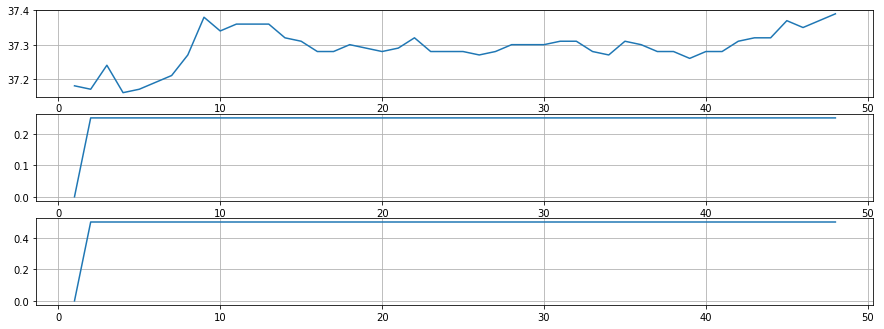

In [1243]:
from pykalman import KalmanFilter

n=1
for i in range(n):
    env.step(0)

steps+=n

if steps<16:
    fetch=16
else:
    fetch= steps

pp=np.array([env.data.get_t_data(-i)[2:6] for i in range(fetch)])
d = np.log(pp)

mean = d.mean()
kf = KalmanFilter(initial_state_mean=mean, n_dim_obs=4)
v = kf.em(d)
p=v.smooth(d)[0]
d = p.flatten()
d = d[::-1]
h = np.diff(d)

s = h.std()
h = h / s
o = ''
for i in range(len(h)):
    if h[i] > 0.43:
        o = o + 'a'
    elif h[i] < -.43:
        o = o + 'c'
    else:
        o = o + 'b'
print(o)
# signal = list(map(lambda x: 1 if x[0] == 'a' else -1 if x[0] == 'c'
# else 1 if x[1] == 'a' else -1 if x[1] == 'c'
# else 1 if x[2] == 'a' else -1 if x[2] == 'c' else 0,
#                 [(o[i], o[i - 1], o[i - 2]) for i in range(2, len(o))]))
# signal.insert(0,1 if o[1] == 'a' else -1 if o[1] == 'c' else 0)
# signal.insert(0,1 if o[0] == 'a' else -1 if o[0] == 'c' else 0)

signal = list(map(lambda x: 1 if x == 'a' else -1 if x == 'c' else 0,
                          [o[i] for i in range(len(o))]))

di=[]
for i in range(fetch):
    di.append([env.data.get_t_data(-i)[5]-env.data.get_t_data(-i)[2]]) 


di=np.array(di[::-1])
signal = di / np.linalg.norm(di)
# signal = list(map(lambda x: 1 if x >0 else -1 if x <0 else 0,
#                           [di[i] for i in range(len(di))]))
 
x5=[]
x4=[]
x0=[]

nn= int(fetch / 16)
mm= fetch % 16
 
aa=signal[0:mm]
dwt=modwt(aa, 'db2', 5)

y5 = dwt[5]
nd5 = np.linalg.norm(y5)
if nd5 !=0:
    y5=2*y5/nd5
x5=x5+list(y5)
 
y4 = dwt[4]
nd4 = np.linalg.norm(y4)
if nd4 !=0:
    y5=2*y5/nd4
x4=x4+list(y4)

y0 = dwt[0]
nd0 = np.linalg.norm(y0)
if nd0 !=0:
    y5=2*y5/nd0
x0=x0+list(y0)
 
for i in range(nn):
    aa=signal[mm+i*16:mm+(i+1)*16]
    dwt=modwt(aa, 'db2', 5)
    
    y5 =dwt[5]
    nd5 = np.linalg.norm(y5)
    if nd5 !=0:
        y5=2*y5/nd5
    x5=x5+list(y5)
    
    y4 = dwt[4]
    nd4 = np.linalg.norm(y4)
    if nd4 !=0:
        y5=2*y5/nd4
    x4=x4+list(y4)
    
    y0 = dwt[0]
    nd0 = np.linalg.norm(y0)
    if nd0 !=0:
        y5=2*y5/nd0
    x0=x0+list(y0)
    
fig=plt.figure(1,figsize=(15,15))
pp=pp[:,3][::-1]
print('Flag:',previous,x5[-1],previous*x5[-1])
sig=[]
prev=[]
for i in range(1,len(x5)):
    prev.append(x5[i-1])
    sig.append(x5[i-1]*x5[i])
    
sig.insert(0,0)    
prev.insert(0,0)

previous = x5[-1]
t=[i+1 for i in range(fetch)]
plt.subplot(811)
plt.plot(t,pp)
plt.grid()
plt.subplot(812)
#plt.plot(t, x5 )
plt.plot(t,sig)
plt.grid()
plt.subplot(813)
plt.plot(t, prev)
plt.grid()

# plt.subplot(814)
# plt.plot(t, ws[0])
# plt.grid()
# plt.subplot(815)
# plt.plot(t, ws[4])
# plt.grid()
# plt.subplot(816)
# plt.plot(t, ws[3])
# plt.grid()
# plt.subplot(817)
# plt.plot(t, ws[2])
# plt.grid()
# plt.subplot(818)
# plt.plot(t, ws[1])
# plt.grid()

plt.show()  

bbbbaaaaaabccccccbccbbbaaacccbabcbbbaaaabbbabccaaaabbcccccbcbaabcbaabcbaacccbababcabcccbaaaabbccbcccccabccaababcccabaacbaaaaaaaaaaaaaaaaababccbcbaaaaacccaabbabbcaaaaacaaacccbbbbaaccbabbccbcbbaaaaacccbbccbaabbbaacccbccccbaaabbbaaaacbaabcccaaabbabbbaaaaaccbcbabbaabbbcccaaacccccbbabaabccccccccccccccaabcbbaaccbaaaaabbacccccaaaabababbccccbcccbacaaaaabbcbcccbcbaacbbbbbaaccbcccbaaabbccaabcccbaa


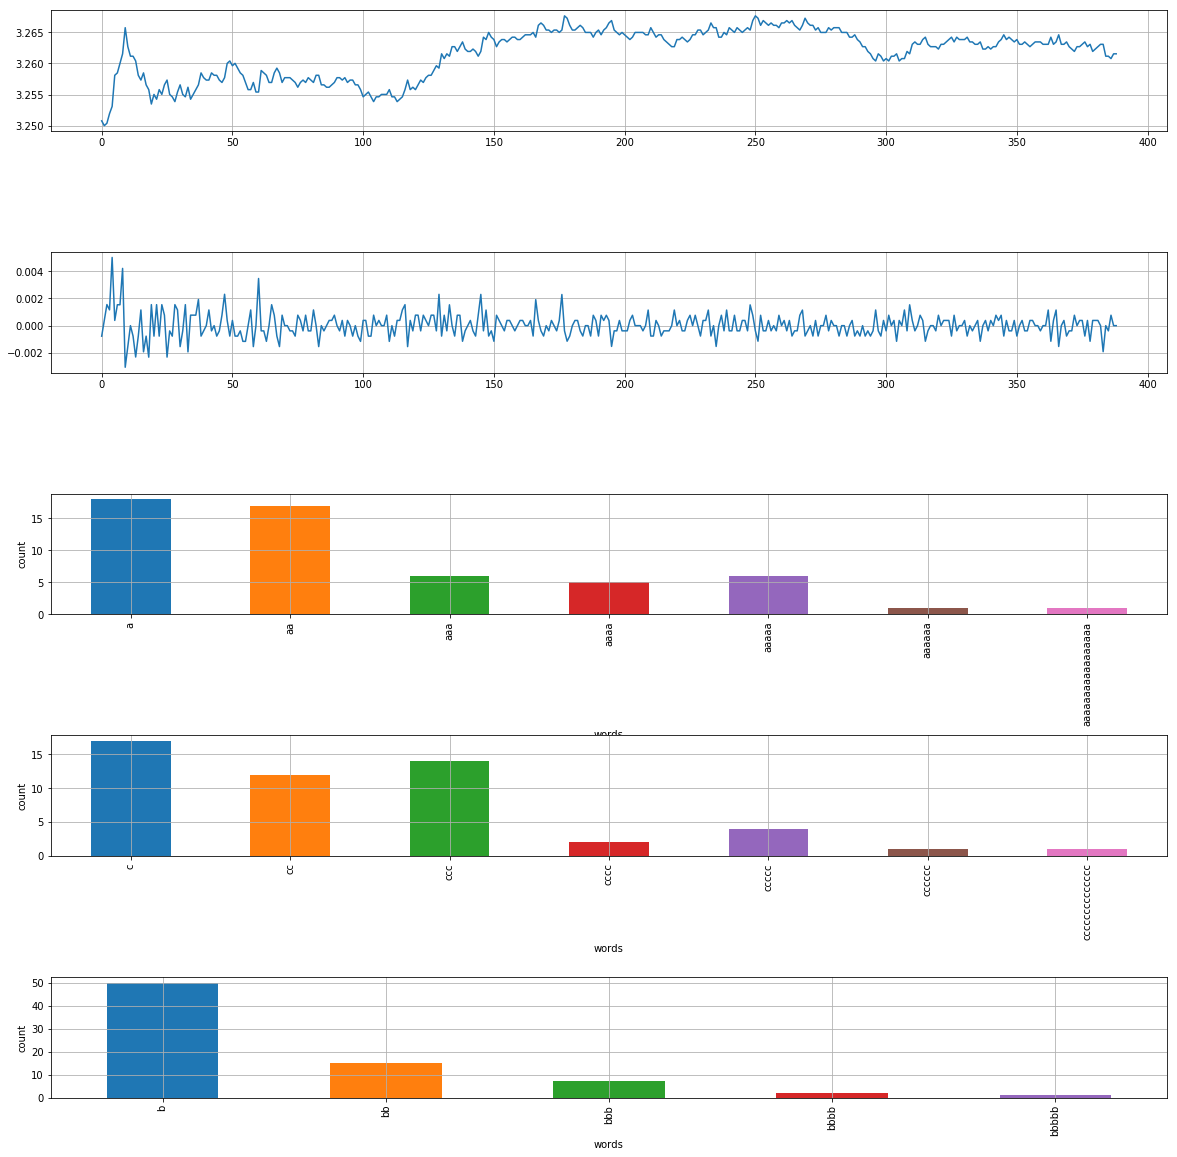

In [1259]:
#aday='06/27/2007'
#aday='08/08/2012'
aday = '12/31/2015'
plotcountergraph(env,aday)


In [1258]:
s1 = np.array([2,3,2,3,2,3,2,3,2,3])
s2=np.array([1,2,1,2,1,2,1,2,1,2])
s2=s2+1
print(s2)

[2 3 2 3 2 3 2 3 2 3]


0.5


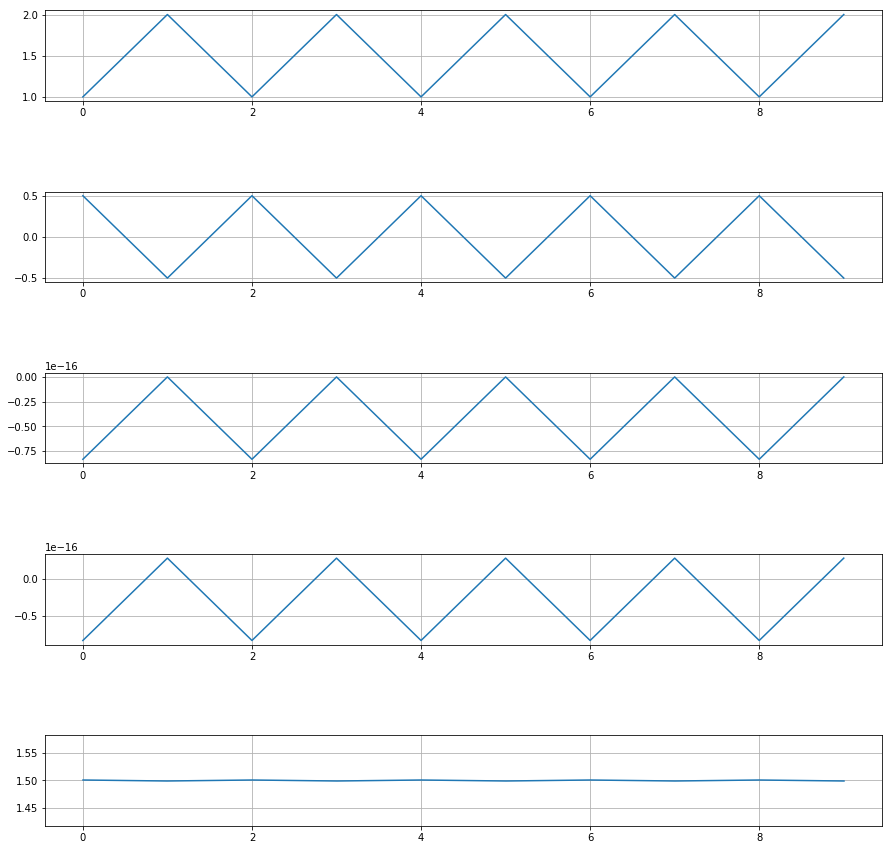

In [1247]:
s1 = np.arange(10)
s1=np.array([1,2,1,2,1,2,1,2,1,2])
 
print(s1.std())
ws = modwt(s1, 'db2', 3)
#s1p = imodwt(ws, 'db2')
#mra = modwtmra(ws, 'db2')

fig=plt.figure(1,figsize=(15,15))
fig.subplots_adjust(hspace=1.0)

t=[i for i in range(10)]
plt.subplot(511)
plt.plot(t, s1)
plt.grid()
plt.subplot(512)
plt.plot(t, ws[0])
plt.grid()
plt.subplot(513)
plt.plot(t, ws[1])
plt.grid()
plt.subplot(514)
plt.plot(t, ws[2])
plt.grid()
plt.subplot(515)
plt.plot(t, ws[3])

plt.grid()

plt.show() 

In [6]:
 def plotcountergraph(env,aday):
        
    data, sax,a_counter,b_counter,c_counter = env.ConvertAdaytoSAXstring(aday)
    
    print(sax)


    t = [i for i in range(389)]
    p1= np.log(np.array([data.get_i_data(i)[5] for i in range(390)]))
    p2     =np.diff(p1) 

    
        
    
    def plotagraph(c,ax): 
        data  = (list(c.values()))
        names  = (list(c.keys()))

        ds = pd.Series(data)
        x_labels=names

        ds.plot(kind='bar') 
        ax.set_xlabel('words')
        ax.set_ylabel('count')
        ax.set_xticklabels(x_labels)

    fig=plt.figure(1,figsize=(20,20))
    fig.subplots_adjust(hspace=1.0)
     
    plt.subplot(511)
    plt.plot(t, p1[:-1])
    plt.grid()
    plt.subplot(512)
    plt.plot(t, p2)
    plt.grid()
    plotagraph(a_counter,plt.subplot(513))
    plt.grid()
    plotagraph(c_counter,plt.subplot(514))
    plt.grid()
    plotagraph(b_counter,plt.subplot(515))

    plt.grid()

    plt.show() 

bbbbaaaaaabccccccbccbbbaaacccbabcbbbaaaabbbabccaaaabbcccccbcbaabcbaabcbaacccbababcabcccbaaaabbccbcccccabccaababcccabaacbaaaaaaaaaaaaaaaaababccbcbaaaaacccaabbabbcaaaaacaaacccbbbbaaccbabbccbcbbaaaaacccbbccbaabbbaacccbccccbaaabbbaaaacbaabcccaaabbabbbaaaaaccbcbabbaabbbcccaaacccccbbabaabccccccccccccccaabcbbaaccbaaaaabbacccccaaaabababbccccbcccbacaaaaabbcbcccbcbaacbbbbbaaccbcccbaaabbccaabcccbaa


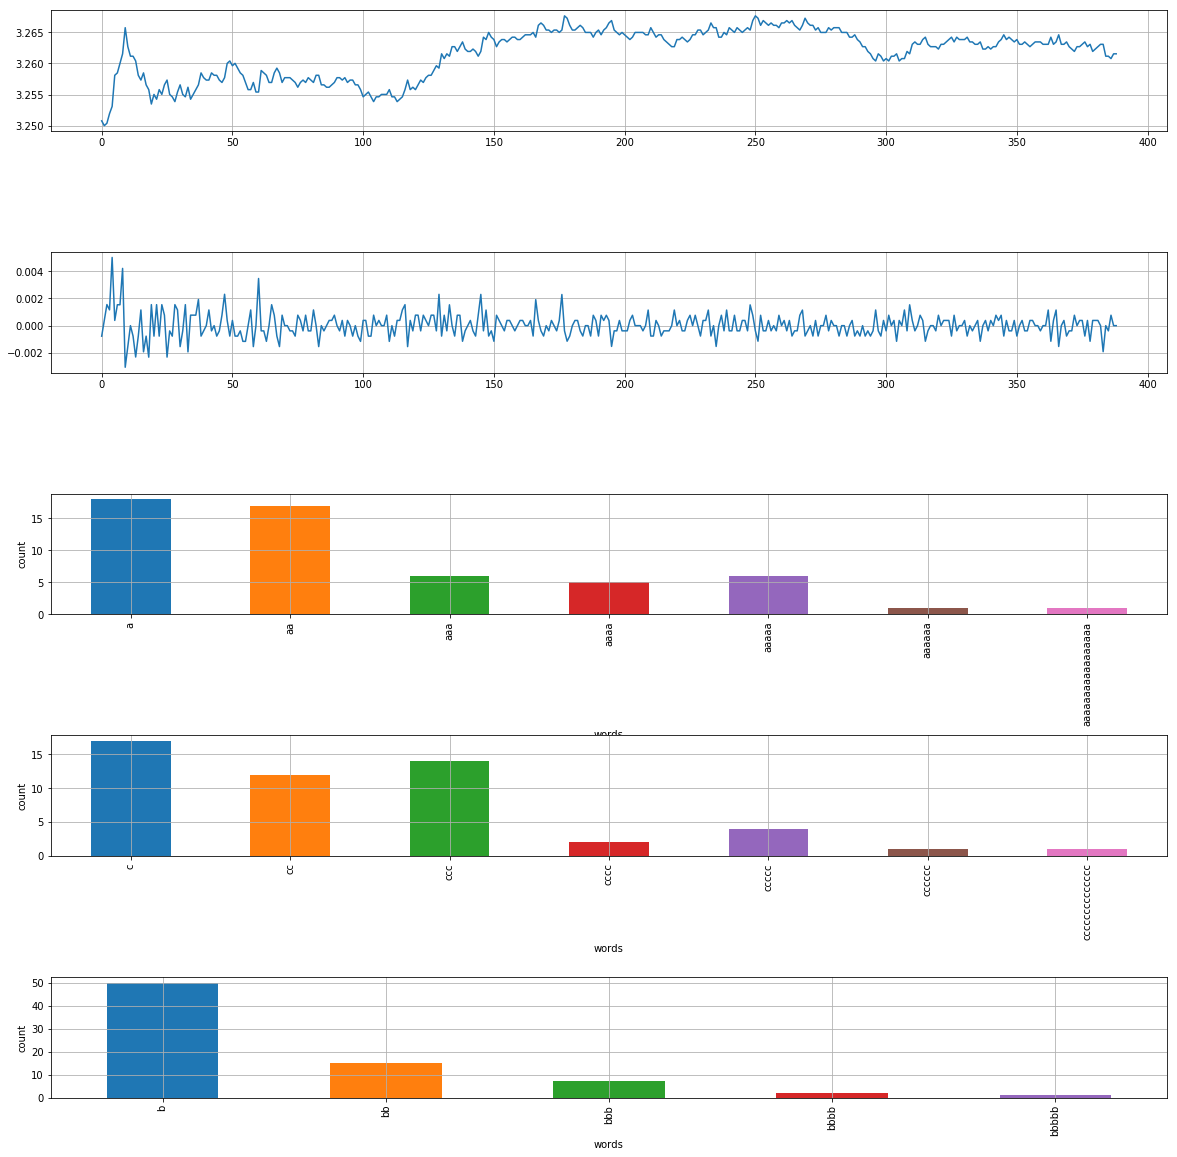

In [1261]:
plotcountergraph(env,'12/31/2015')


In [980]:
 
def plotaday(aday):
    
    data, sax,c2 = env.ConvertAdaytoSAXwords(aday)
    
    print([str(i)+sax[i] for i in range(len(sax))])

    #data 



    t = [i for i in range(389)]
    p1= np.log(np.array([data.get_i_data(i)[5] for i in range(390)]))
    p2     =np.diff(p) 

    plt.figure(1,figsize=(20,20))
    plt.subplot(211)
    plt.plot(t, p1[:-1])
    plt.subplot(212)
    plt.plot(t, p2)
    

#     data = (list(c2.values()))
#     names = (list(c2.keys()))

#     ds = pd.Series(data)
#     x_labels=names

#     ax=plt.subplot(313)
#     ds.plot(kind='bar') 
#     ax.set_xlabel('words')
#     ax.set_ylabel('count')
#     ax.set_xticklabels(x_labels)
 
    plt.show() 
    

In [1019]:
std=p2.std()
op=data.get_i_data(0)[5]
d=24
for n in range(1,100):
    print(2+(d-2)*np.exp(-0.693*(n/10)))

print(op,std,round(op*np.exp( 24*std),2))

22.52702792953295
21.15267616453753
19.87034175248918
18.67386383016564
17.55749402431997
16.515868834125364
15.543983862705826
14.637169773950273
13.791069859096677
13.00161910530689
12.26502466566899
11.577747636796909
10.93648605647947
10.338159039692538
9.779891976757106
9.2590027225292
8.772988710268756
8.319514928277185
7.896402701538464
7.501619224466071
7.133267794466837
6.789578699399671
6.46890071514878
6.169693172462217
5.89051855494158
5.630035592620544
5.3869928179509365
5.160222553236654
4.9486353006285775
4.751214507727709
4.567011683648314
4.395141842076652
4.234779249431838
4.085153457701273
3.9455456028907374
3.815284951305373
3.693745677068465
3.5803438553959133
3.474534657180804
3.375809731409757
3.2836947628350597
3.197747193168656
3.117554094849668
3.0427301871701387
2.9729159852276617
2.9077760728116946
2.84699749092579
2.7902882342035467
2.7373758479944303
2.6880061193793052
2.6419418558267536
2.598961745622363
2.5588592945960027
2.5214418340386917
2.48652959504

In [968]:
data, sax,a_counter,b_counter,c_counter = env.ConvertAdaytoSAXstring(aday)
t = [i for i in range(389)]
p1= np.log(np.array([data.get_i_data(i)[5] for i in range(30)]))
p2     =np.diff(p) 

 
print(p2)

[-2.0120144e-03 -2.6893616e-03  2.0177364e-03 -1.3446808e-03
  0.0000000e+00  2.3517609e-03 -2.0153522e-03  3.3617020e-04
 -6.7257881e-04 -3.3693314e-03  1.0120869e-03  1.0108948e-03
 -1.6853809e-03 -1.3504028e-03  0.0000000e+00  3.3760071e-04
 -3.3760071e-04  3.3760071e-04 -1.3518333e-03 -3.3807755e-04
 -2.0318031e-03  1.3549328e-03  0.0000000e+00  0.0000000e+00
 -1.3549328e-03 -5.0878525e-04 -5.0878525e-04 -3.3950806e-04
 -1.0221004e-03 -1.0471344e-03 -3.0946732e-04  2.7182102e-03
 -1.0185242e-03 -6.7949295e-04 -3.3998489e-04  1.3592243e-03
 -1.0192394e-03  0.0000000e+00  0.0000000e+00  6.7949295e-04
  6.7901611e-04  6.7877769e-04  6.7830086e-04 -1.3570786e-03
 -3.3926964e-04 -1.5292168e-03  5.0997734e-04 -2.0415783e-03
  6.8092346e-04  1.3606548e-03  0.0000000e+00  0.0000000e+00
  1.6975403e-04 -5.0973892e-04 -3.4022331e-04  0.0000000e+00
  1.0199547e-03  3.3974648e-04  0.0000000e+00  1.3577938e-03
 -3.3926964e-04  3.3926964e-04  1.6951561e-04  1.6975403e-04
 -5.3596497e-04  5.35964

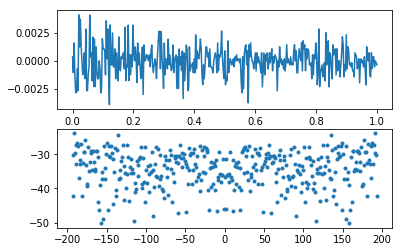

In [987]:
import scipy
import scipy.fftpack
import pylab
from scipy import pi

aday='07/28/2008' #'03/14/2017'
#aday='03/15/2017'
data, sax,a_counter,b_counter,c_counter = env.ConvertAdaytoSAXstring(aday)
#t = [i for i in range(389)]
t = scipy.linspace(0,1,389)
p1= np.log(np.array([data.get_i_data(i)[5] for i in range(390)]))
signal     = np.diff(p1) 
 
FFT = abs(scipy.fft(signal))
freqs = scipy.fftpack.fftfreq(signal.size, t[1]-t[0])
 
pylab.subplot(211)
pylab.plot(t, signal)
pylab.subplot(212)
pylab.plot(freqs,20*scipy.log10(FFT),'.')

pylab.show()

baaaaaabaabcccbbcccccbccccbaaaaaabbaaabcccccbbaaaaaaccbccccccccbbbbabbabcccccccccbbccbbbbaaaabcbaaaccbbaaabbbaaaabccccbbaaabbbaaabcccbbccbccccbaaabbaabaaaaaabccccccbbbbaaaabbccaaababcccababbcccccbabaccbaaaabbaaaaabbaaaabccccbabbbbaaacccccbaabccbcccbbcbaaabbbaaaabccbbcbbaabbbbccaabcbcbcccbbabbabbcccccbaaabbbabccccbaabcccccbbbccccbbcccbaabbbbbbcccbbbbbaaaaaacbccbaaaaabaaaccccccaaacccbbbcca


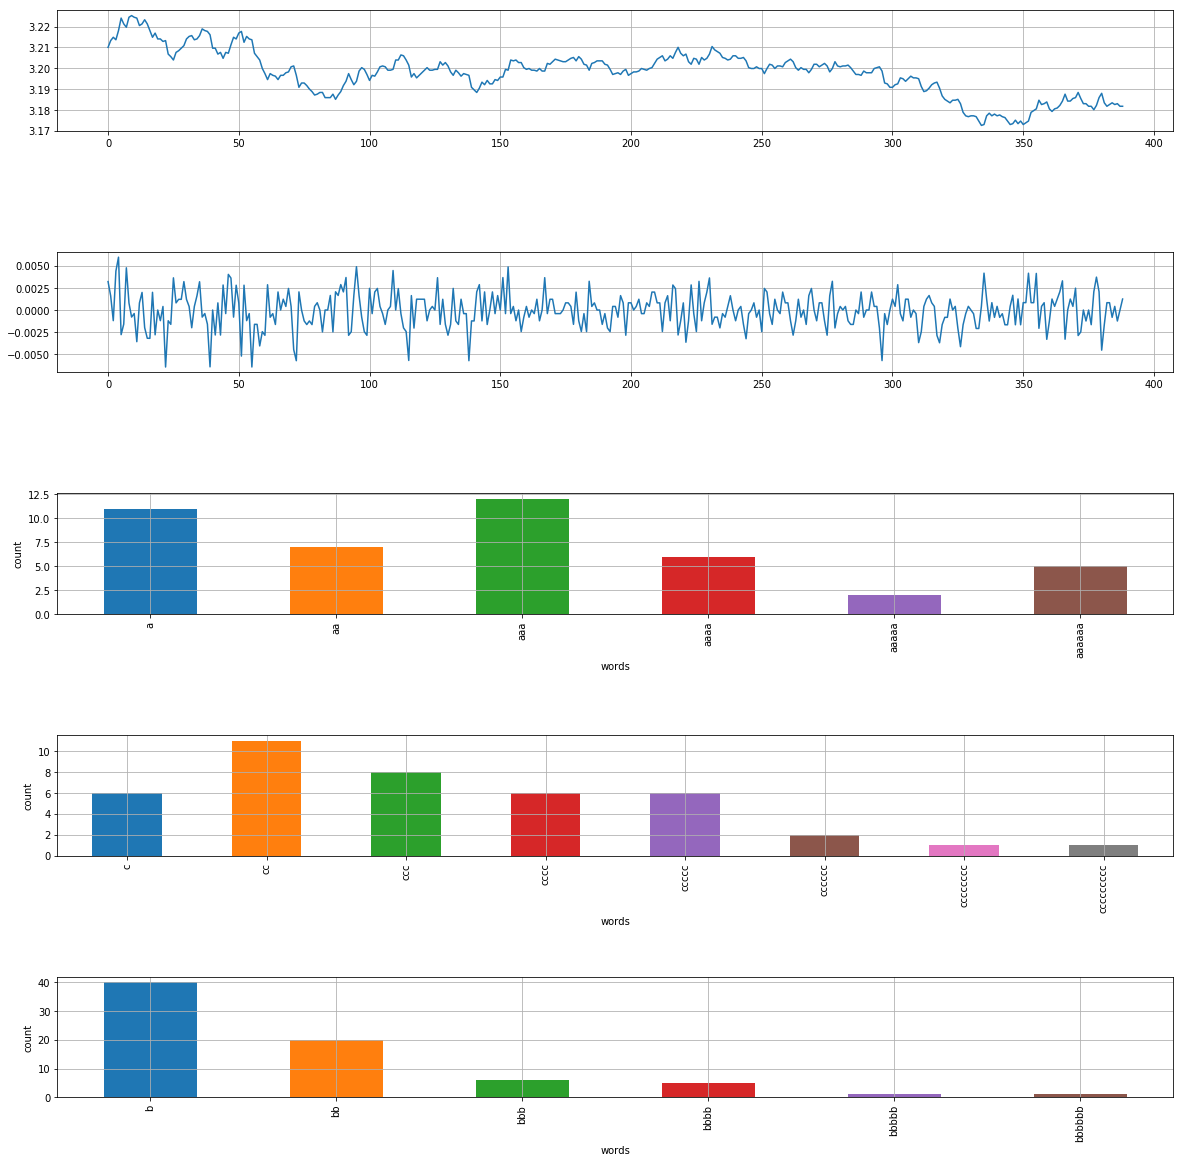

In [1024]:
aday='03/26/2009'
plotcountergraph(env,aday)

babbaaabcbbccccbacbbbbbccccabcaaaabcccbcbbcbaaaaaccbcbbaaaaaaaaaaabaabccaaabbcbbbcbbcccbbbaabaaaaaaaaabaaaaacccaaabbbaccbacccbbcbbaaaaaccbabbbbaaaaaaabbaabaaaaacbcbabcccbbbbaaaaabbbbcccbccaabcccccccbaaaaaccbaaaabaaabbbbccccbbcbbabbcccccccbbbccbaabcbbbaaaabccccbbbbaaacccccaccbcbcccbaaaaaaaaccccbbccccccbbcaacbbaaaaaaaabccbababbcccccccaaaccccbaaacbcbbbaaaaaaabccccccaaaabcccbaaaaaaaaabbaaaaa


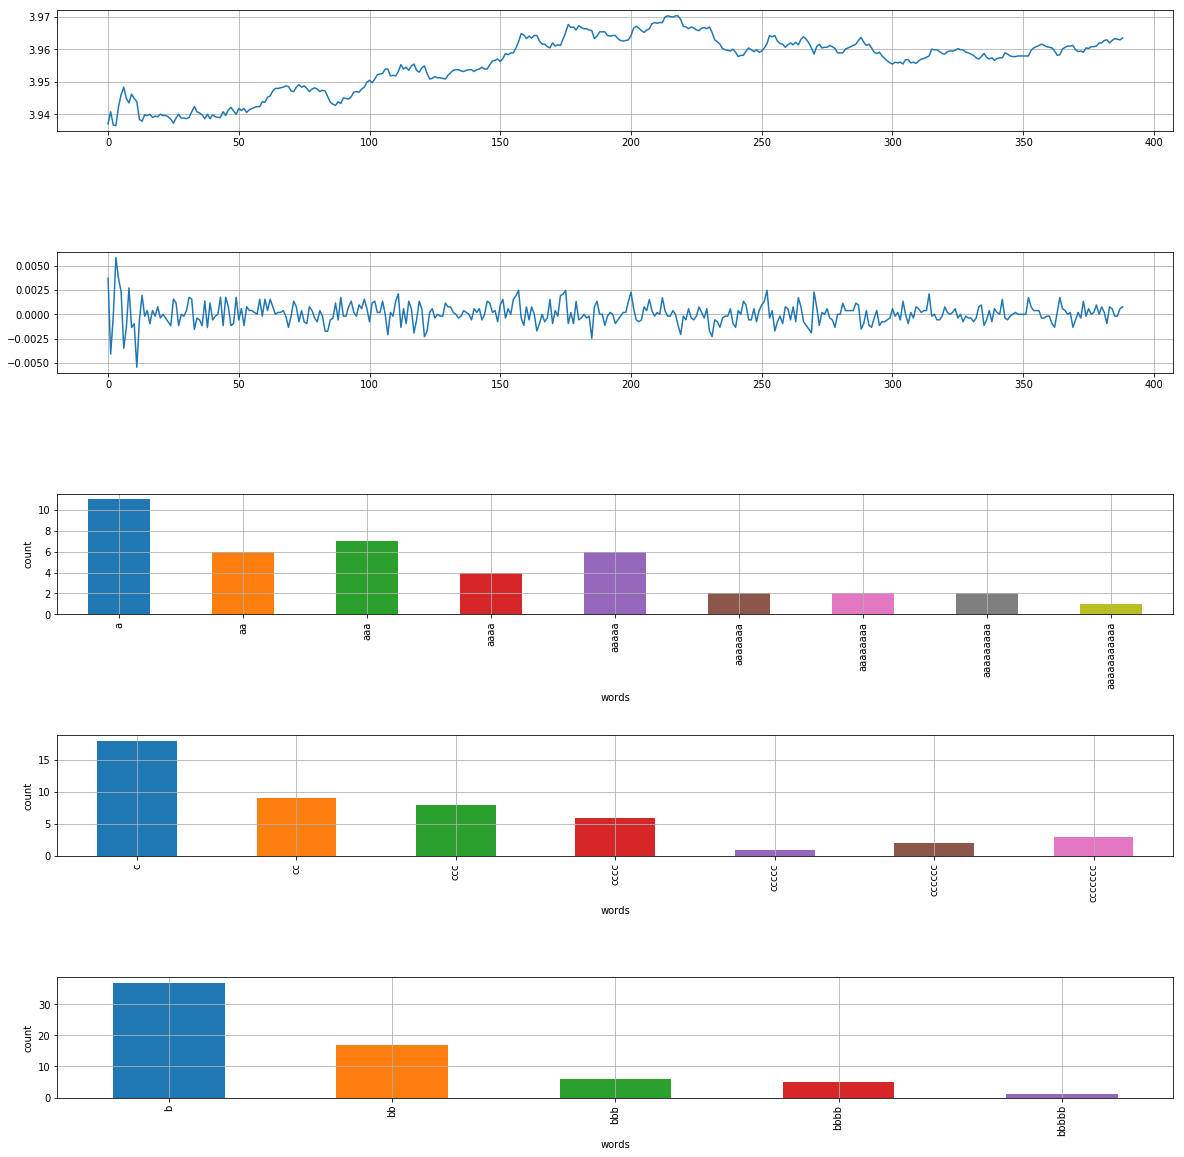

In [1025]:
aday='08/19/2008'
plotcountergraph(env,aday)


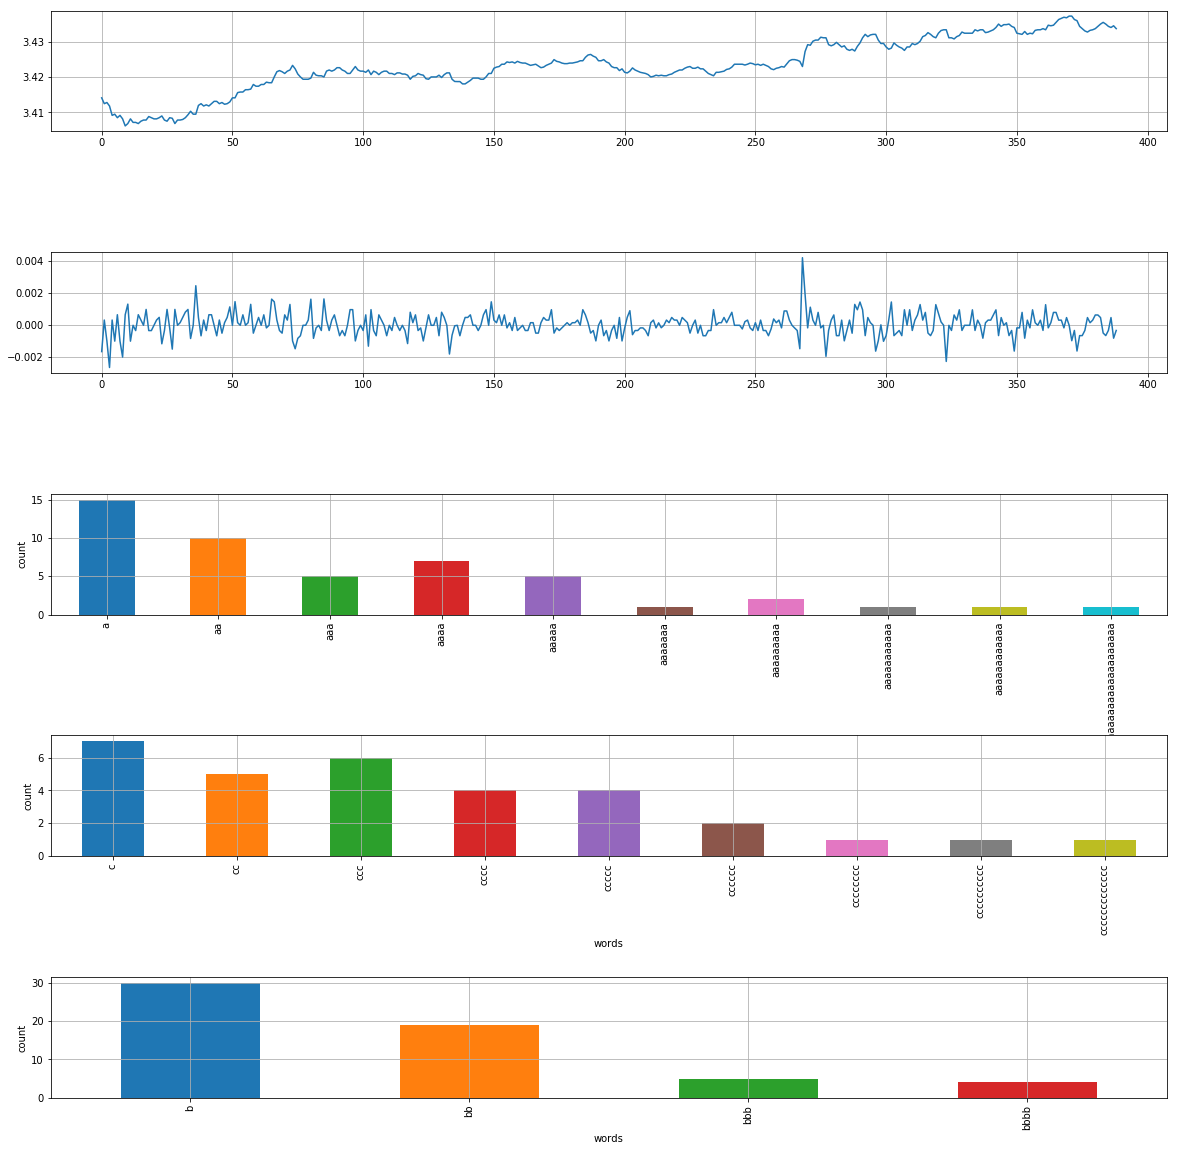

In [988]:
aday='03/15/2017'
plotcountergraph(env,aday)

bccccccccccbbbbaaaabbbbabcbaccabaaaabaaabaaabbcbbaaaaaaaaaaaaaaaaaaaaabbabbccccbbaabbbaabaabbccbaaacccabccccaacccbbaccccaaabccabbaaaaacccccbbaaaabbaaaaaaaaaaabbbcbbcbbcccaaaaacccbbababaaaabcccccccccccccbaaccccccccabcbaaaaaaaaacbbbcccccaabaaaaaaabababbbbcccccaabbaaaabbaaaaaaaaabcccbbccccbbaaaaabaccccccbaacccbaabaaaaabbcaaabccbaaaabbbaabbccbaaaabbbcccccabbbbaaaaaaaaaaaabaccccccbaaaaabccccc


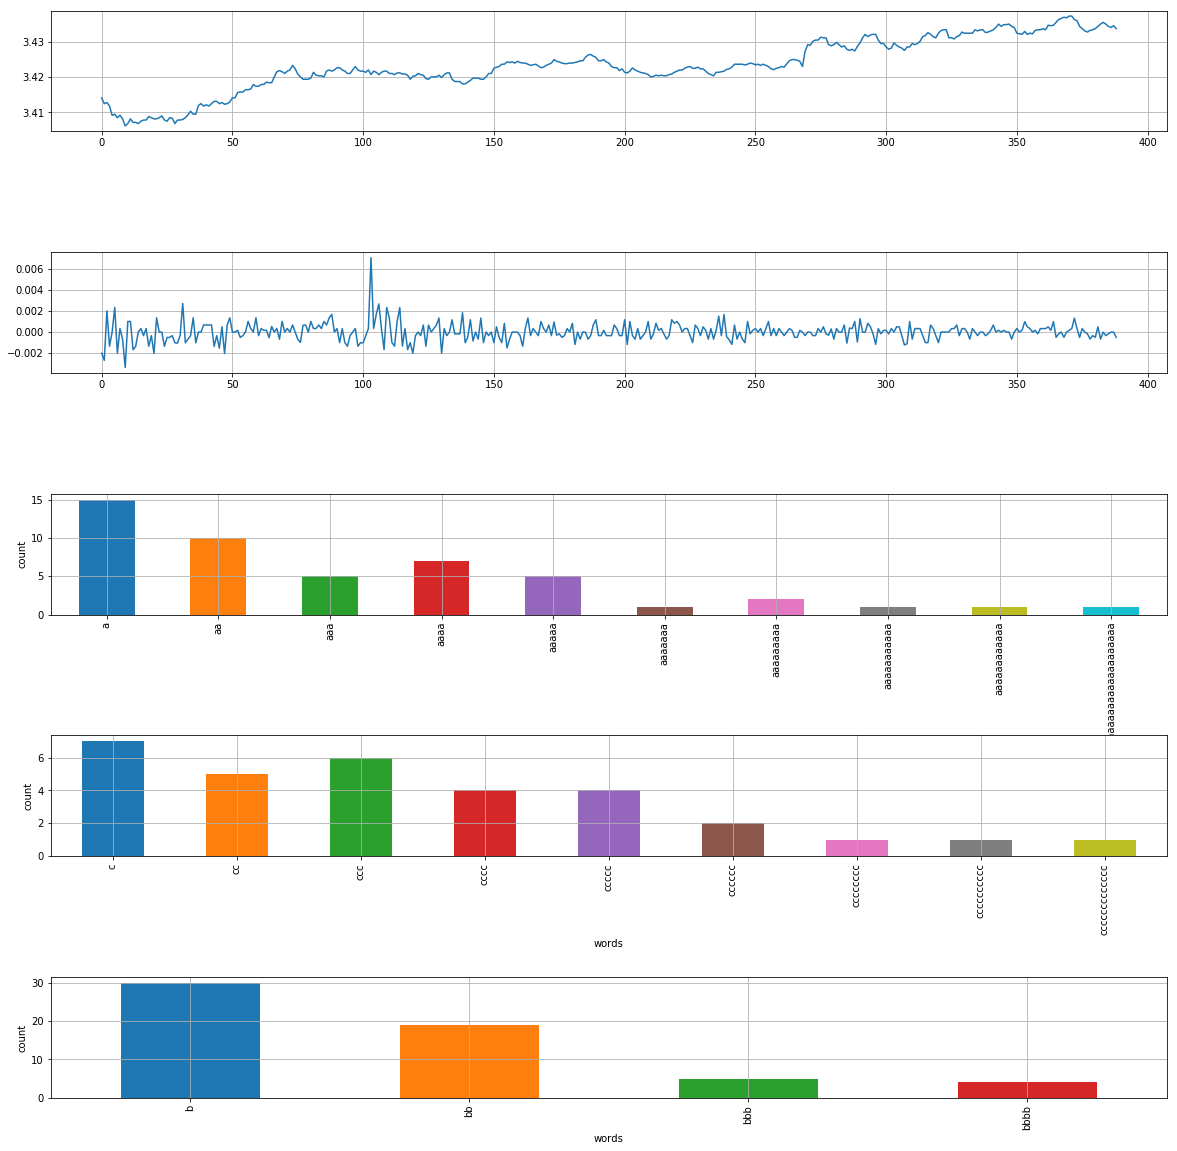

In [895]:
aday='03/15/2017'
plotcountergraph(env,aday)

bccccccaababccccccccbabccccaaaaabbccbbccccccbbccbbbbbcbaaaabcbaaaabccbaaaaaabbcccbcccccccccccbbaaaaabbbbbccccccccccbbcaabccaaaabaaaaaaaaabbaaaaaaaaaacbccccccbabbbbaaabaaccbaaaabccbabbbbbbbcbbbaaaabcbabcccccbcccabbcccbccccbacbbbcbbbccccccccbaaabbaccbaaaaaaaaaaaaaaaabcbaccbbaaccbaabcbbbbccccaaaaccccaabbaabcccccccccccbbcaaabbabbcccaccccbbcaaacaaccccccccccccccbccbaaaabccccbaacbbbbcccaaabbbbb


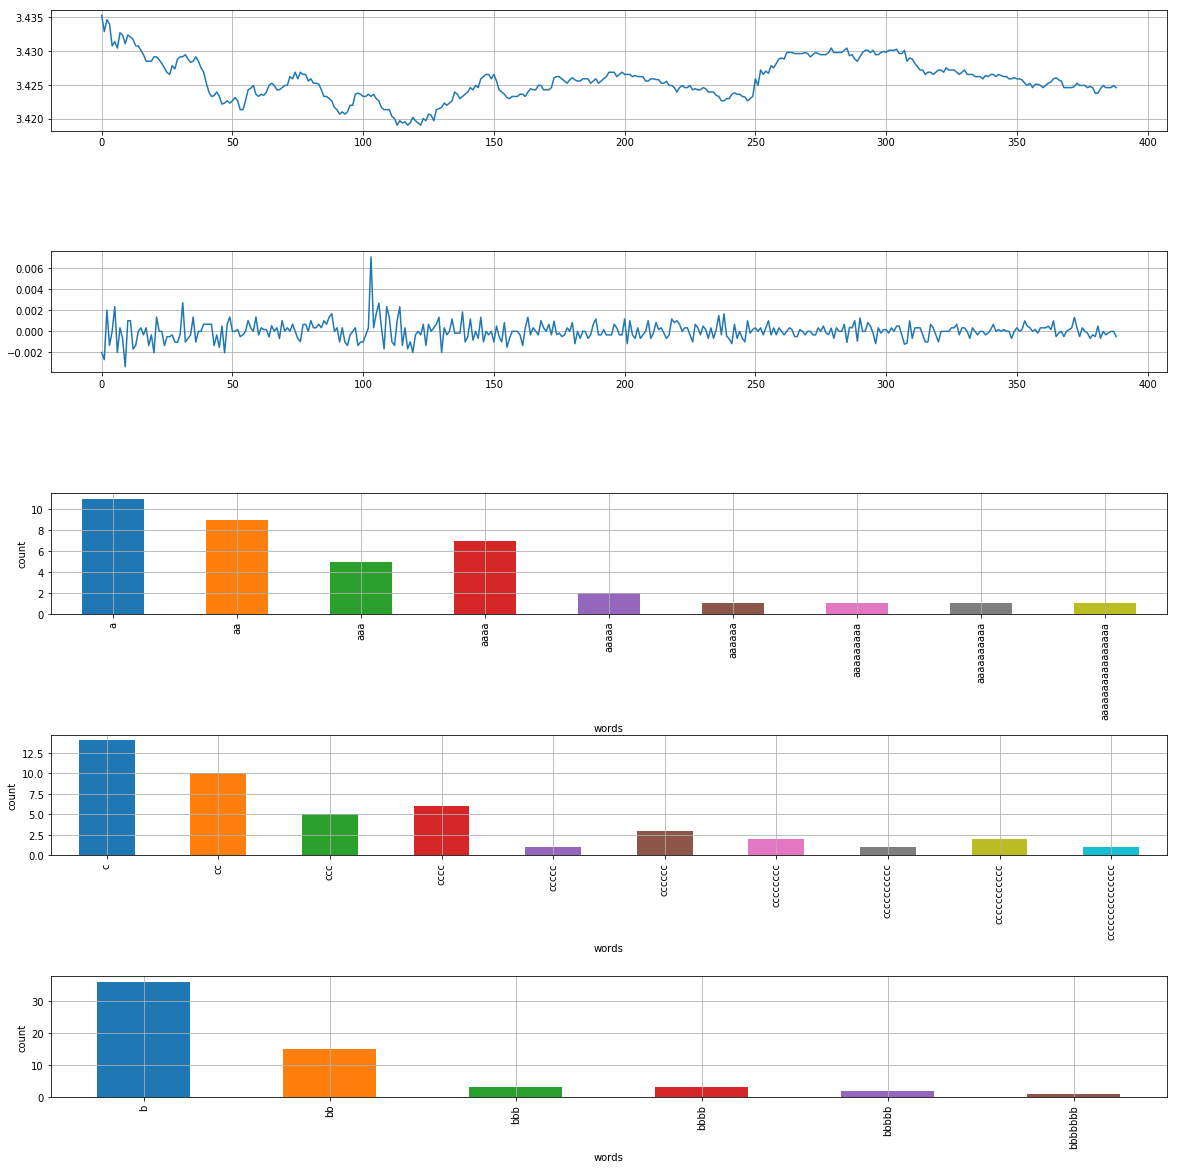

In [896]:
aday='3/16/2017'
plotcountergraph(env,aday)

bbbaccccccccbaaabbaaabccbcbbccbaabbaaabaccbbcccccbaaccaabaaabaaabccccbbbabcbbccbabbbabbaaaabcbccbabaabcbaaaaaabccccbabbaaabccccbabaabbbcccccccccaaabccaaaaaaabbbaaaaaaaabaaccccccccbaaaacccaaabcbbbcccbaaaaaabccbaacccbcccaaaaabbaabbbbacbaaaaaaaaabababbabcccccaabbabcaabbccbaabbcaabaabbabcccbbbccccaaaccaabacbccbcbaabccbaaacccbaaacbcbabbbaccccccccbcbcbabcccccbabccccbbccccbbccaabbabbbabbbcccccc


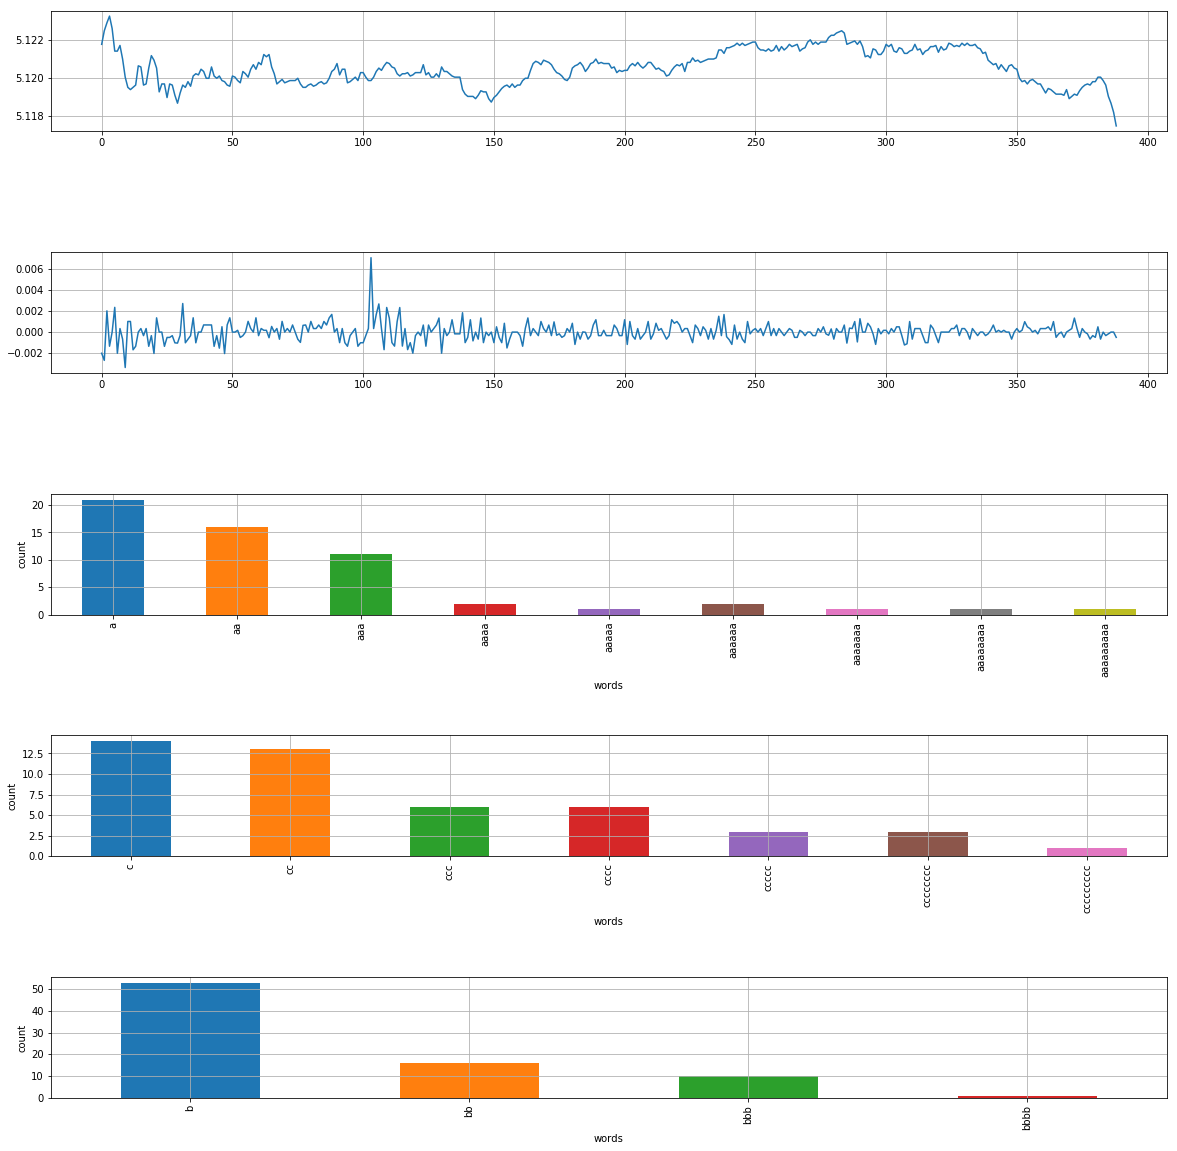

In [907]:
aday='3/17/2017'
plotcountergraph(env,aday)

bbccbaaaabccccccaaababcccbcccbaaaaabbbacccbccccbccbbbbccbaaaabbbccccbaaabcccccccccccccabcbcbacbbbabcccbaccbbccccbbaaaaabaaaabaabccbaababbccccccccaabbbaaababaaabaaaaaaaabcccccaaaaaaaaccccaaaaaaaaaaccaaaaaabcccbaaaaaaaabbbaaaacbbcbaabccccccccbbaabbcccccccbabbaaaaaccccccbaabcbbabbbabccaaaabbaabccbaaaabcccbababbbccbbbcbaaaabccccccbbbaaabccabbbbabbbbcccccccbbbbcbaaabbcccccccbbcccaabbbaaaaaaaa


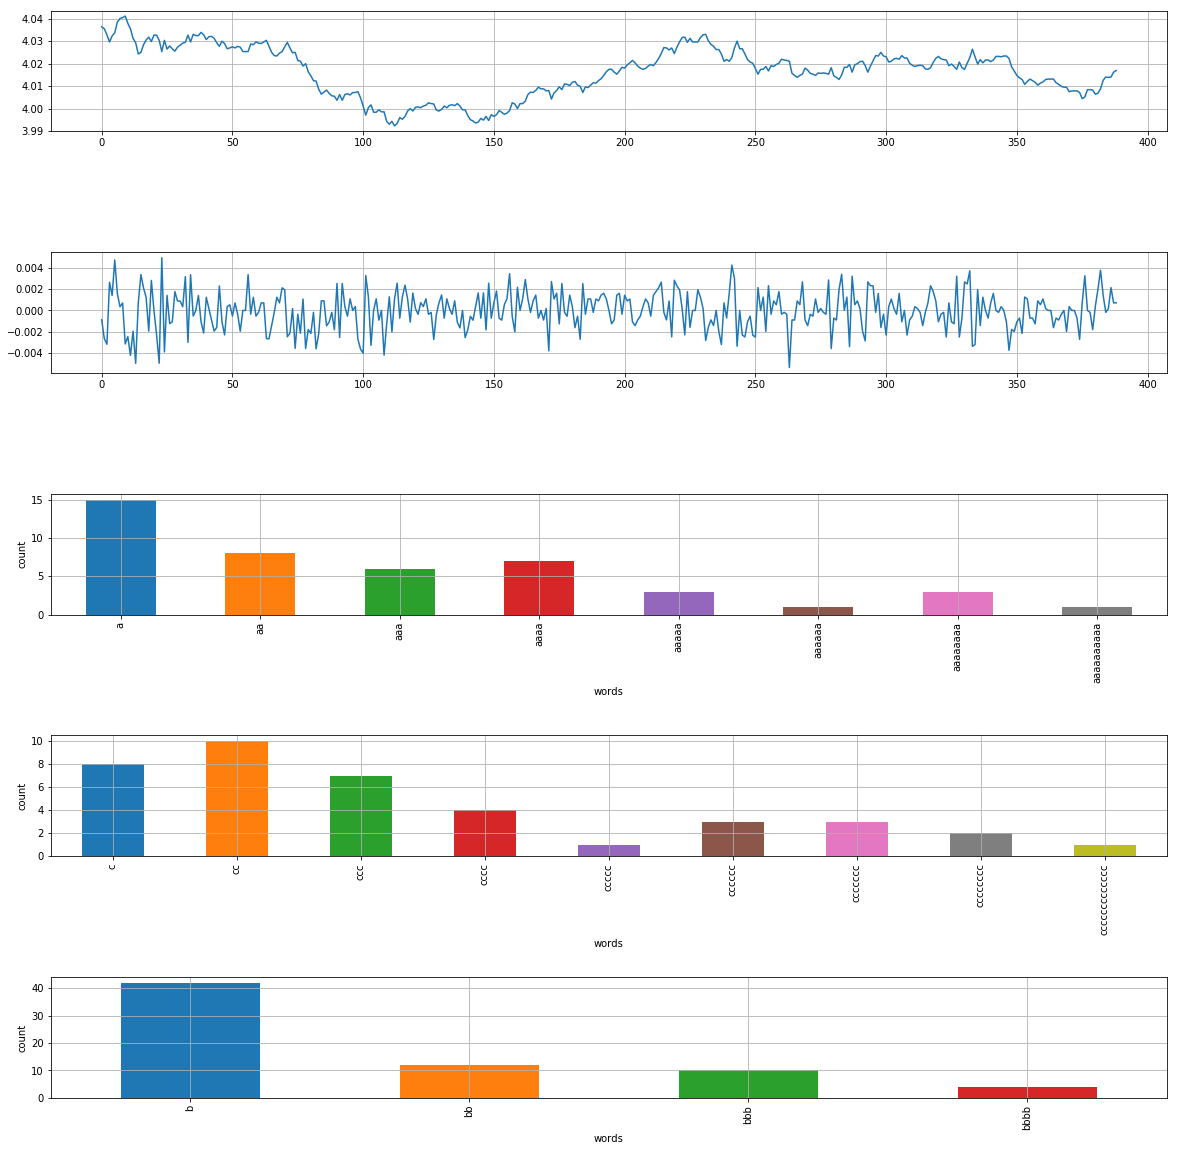

In [1026]:
aday='7/24/2008'
plotcountergraph(env,aday)

bccccccccccbbbbaaaabbbbabcbaccabaaaabaaabaaabbcbbaaaaaaaaaaaaaaaaaaaaabbabbccccbbaabbbaabaabbccbaaacccabccccaacccbbaccccaaabccabbaaaaacccccbbaaaabbaaaaaaaaaaabbbcbbcbbcccaaaaacccbbababaaaabcccccccccccccbaaccccccccabcbaaaaaaaaacbbbcccccaabaaaaaaabababbbbcccccaabbaaaabbaaaaaaaaabcccbbccccbbaaaaabaccccccbaacccbaabaaaaabbcaaabccbaaaabbbaabbccbaaaabbbcccccabbbbaaaaaaaaaaaabaccccccbaaaaabccccc


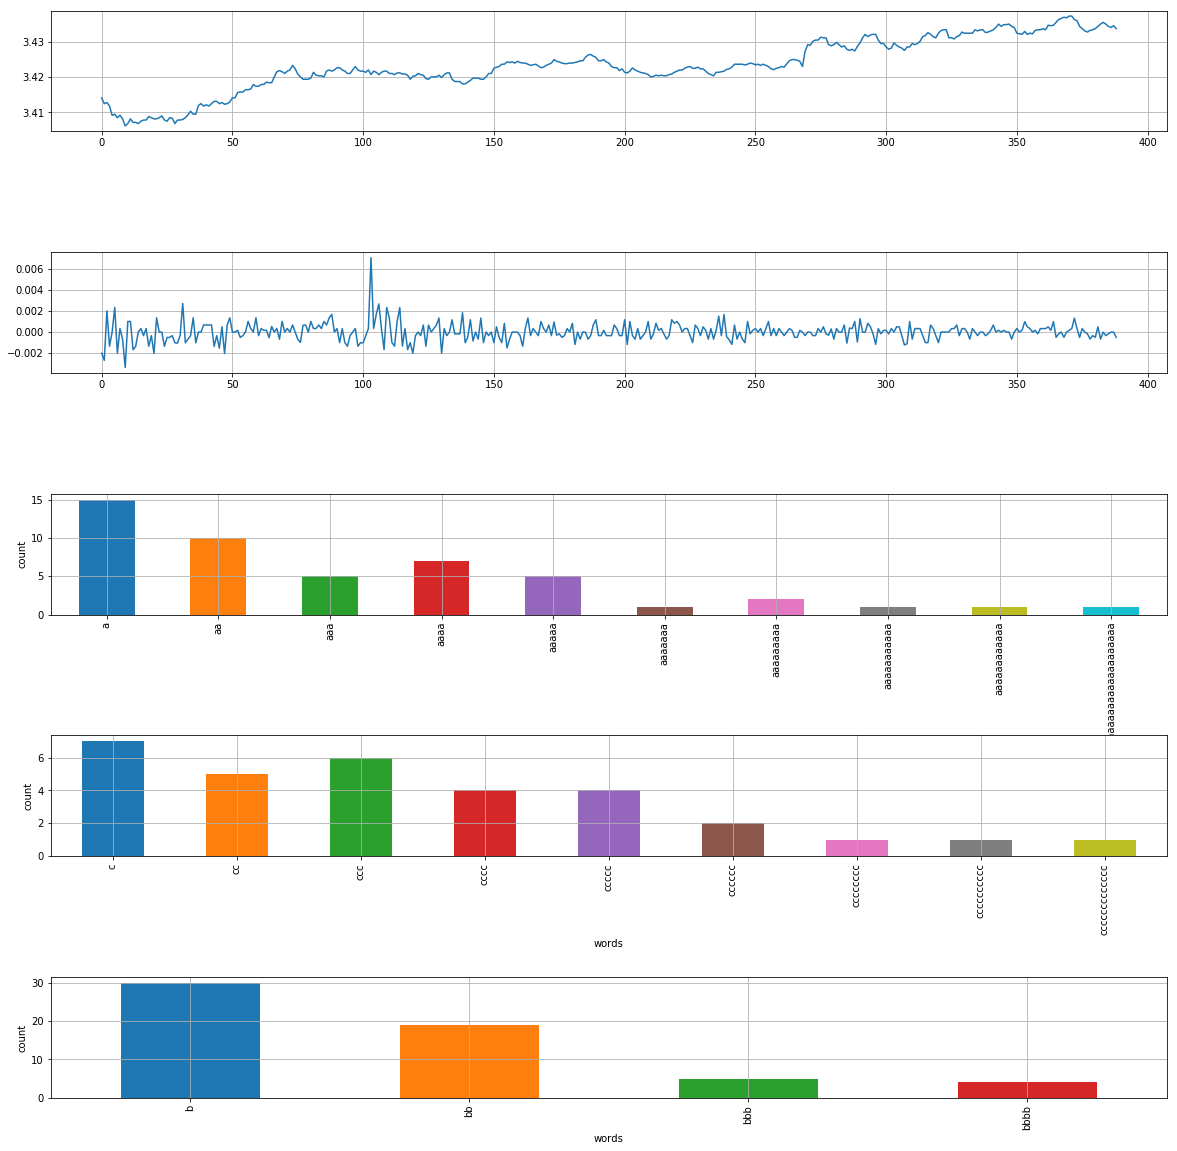

In [898]:
plotcountergraph(env,'03/15/2017')

bccccccaababccccccccbabccccaaaaabbccbbccccccbbccbbbbbcbaaaabcbaaaabccbaaaaaabbcccbcccccccccccbbaaaaabbbbbccccccccccbbcaabccaaaabaaaaaaaaabbaaaaaaaaaacbccccccbabbbbaaabaaccbaaaabccbabbbbbbbcbbbaaaabcbabcccccbcccabbcccbccccbacbbbcbbbccccccccbaaabbaccbaaaaaaaaaaaaaaaabcbaccbbaaccbaabcbbbbccccaaaaccccaabbaabcccccccccccbbcaaabbabbcccaccccbbcaaacaaccccccccccccccbccbaaaabccccbaacbbbbcccaaabbbbb


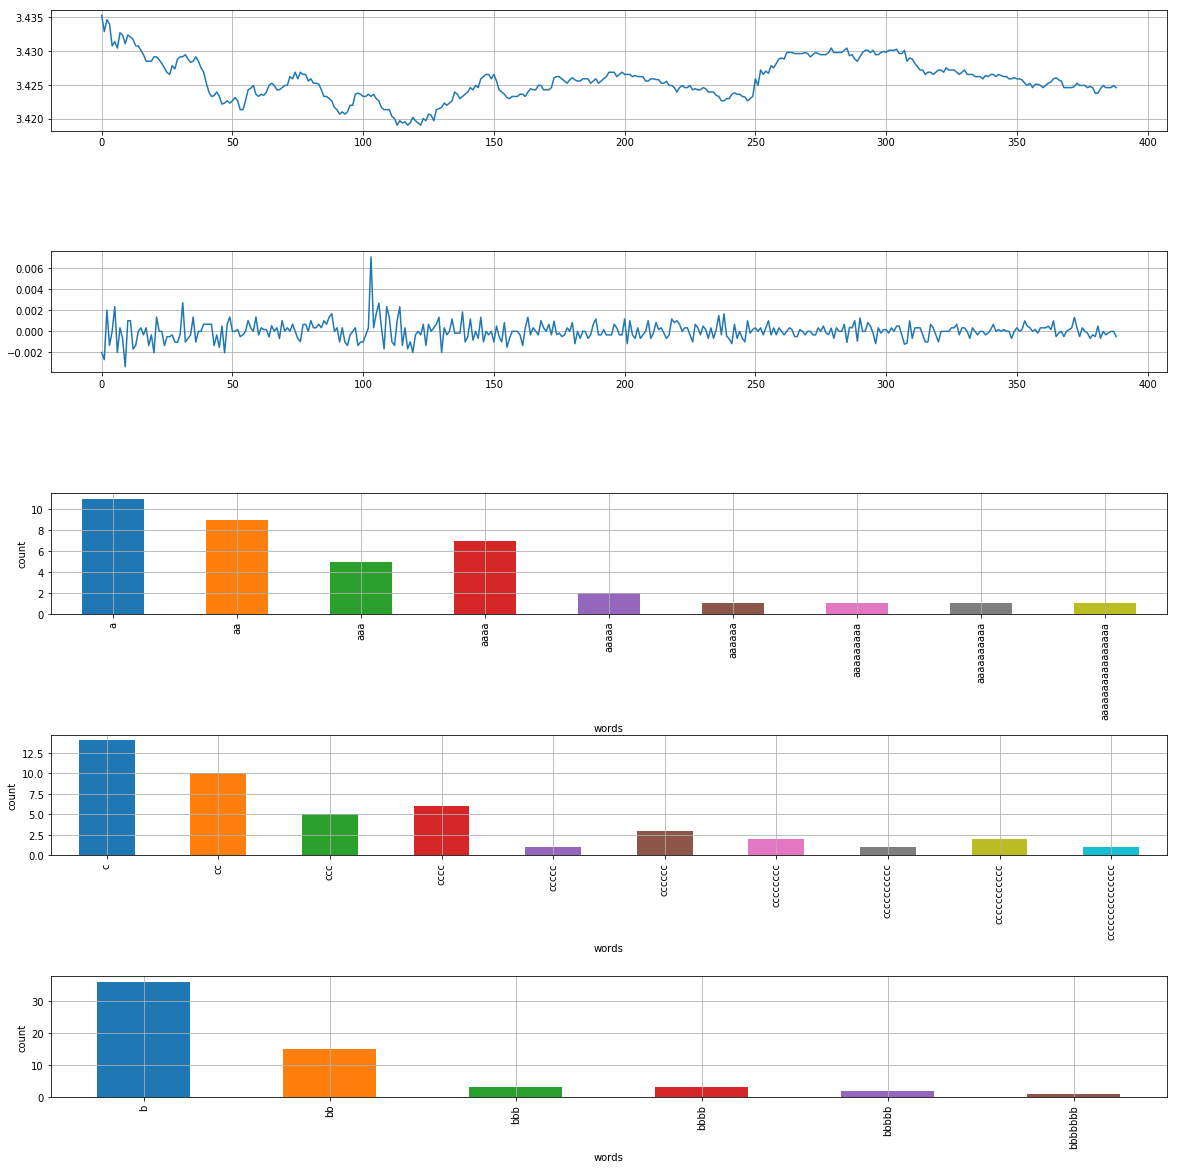

In [900]:
aday='03/16/2017'
plotcountergraph(env,aday)

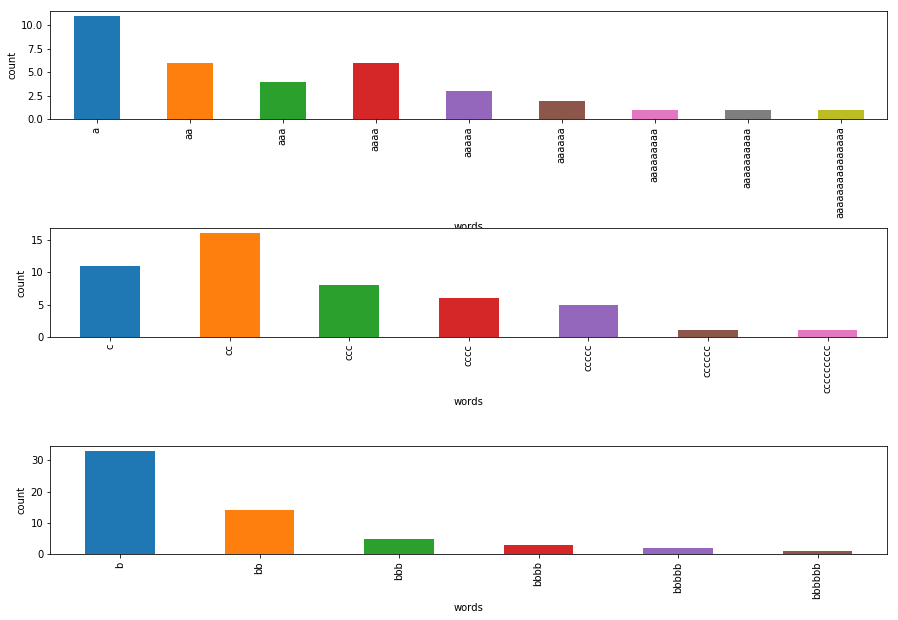

In [747]:
plotcountergraph(env,'03/16/2017')

baaaacbcccccbbbaaaaaabcccaccccccccccabccccccbaaaaabbcbaaaabaaaaaaaaababaaaacccaaaacbabaaaaaaaaaaaaacccccbcaabaaaaabcbcaccbcccccaaabacbaaaabcbaabbbcccbcaaaaaaaacaaabaacccccbccccbbaabcbabbbaaabcccccbbcbbbabcbccaaccccbbbbccccccccbabcbaabaaaaaabbcccccbaaaabcbcbacbcbbcccbbaaaaaaabbbbabcbbbccccccccbbbcccbbaaaaaaaaaabbbabccbcbabcaabbbcaaaaaaabaabcbbccccaaaaaaaaaabcccbaaaaaabcaaabcbcbaabaaaaabcb


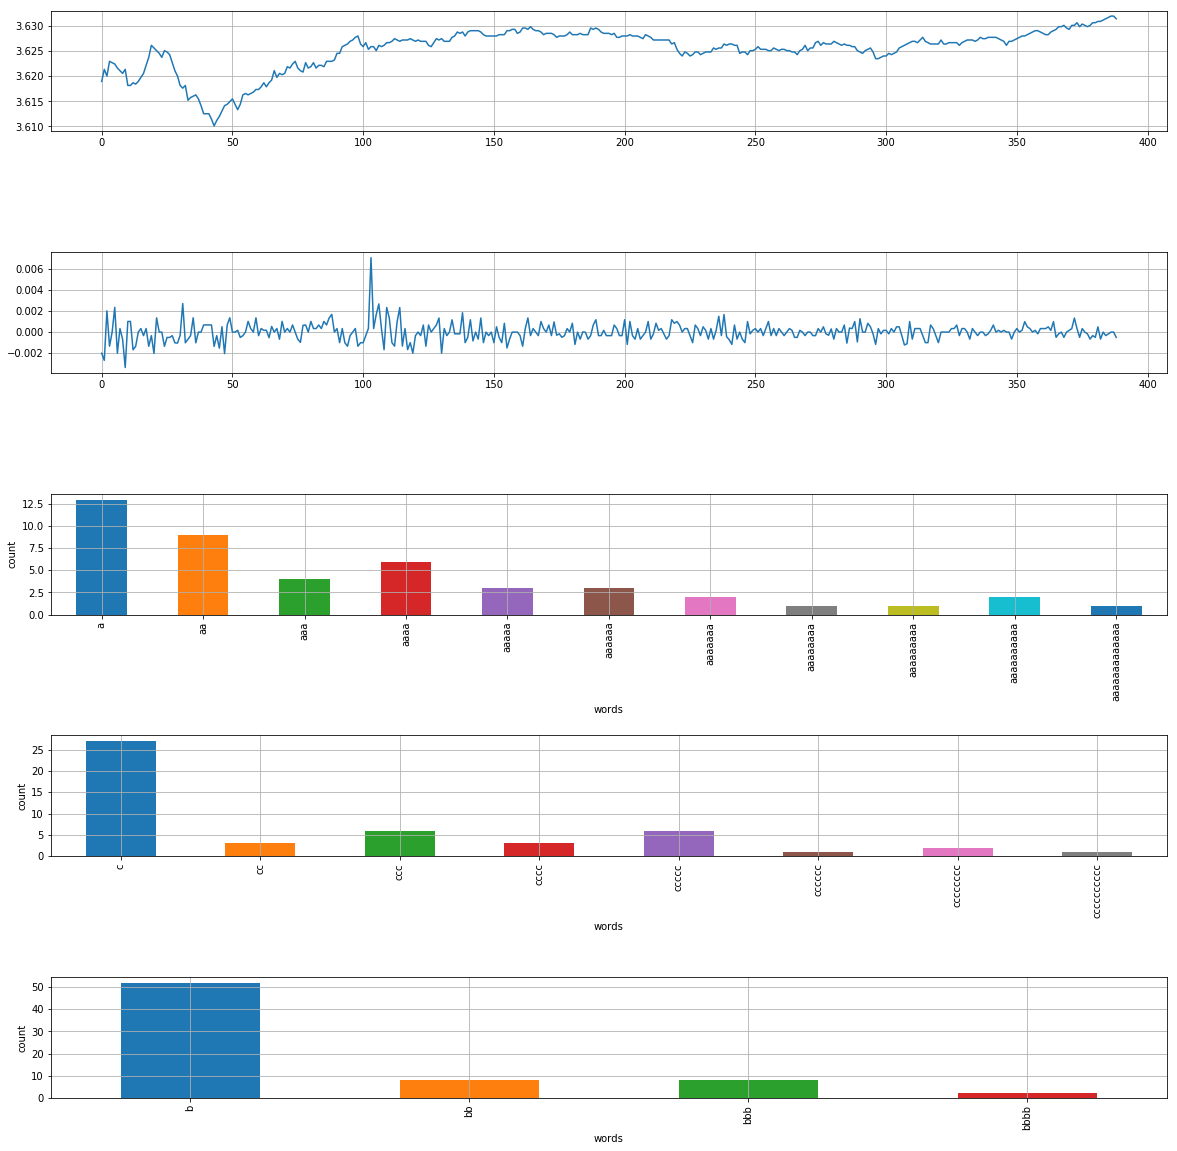

In [911]:
aday='12/27/2006' 
plotcountergraph(env,aday)

In [1]:
aday='02/2/2016'
plotcountergraph(env,aday)

NameError: name 'plotcountergraph' is not defined

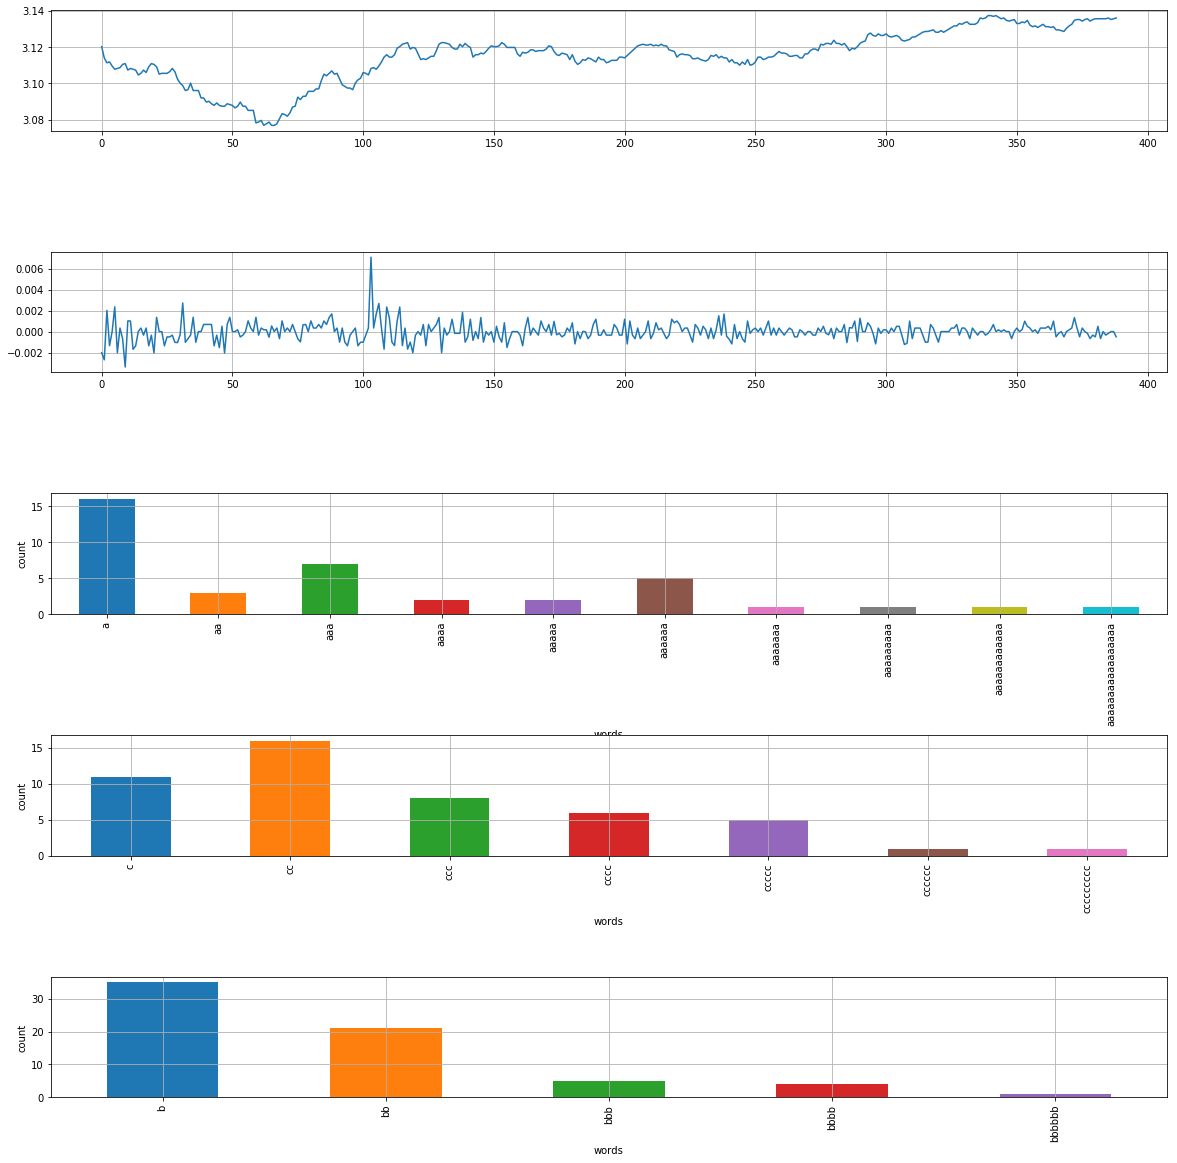

In [815]:
aday='02/3/2016' 
plotcountergraph(env,aday)

['0baaaa', '1accbb', '2bcccb', '3baaaa', '4bbaab', '5bbbbb', '6baaaa', '7aaaaa', '8aaaaa', '9aaaaa', '10ababa', '11abbab', '12baaab', '13bbbbb', '14bcccc', '15ccaaa', '16abbbc', '17cccab', '18bcccc', '19ccaaa', '20bcccc', '21ccccb', '22bbaaa', '23aabcc', '24babaa', '25bcccb', '26ccccc', '27cbaaa', '28aabcb', '29baabc', '30baaab', '31bbaaa', '32bbbcc', '33bbaab', '34ccccc', '35cbaaa', '36bcbaa', '37aaaaa', '38abcca', '39bcbaa', '40bbccc', '41cbbbb', '42bbbbb', '43bcccb', '44aaccc', '45bbccb', '46abccc', '47baaaa', '48bbaaa', '49abccc', '50caabb', '51ccbcc', '52cbaac', '53cbaab', '54babcb', '55abbcb', '56aabaa', '57baaac', '58cbccc', '59ccccc', '60bbcbb', '61aabcc', '62cccbc', '63bbaaa', '64aabcc', '65aaabc', '66bbbcc', '67cbcba', '68bcaaa', '69bbccc', '70aabbc', '71cbbca', '72bbccc', '73bbaaa', '74aaabc', '75cabcc', '76bbbaa', '77aaacc']


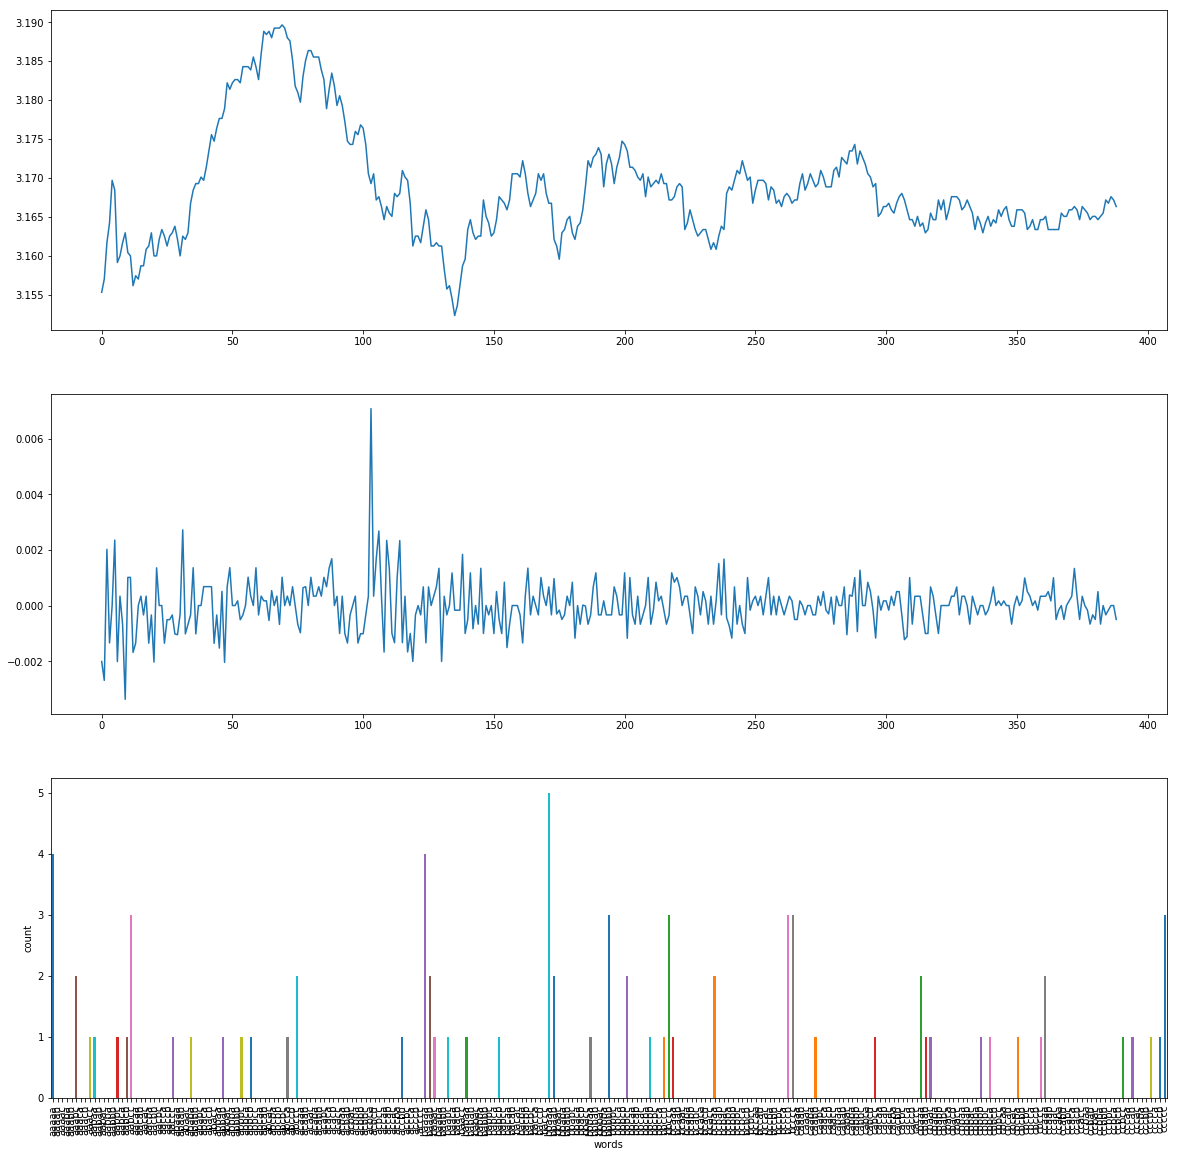

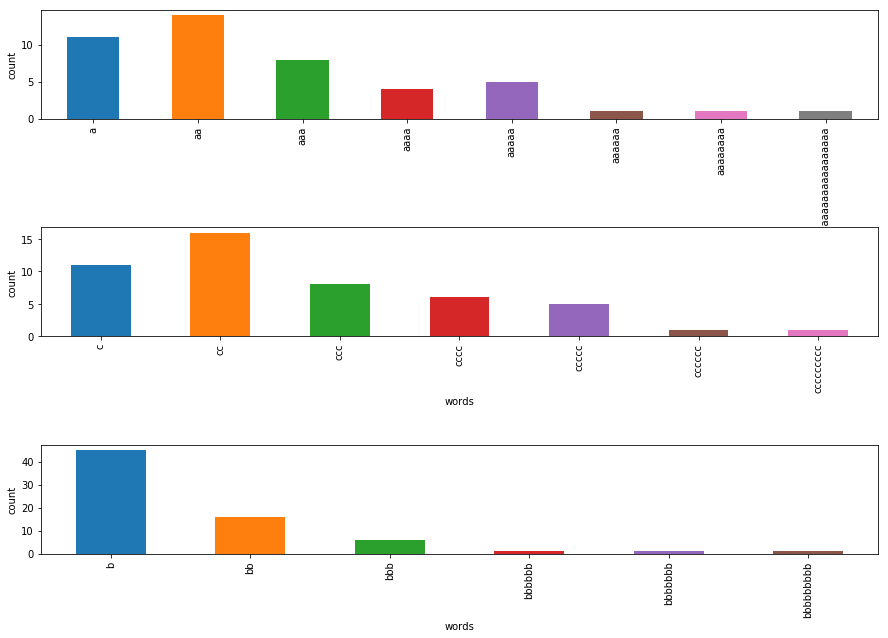

In [751]:
aday='02/4/2016'
plotaday(aday)
plotcountergraph(env,aday)

['0bcbcc', '1ccbaa', '2aacba', '3abcba', '4aaaaa', '5abbba', '6baaab', '7ccccc', '8aaabb', '9abbbb', '10baccc', '11bbccc', '12bbaaa', '13abcba', '14aaaac', '15ccccb', '16abbaa', '17abccc', '18bcccc', '19baaba', '20aaaaa', '21bccca', '22acccc', '23baaab', '24bbccc', '25bcccc', '26cccbb', '27aaaaa', '28abbcc', '29ccbaa', '30bbccc', '31ccccc', '32ccccc', '33bbaaa', '34baaaa', '35bcccc', '36baabc', '37bccba', '38ccccc', '39abbcc', '40cbccc', '41bbaaa', '42bcccb', '43abccc', '44cbccc', '45ccbab', '46baccb', '47abbcc', '48bbbcc', '49cccca', '50aaaab', '51bcccb', '52cbcba', '53aaaaa', '54bccbb', '55cbaac', '56ccccc', '57bbbab', '58baaab', '59bcccc', '60bbbab', '61baaaa', '62aabcc', '63cbbcc', '64cbccc', '65babbc', '66bcbba', '67aabaa', '68aaaab', '69caaaa', '70aaaab', '71aaabb', '72bbbba', '73ccccb', '74aabbb', '75bcccc', '76baaba', '77aaaaa']


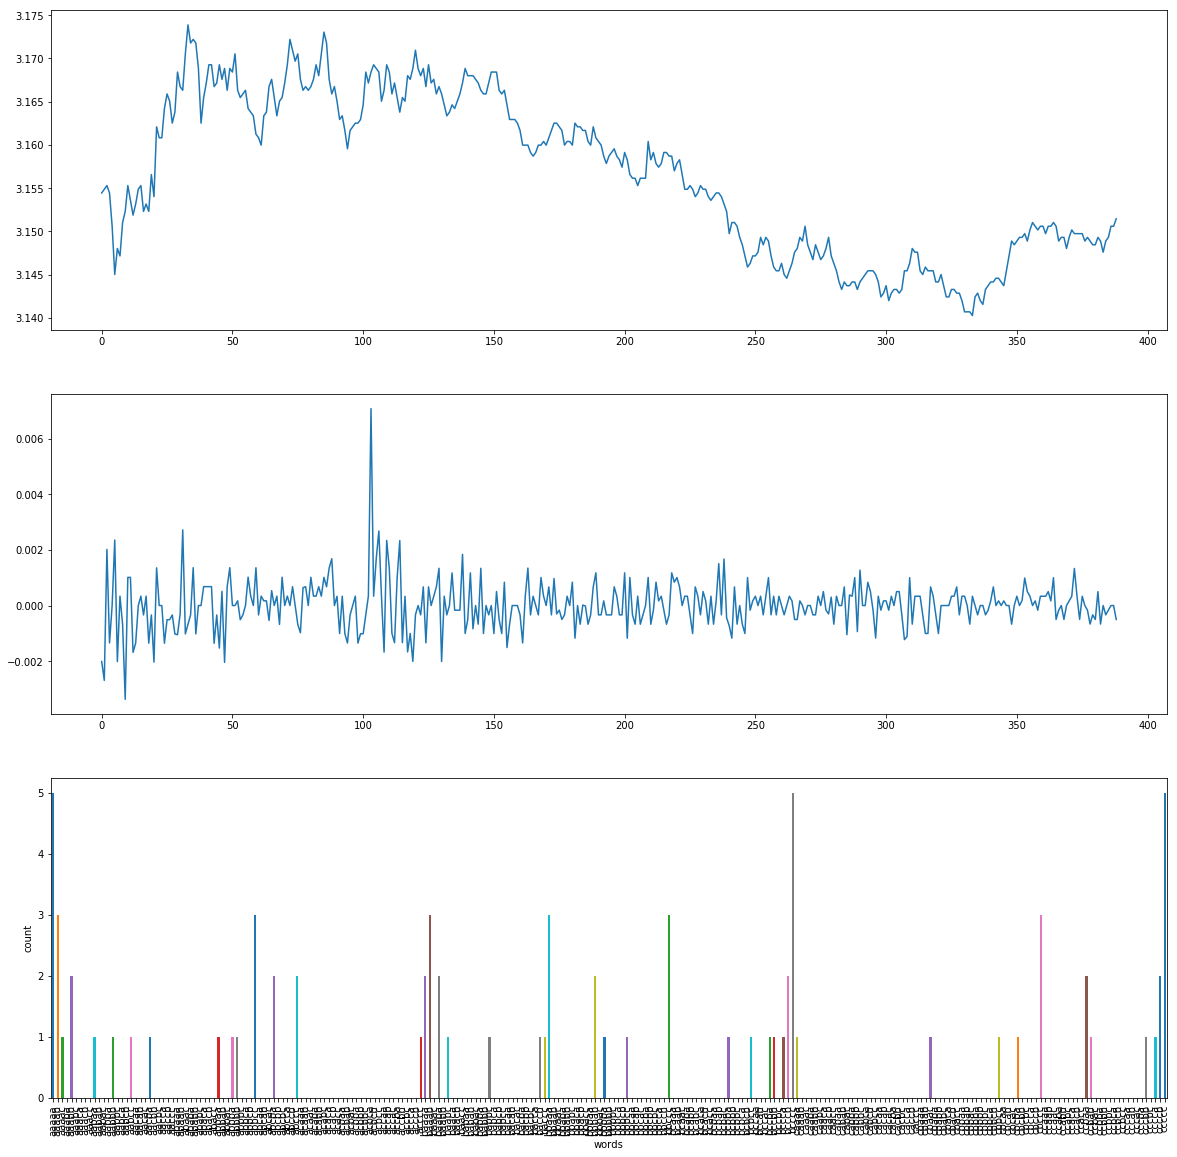

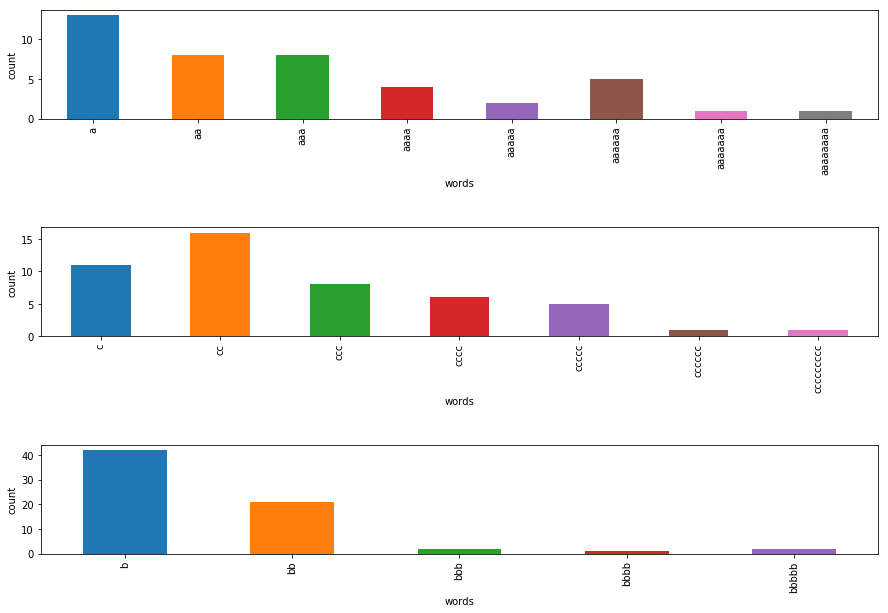

In [752]:
aday='02/5/2016'
plotaday(aday)
plotcountergraph(env,aday)

['0bbbbb', '1ccccc', '2ccccc', '3ccccc', '4ccaab', '5ccccc', '6bcccc', '7cbccc', '8accbc', '9ccacc', '10ccbcc', '11cbbbc', '12bbcbb', '13aaaaa', '14bcbcb', '15bcccc', '16ccccc', '17ccbbb', '18bbacc', '19babbb', '20cabaa', '21baccc', '22ccccc', '23caaab', '24bbabc', '25ccaaa', '26aaabb', '27bbcbb', '28bbaab', '29bcbbb', '30bbbba', '31aaaac', '32cbbaa', '33bbccc', '34caaaa', '35aaabc', '36baabb', '37bcbab', '38bccbb', '39bbbac', '40bbbba', '41ccccc', '42babcc', '43baaab', '44bbbbb', '45cccba', '46aaaab', '47bbabb', '48bbcab', '49cccbb', '50bbaaa', '51accbb', '52ccbbb', '53bbaab', '54bbbbc', '55baaab', '56ccccc', '57ccacc', '58bcccc', '59bcbab', '60bbbbb', '61bcbcc', '62cccbb', '63bbcbb', '64bcaaa', '65aaabb', '66baaba', '67bcccb', '68bbbaa', '69bbccc', '70cccbb', '71bbbbb', '72bbcbb', '73bbccc', '74abbbc', '75aabba', '76abbbb', '77bbbaa']


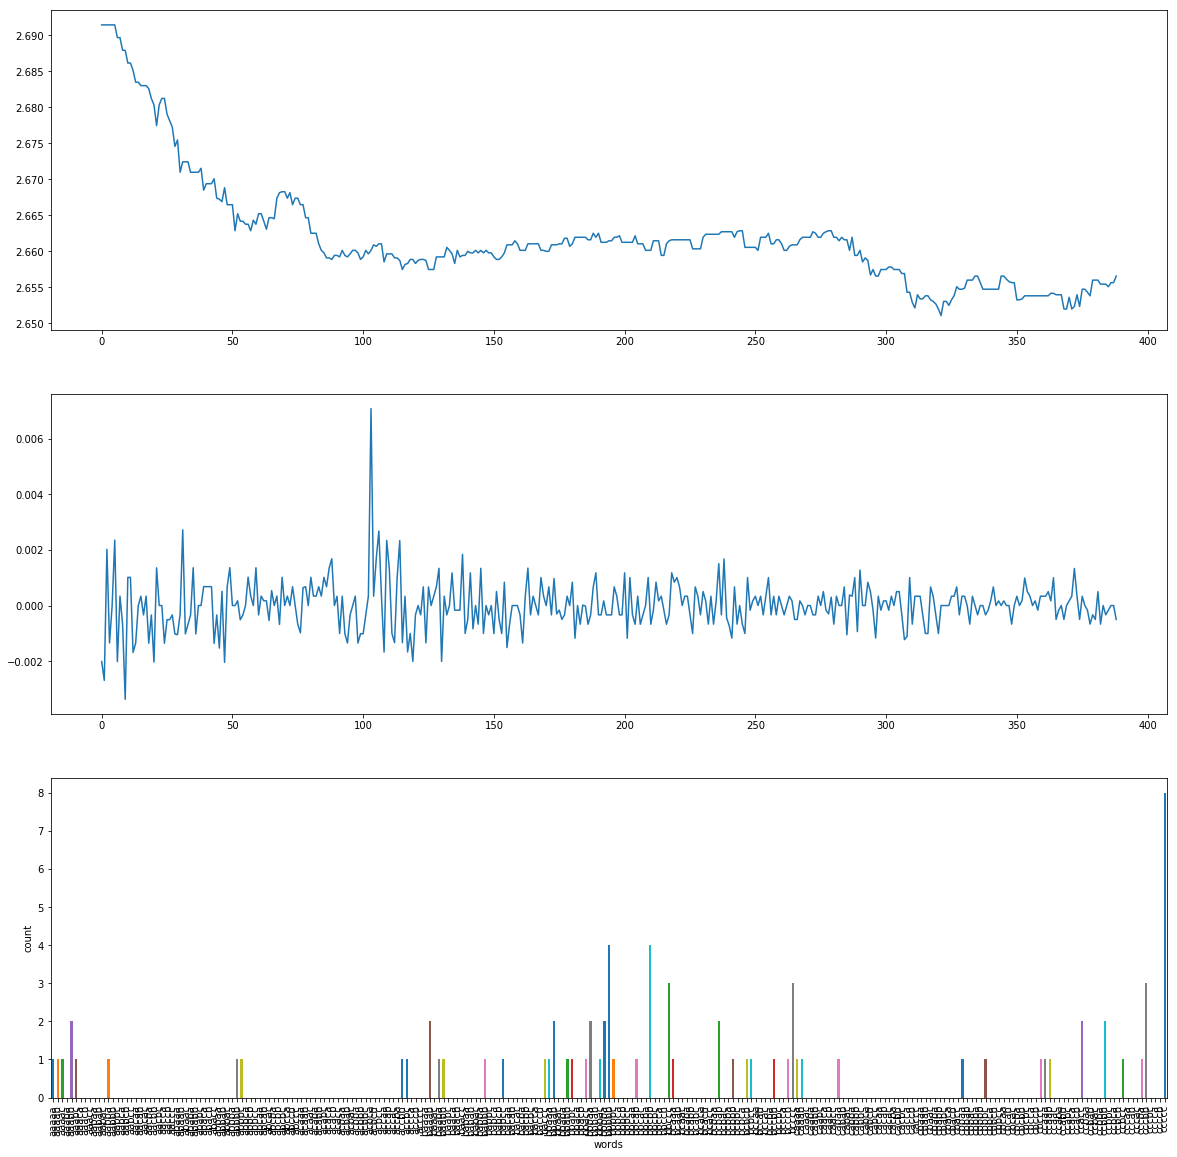

In [676]:
plotcountergraph(env,'03/16/2017')

['0bbbaa', '1aaaaa', '2abbaa', '3bbcbc', '4cccbb', '5bbbbb', '6bcccc', '7ccccc', '8cbcba', '9aacab', '10bbbbb', '11cccbb', '12bbcba', '13aabba', '14cbaaa', '15bbbbb', '16bcccb', '17aaaab', '18baaaa', '19bcabc', '20bbaab', '21babcc', '22cbbbc', '23ccccb', '24bbabb', '25bbbcc', '26bbaaa', '27abccc', '28bbccc', '29bbcbb', '30bccbc', '31aaaaa', '32aaaab', '33bbbcc', '34cccbb', '35babbb', '36bbccc', '37cbbba', '38aabcb', '39bbbcc', '40ccbba', '41bcccc', '42bbabb', '43bbbbb', '44bbbab', '45aaacc', '46ccccc', '47cbccc', '48bcbcc', '49ccccc', '50bbaaa', '51abbbb', '52bbabb', '53bbbbb', '54bbbaa', '55bbbcc', '56ccccc', '57cbbcb', '58bacaa', '59baaab', '60baabb', '61bbabb', '62bbaaa', '63abccc', '64bbbbb', '65bbbbb', '66baabb', '67bbaaa', '68bbbbb', '69cbbba', '70aaaab', '71aaccc', '72baaaa', '73aaabb', '74bcbaa', '75abbcc', '76aabcc', '77ccbbb']


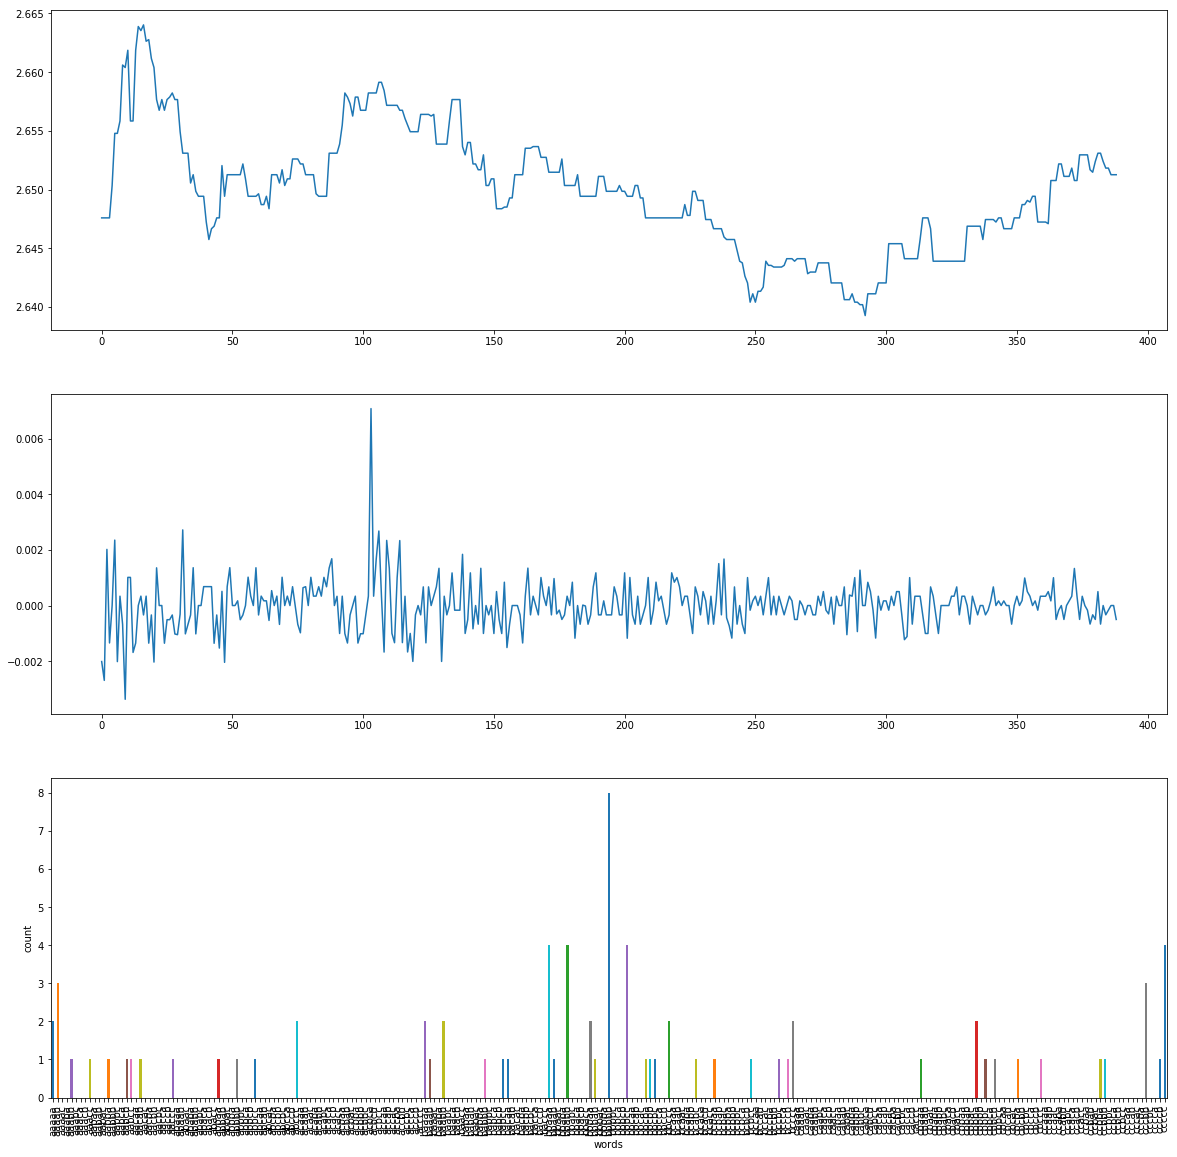

In [677]:
aday='01/08/2003'
plotaday(aday)

['0bbbbb', '1aacbc', '2bccca', '3aabba', '4aaaaa', '5bbaaa', '6bcccb', '7bbbbc', '8ccbaa', '9abbcb', '10ccaaa', '11bbbbb', '12bbccc', '13ccaba', '14aaabb', '15bbbaa', '16abbaa', '17aabba', '18bbbcc', '19cccca', '20aabbb', '21bbaaa', '22bbaab', '23ccbba', '24bbccc', '25ccbbb', '26bbbbb', '27bbabb', '28bbbbb', '29ccccc', '30bcccc', '31cccca', '32baaab', '33bbbba', '34bbabb', '35aabca', '36bbccc', '37baaab', '38bbbbb', '39bbbbb', '40bbbbb', '41bbacb', '42bbbbb', '43bbacc', '44ababc', '45cccbb', '46bbcbb', '47bbabb', '48bbbbb', '49ccccc', '50bbbbb', '51bbbbb', '52bbbbb', '53bbbbb', '54babbb', '55cbaaa', '56aabba', '57abccc', '58bbbbb', '59bbbcc', '60bbaaa', '61bbbcc', '62baaaa', '63bcccb', '64bbbbb', '65bcaaa', '66baaab', '67bbaaa', '68baaab', '69bcccb', '70baaaa', '71acccc', '72bbaaa', '73aaaab', '74bbbcb', '75bbbab', '76cccaa', '77bbaab']


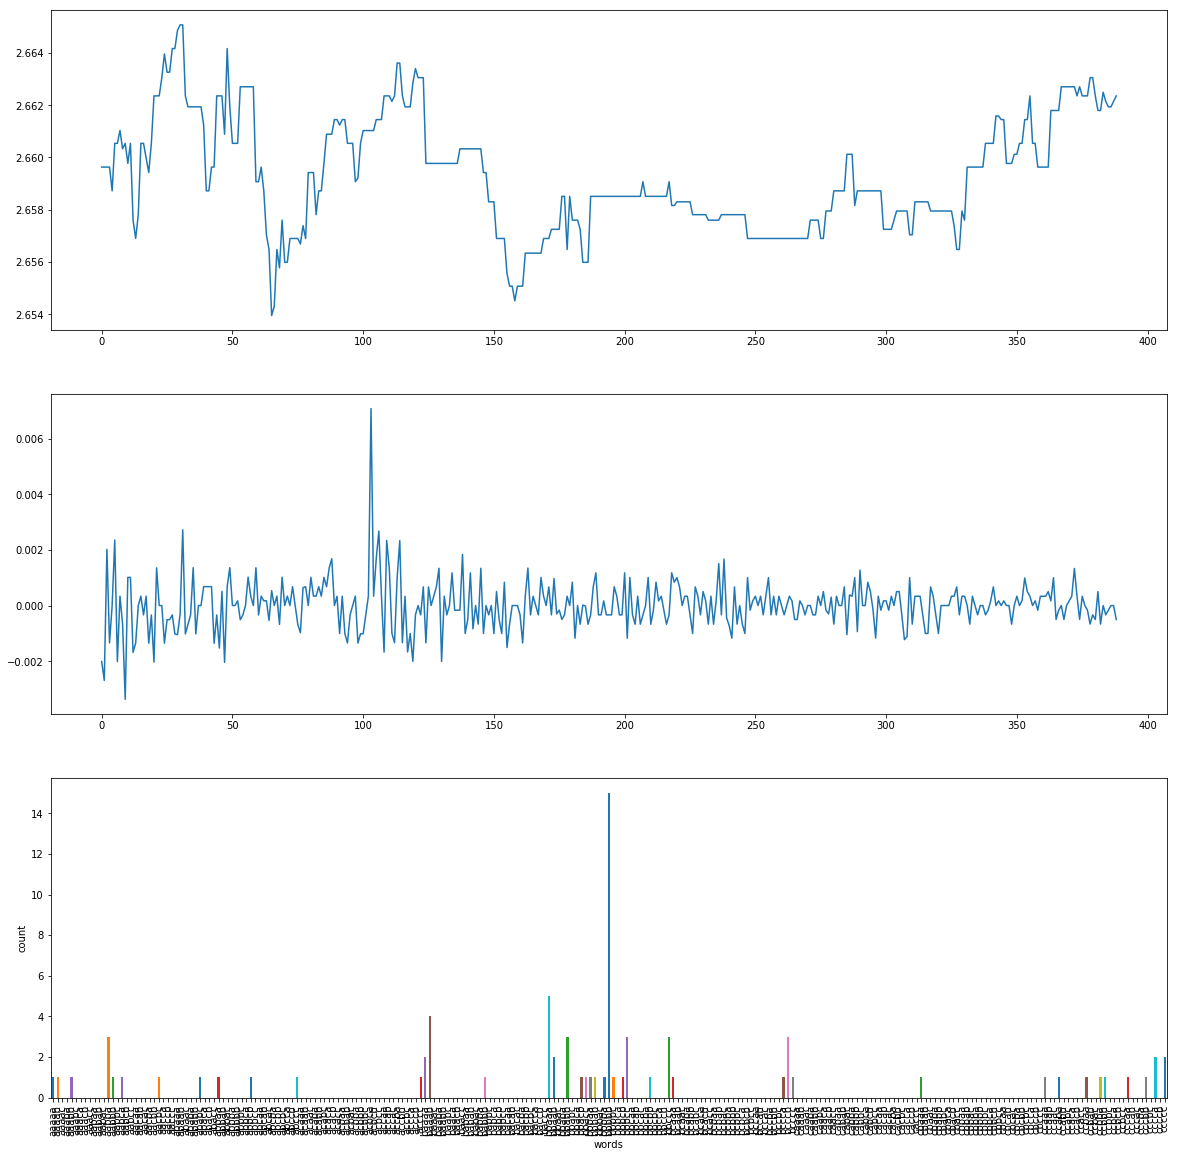

In [678]:
aday='01/09/2003'
plotaday(aday)

['0bbaab', '1bbccb', '2baaac', '3aaacc', '4abbbb', '5aabbb', '6bcccc', '7abccb', '8babbb', '9bbbba', '10aabcb', '11cbbbb', '12bbbbb', '13bbbaa', '14aaaaa', '15abbcc', '16caaaa', '17aaabb', '18bcccc', '19bbaaa', '20abaaa', '21bbccc', '22ccbbc', '23cbaaa', '24bcccb', '25bbaaa', '26aabab', '27acbbb', '28bbbbb', '29cccbb', '30bbbba', '31bbbbb', '32bbbbb', '33baabc', '34cbbaa', '35bccbb', '36bcccb', '37baccc', '38cbccb', '39bbbba', '40bbbbb', '41bbbbb', '42bbcbb', '43bbbba', '44aabbb', '45bcbbc', '46babcc', '47cbaab', '48bbbaa', '49abbba', '50aaaab', '51bbbbb', '52bbbbb', '53bbbbb', '54bccbb', '55bbbbb', '56bbbbb', '57bbbba', '58aaaaa', '59bbbbb', '60bbbbb', '61bbcba', '62aabcc', '63bbbba', '64aaaab', '65bbbbb', '66bbbbb', '67bbbbb', '68cccbb', '69bbbcb', '70babbb', '71ccccc', '72bbaaa', '73bbabb', '74bbccc', '75bbbcc', '76ccccc', '77ccbbb']


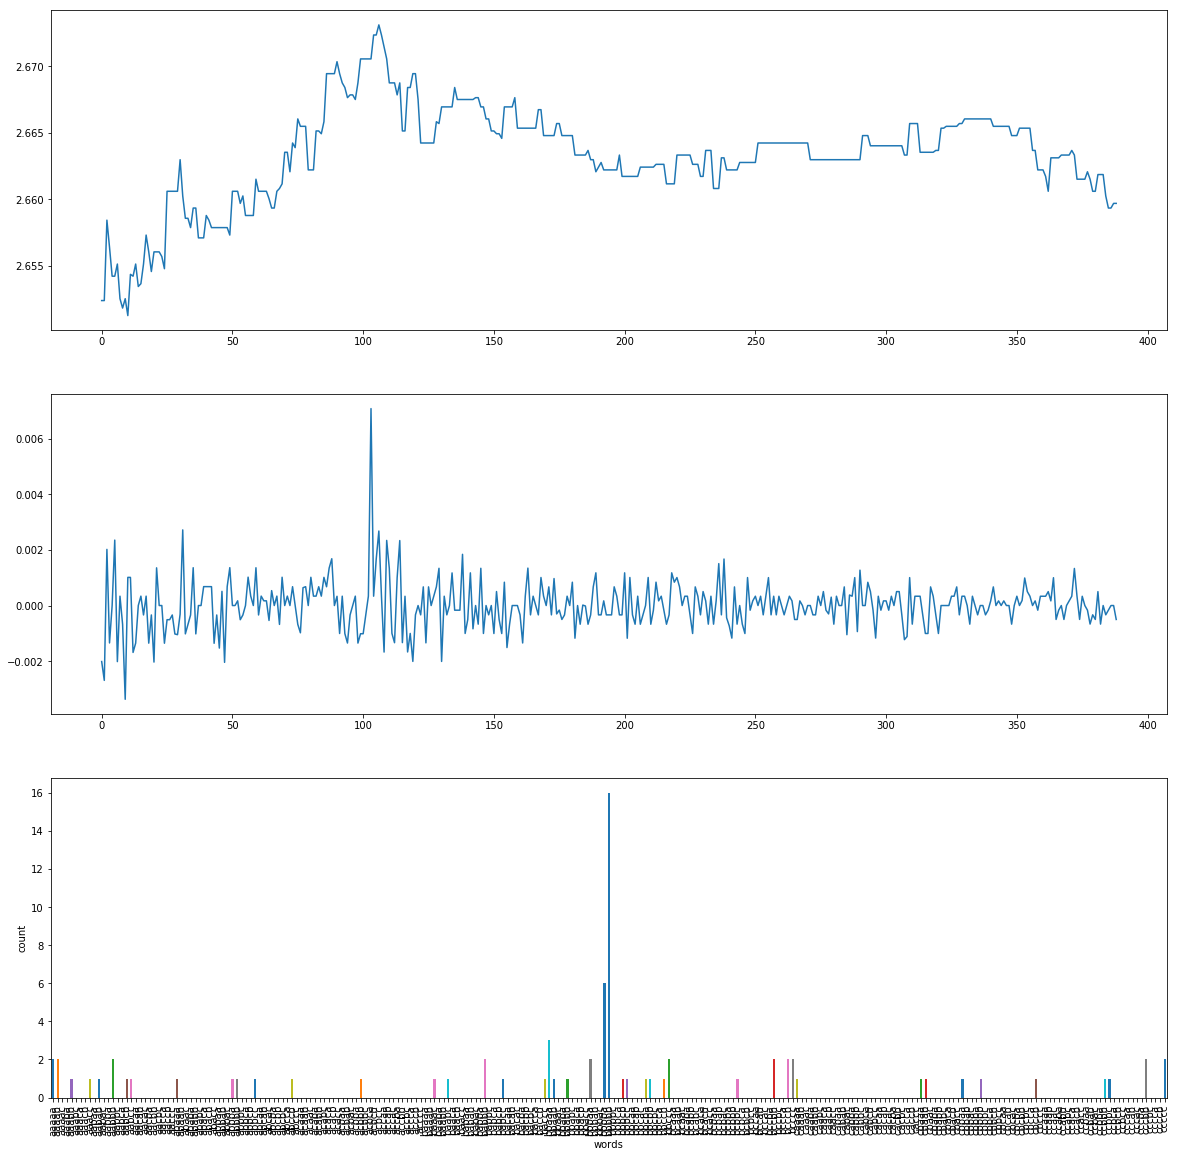

In [679]:
aday='01/10/2003'
plotaday(aday)

['0bbccc', '1ccbba', '2aaabc', '3bbbbc', '4ccccb', '5bbbab', '6bbccb', '7cccaa', '8aaacc', '9bcccb', '10bcbbc', '11ccccb', '12babab', '13ccbcb', '14ccccc', '15aaaab', '16cbbab', '17cccba', '18baaaa', '19bccca', '20abccc', '21cccaa', '22babbb', '23aaaaa', '24bbbaa', '25abaab', '26cccbb', '27aabbb', '28aabba', '29bccbc', '30bacba', '31cccbb', '32baacc', '33ccbbb', '34abbcc', '35baccc', '36bcbaa', '37bcccc', '38bccbb', '39aabba', '40aabcc', '41ccbcc', '42bcccc', '43cccaa', '44cccba', '45aaaab', '46baabc', '47cabac', '48baabb', '49bcccc', '50cbbcc', '51baaaa', '52abbab', '53ccbcc', '54baaaa', '55aaabc', '56cabcc', '57bbbba', '58aaaac', '59ccaaa', '60baaaa', '61ccccb', '62aaaba', '63aaaaa', '64aaaaa', '65abcbc', '66bbccb', '67ccccb', '68aacab', '69ccbcb', '70baaaa', '71abbcc', '72bbbaa', '73aaaaa', '74bbbba', '75bbbaa', '76aaaaa', '77accab']


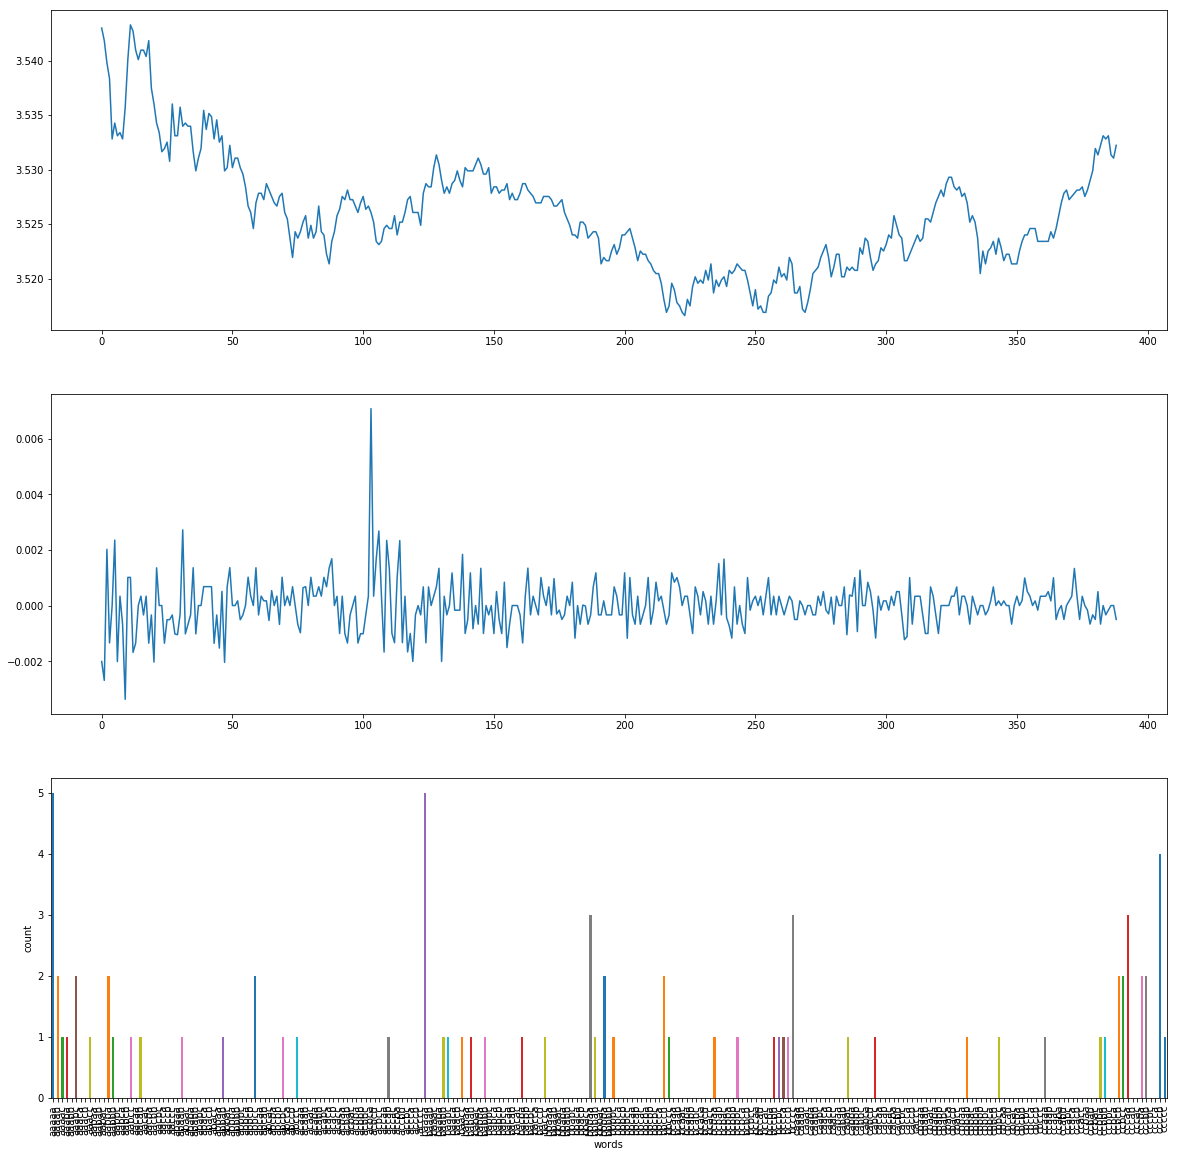

In [680]:
aday='05/10/2010'
plotaday(aday)

['0baacc', '1cbbcc', '2cbccb', '3bbcaa', '4aabcc', '5bbbba', '6bbccc', '7bccbb', '8baaaa', '9bccba', '10aaaab', '11bbccb', '12bccba', '13abaaa', '14accab', '15aaaac', '16cbbcc', '17aaabb', '18baaaa', '19abaab', '20baabc', '21ccbbc', '22cccbb', '23aaaaa', '24bccba', '25baaab', '26aaaba', '27accbc', '28cbaba', '29aaaab', '30baacc', '31baaaa', '32ccccb', '33abbcc', '34caaaa', '35bbbcb', '36baaaa', '37aaaaa', '38ababb', '39aaaaa', '40abcca', '41aabab', '42bbccc', '43bbbbb', '44abcba', '45bcccc', '46baabb', '47cccba', '48baaab', '49cccbb', '50baaaa', '51aaaca', '52bbcbb', '53ccccc', '54babbb', '55ccccc', '56ccccb', '57bcccc', '58aabaa', '59abccc', '60bbcab', '61bbabb', '62caaaa', '63aaaac', '64ccccc', '65ccccb', '66bccaa', '67bcccc', '68bbbab', '69ccccc', '70baaaa', '71abccc', '72bbaaa', '73aabbb', '74cccba', '75acccc', '76bccba', '77aabba']


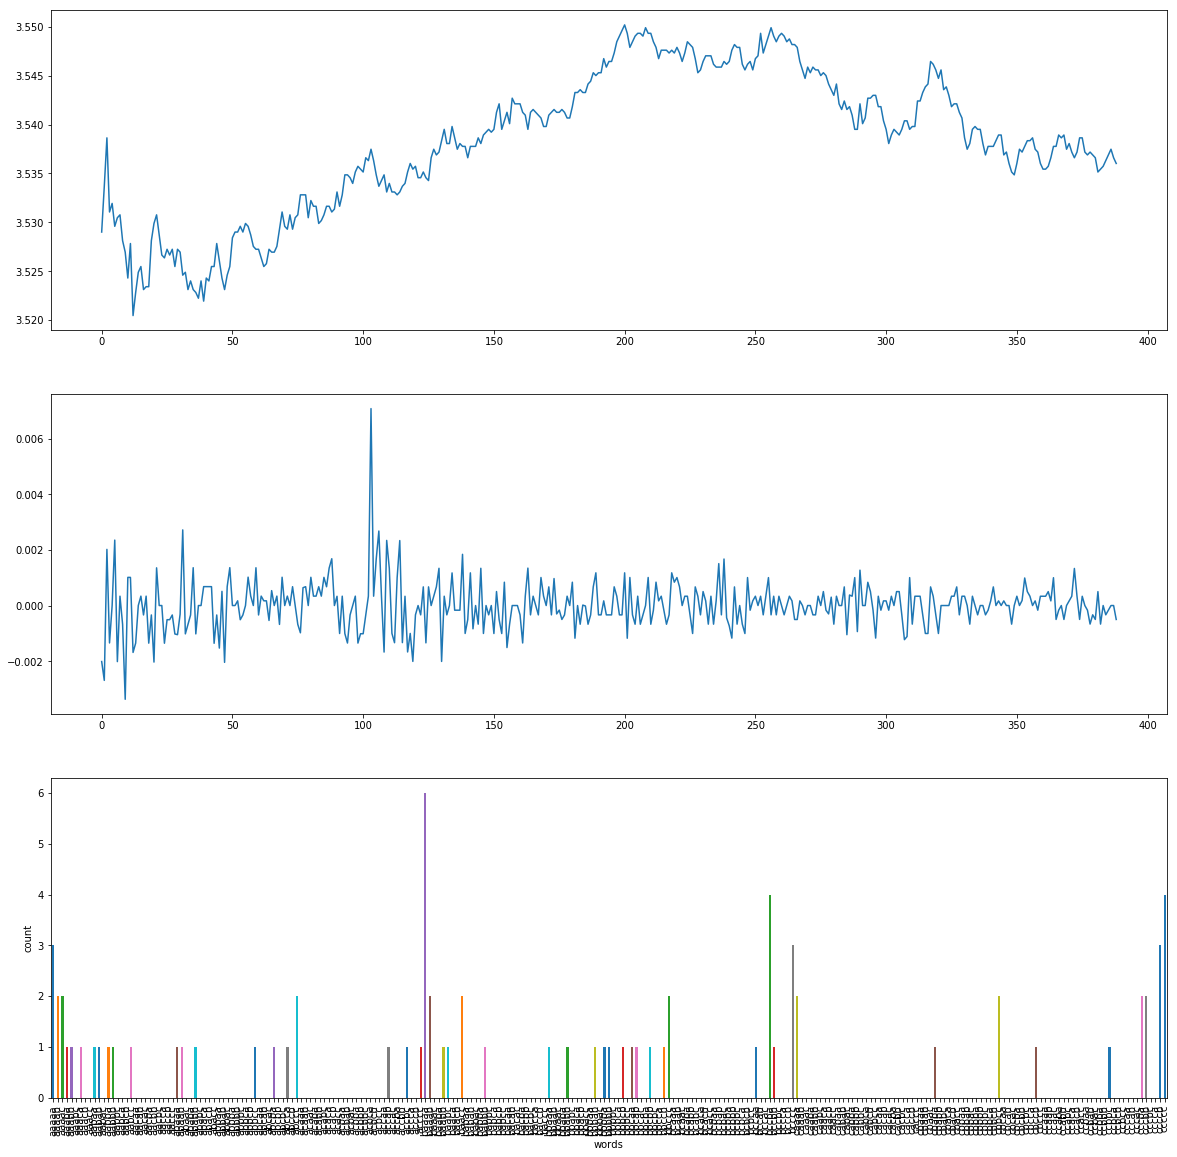

In [681]:
aday='05/11/2010'
plotaday(aday)

['0bbaaa', '1aabbc', '2cccba', '3aabbb', '4cccba', '5aaaab', '6bbaba', '7ccccb', '8bbcba', '9bcccc', '10bbbbb', '11bbaaa', '12bccba', '13bccca', '14aaaaa', '15baabb', '16bcccc', '17cbabb', '18bcccb', '19aaccc', '20ccccc', '21ccccc', '22ccccc', '23baccc', '24babbb', '25abbcb', '26bcccc', '27bcccc', '28baaaa', '29aaaaa', '30bacaa', '31accbb', '32abccb', '33babab', '34ccccc', '35baaaa', '36baccc', '37baaaa', '38aaabb', '39bcaab', '40bcbaa', '41aaaab', '42bccaa', '43bbbcc', '44bbcab', '45ccccc', '46ccccc', '47cbbab', '48bcccc', '49cabcc', '50cccca', '51bbaaa', '52bbcbb', '53aacca', '54bacca', '55aacbb', '56aaaaa', '57aaaba', '58aaaaa', '59aaaaa', '60bcccc', '61ccccb', '62baaab', '63bbbaa', '64acbaa', '65bbaab', '66baabc', '67ccccb', '68ccbbc', '69ccccb', '70aabcb', '71aaabb', '72bcccc', '73cccca', '74babba', '75abaaa', '76baaac', '77cccbb']


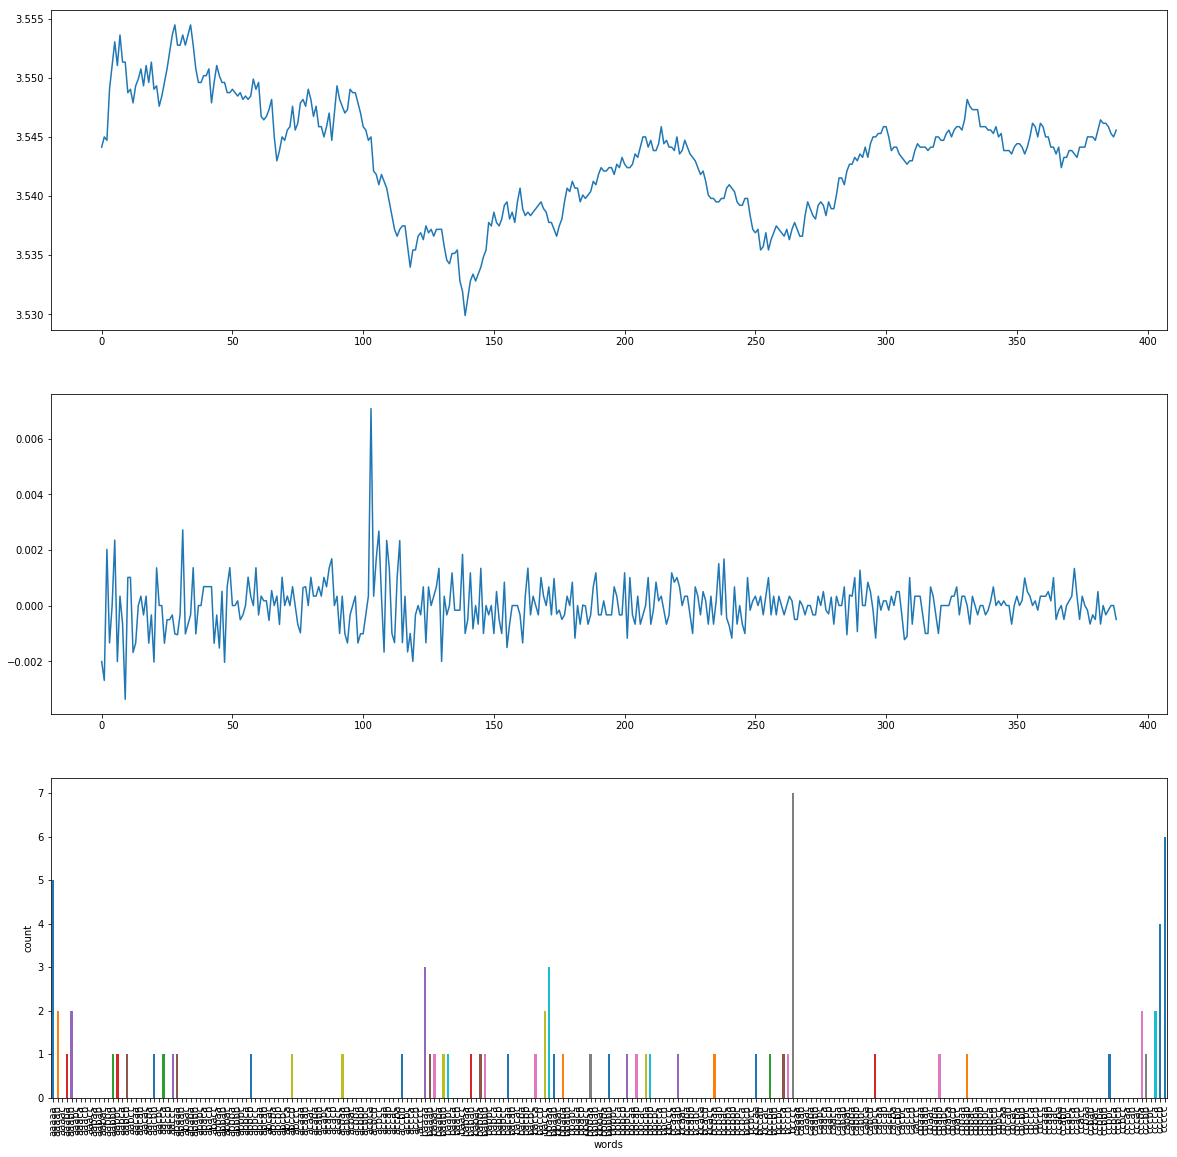

In [682]:
aday='05/12/2010'
plotaday(aday)

['0bcccc', '1cbbba', '2aabcb', '3aaaaa', '4baabc', '5cbbbb', '6babcc', '7cccab', '8bcbaa', '9aaaab', '10aabbb', '11cccbc', '12baaaa', '13aaabc', '14bbccc', '15cccbc', '16cccbb', '17ccccc', '18bbcab', '19aaaab', '20ababb', '21aaabb', '22aaaaa', '23bbccb', '24bbabc', '25ccabc', '26caacb', '27ccbcc', '28ccccb', '29ccccc', '30bcaaa', '31bbbcc', '32aaaac', '33baaaa', '34aaaaa', '35aaaaa', '36bbaaa', '37bccbb', '38aaaba', '39bbbcc', '40ccacb', '41babbc', '42bcaba', '43bbbba', '44aaaaa', '45aaabb', '46cccbc', '47bcccc', '48bacbb', '49aaacc', '50ccccc', '51acaaa', '52ccabb', '53baaaa', '54bbbba', '55aabcc', '56cbccc', '57cccbb', '58cabbc', '59ccccc', '60bbbba', '61abbbb', '62ccccc', '63ccccc', '64cccbc', '65bbbab', '66bbbbb', '67ccbcc', '68ccccc', '69cccbb', '70aaaaa', '71bccba', '72bcccc', '73ccccc', '74ccaba', '75aaaaa', '76aaccc', '77ccbcc']


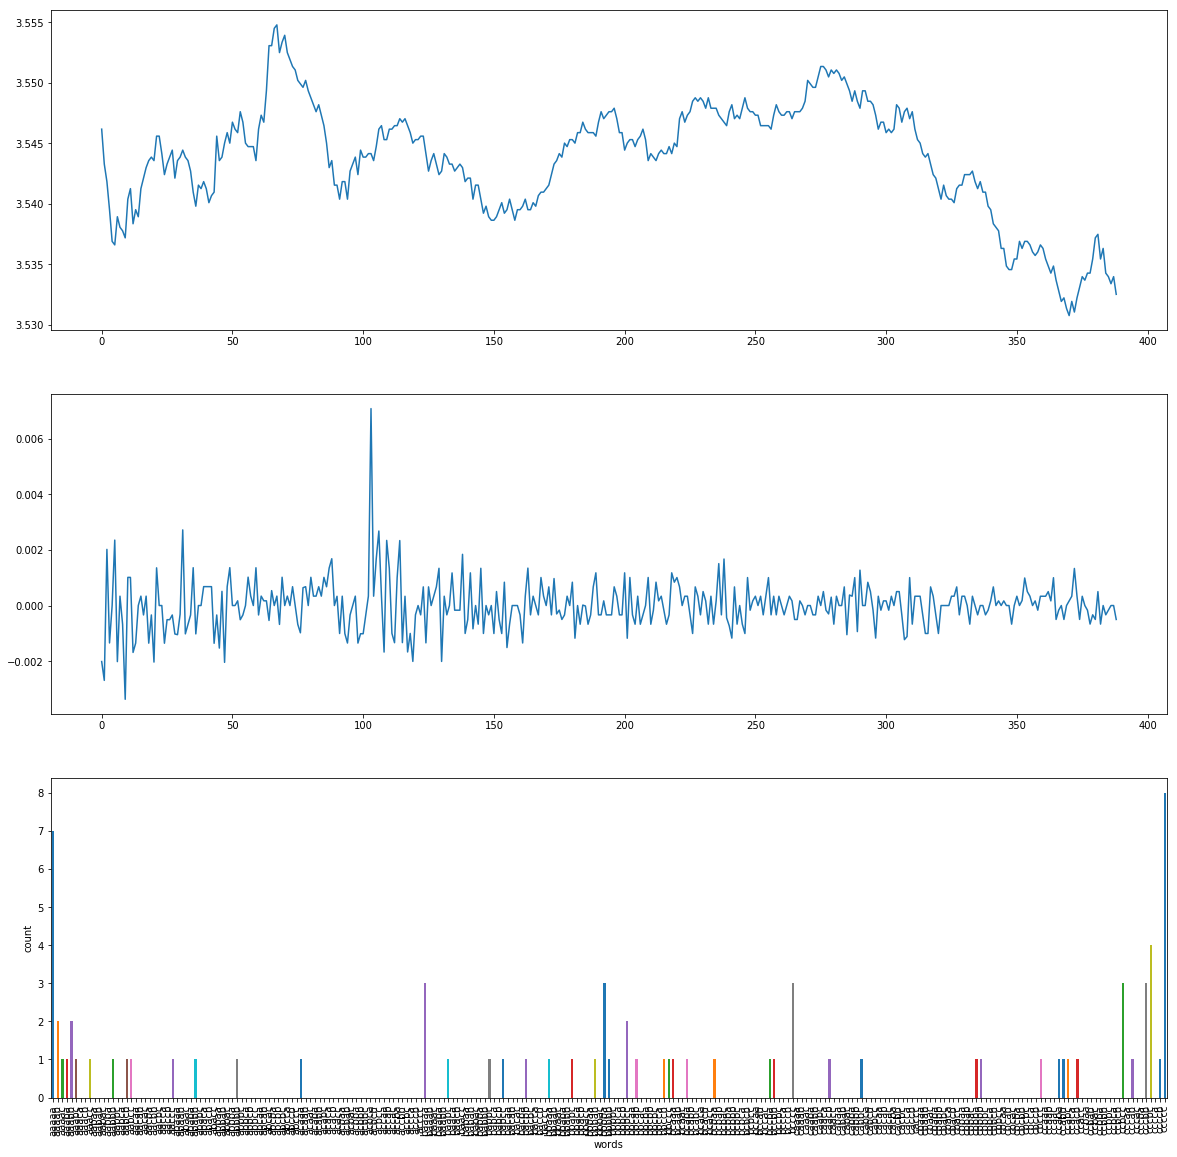

In [683]:
aday='05/13/2010'
plotaday(aday)

['0babcc', '1ccccc', '2ccbab', '3bbaba', '4aaabb', '5bbbcc', '6bcccc', '7bbaaa', '8bbbaa', '9bcccb', '10aaaaa', '11bbccb', '12bcccc', '13babcb', '14aabcc', '15baaab', '16bcbab', '17ccccb', '18bcccb', '19ccbcc', '20bbaab', '21ccccc', '22ccbaa', '23abbba', '24bcccc', '25bcccc', '26cbaaa', '27cccbc', '28ccbaa', '29accbb', '30bccbb', '31bccba', '32abbbb', '33cbaaa', '34baaaa', '35cccca', '36bbabb', '37bbaaa', '38aaccc', '39cbbba', '40bbaaa', '41bbbaa', '42bcccc', '43cccbb', '44aaccc', '45ccccb', '46aaabb', '47cbcbc', '48bccbb', '49abcbb', '50babaa', '51babcc', '52caaab', '53aaabb', '54bcccc', '55bbccc', '56ccaac', '57ccbaa', '58baabb', '59aaaab', '60bcbba', '61aaaab', '62cccba', '63abaab', '64ccccb', '65bbcbc', '66baaaa', '67abaaa', '68acccc', '69ccccb', '70bccaa', '71aacba', '72baabc', '73cbbaa', '74aaaaa', '75aaaaa', '76aaaaa', '77cbaaa']


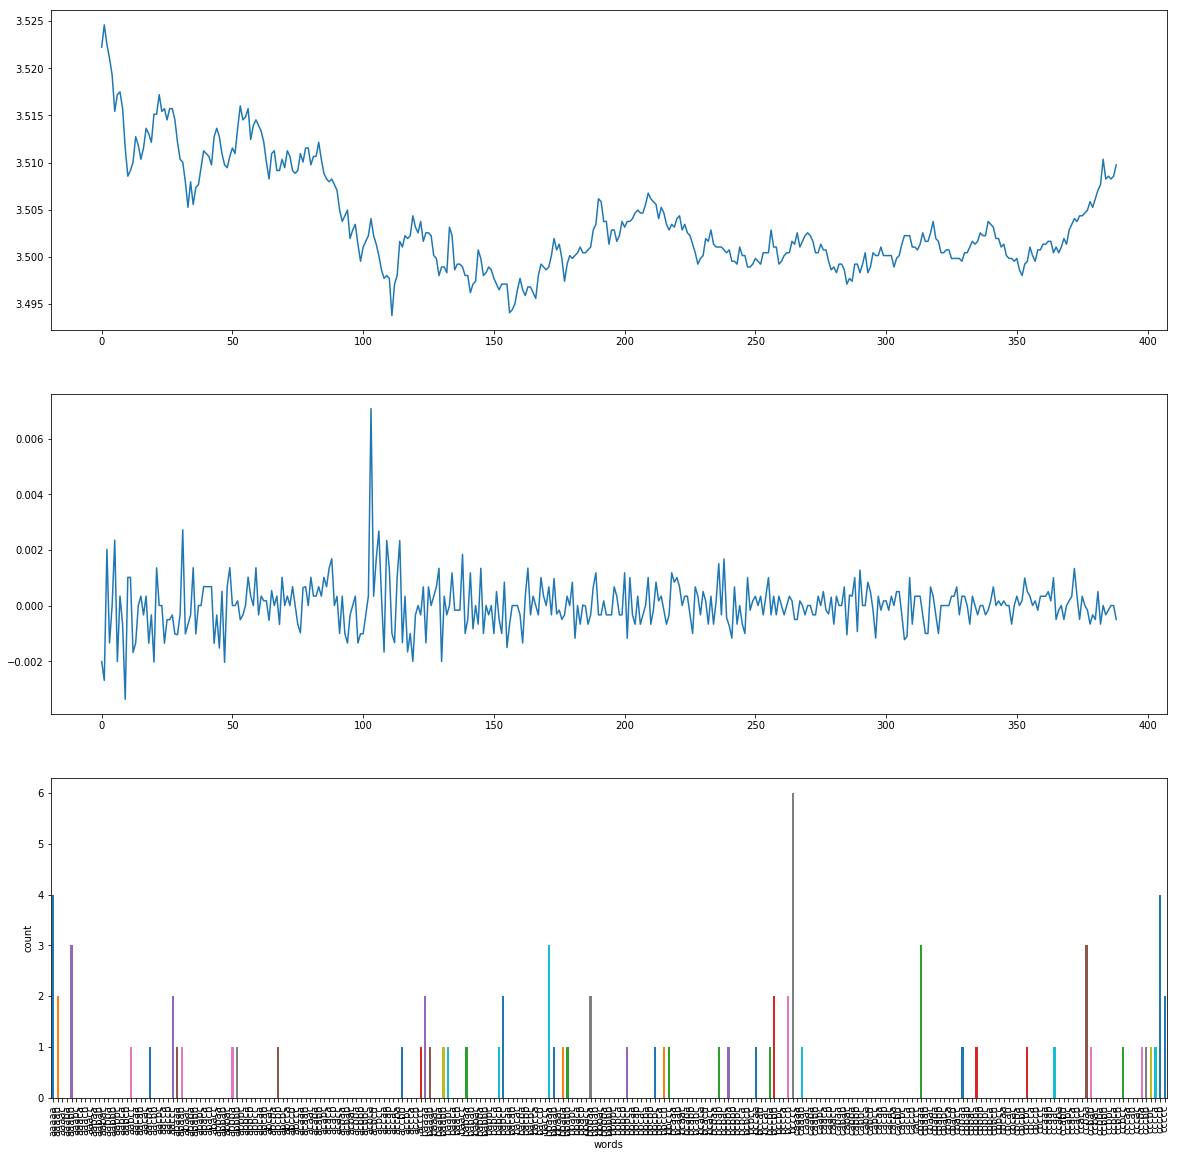

In [684]:
aday='05/14/2010'
plotaday(aday)

['0babbb', '1cbabb', '2aaccc', '3ccccb', '4cccbb', '5bbccb', '6baaaa', '7bbaba', '8aaabb', '9aaabc', '10cccbb', '11baaab', '12bbccc', '13cbabc', '14cbccc', '15cccbb', '16cabcc', '17cbbaa', '18bbbab', '19bcccc', '20cbbbc', '21ccccc', '22ccbab', '23cbbaa', '24bcbaa', '25bbcbc', '26cbaaa', '27aaabb', '28aaaaa', '29cccaa', '30baaaa', '31bccca', '32aabbc', '33caaaa', '34abbab', '35bccbb', '36bcccc', '37bbbaa', '38aaaab', '39cbaaa', '40bccbb', '41bbaaa', '42baacc', '43ccccc', '44ccbaa', '45accba', '46cbaba', '47cccbb', '48bcbaa', '49aaaab', '50bbbab', '51bcccc', '52ccccc', '53ccbab', '54bccbc', '55ccccc', '56cccbb', '57bbaab', '58cbaba', '59aacbb', '60bbbaa', '61accbc', '62cbccc', '63ccbcb', '64aaaab', '65cbbba', '66baaab', '67aaaaa', '68babbc', '69bcbbc', '70ccbcc', '71ccaaa', '72bbbbc', '73cccba', '74aaaaa', '75aaabb', '76cbbaa', '77aaaaa']


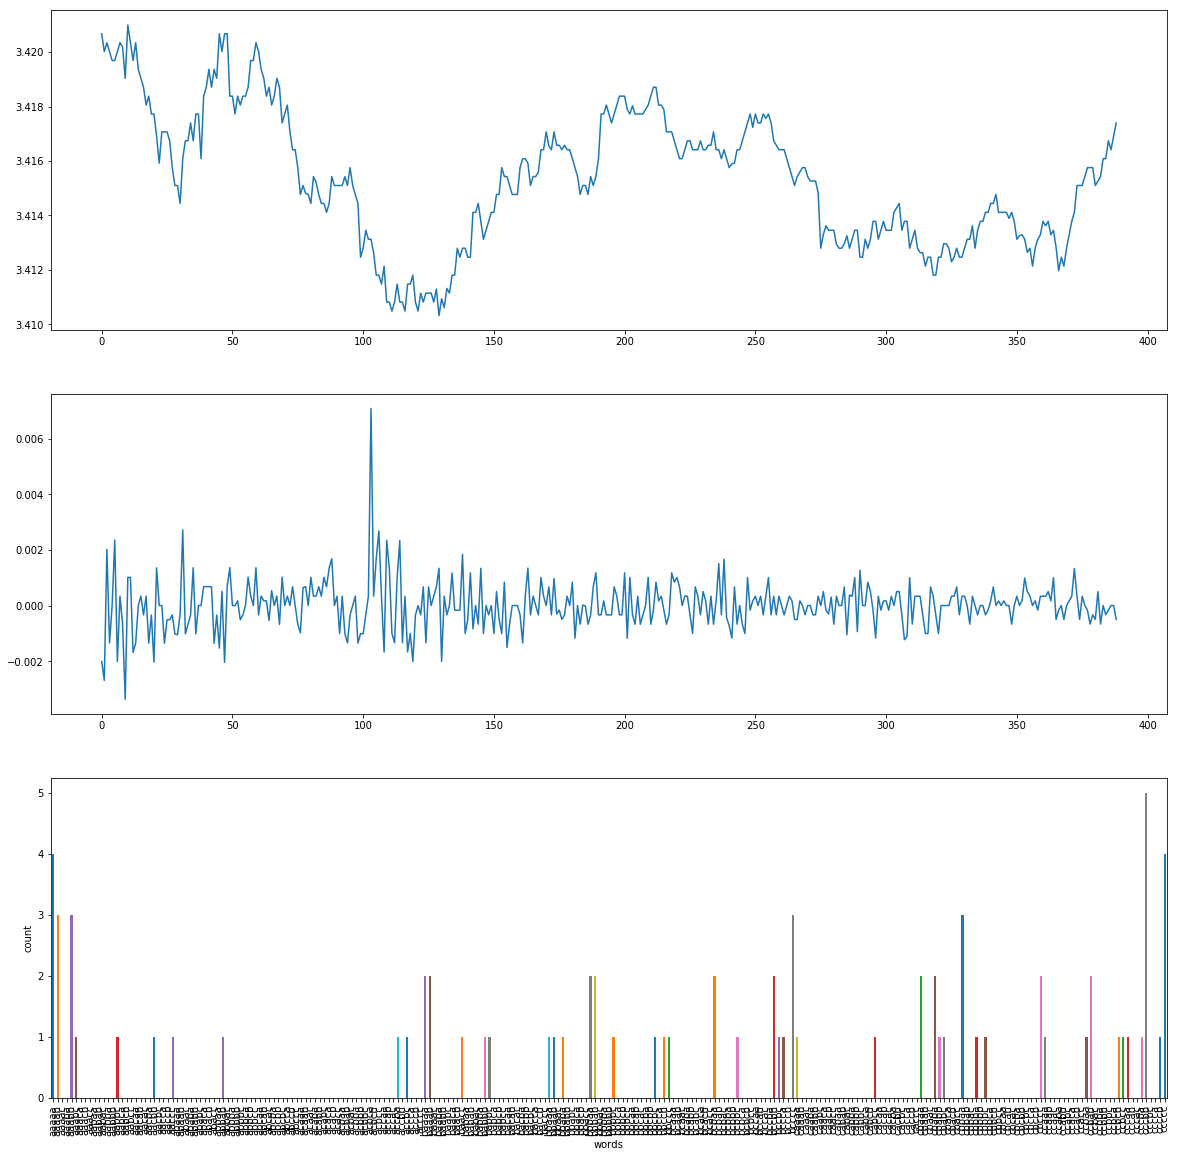

In [685]:

aday='03/13/2017'
plotaday(aday)

In [7]:
from pykalman import KalmanFilter



In [383]:
#print(env.df[env.df['sdate'].str.match(str.encode('03/13/2017'))])
dt=np.datetime64(datetime.strptime('03/13/2017','%m/%d/%Y'))
 
i=np.where(env.dates ==dt)[0][0]
print(i)

3761


In [561]:
a=['a','b','c']
dic=[]
for i in range(3):
    for j in range(3):
        for k in range(3):
            for m in range(3):
                for n in range(3):
                    w = a[i]+a[j]+a[k]+a[m]+a[n]
                    dic.append(w)
 
import collections
c= collections.Counter(dic) 
cntr= collections.Counter({x:0 for x in c})
print(cntr)  

Counter({'aaaaa': 0, 'aaaab': 0, 'aaaac': 0, 'aaaba': 0, 'aaabb': 0, 'aaabc': 0, 'aaaca': 0, 'aaacb': 0, 'aaacc': 0, 'aabaa': 0, 'aabab': 0, 'aabac': 0, 'aabba': 0, 'aabbb': 0, 'aabbc': 0, 'aabca': 0, 'aabcb': 0, 'aabcc': 0, 'aacaa': 0, 'aacab': 0, 'aacac': 0, 'aacba': 0, 'aacbb': 0, 'aacbc': 0, 'aacca': 0, 'aaccb': 0, 'aaccc': 0, 'abaaa': 0, 'abaab': 0, 'abaac': 0, 'ababa': 0, 'ababb': 0, 'ababc': 0, 'abaca': 0, 'abacb': 0, 'abacc': 0, 'abbaa': 0, 'abbab': 0, 'abbac': 0, 'abbba': 0, 'abbbb': 0, 'abbbc': 0, 'abbca': 0, 'abbcb': 0, 'abbcc': 0, 'abcaa': 0, 'abcab': 0, 'abcac': 0, 'abcba': 0, 'abcbb': 0, 'abcbc': 0, 'abcca': 0, 'abccb': 0, 'abccc': 0, 'acaaa': 0, 'acaab': 0, 'acaac': 0, 'acaba': 0, 'acabb': 0, 'acabc': 0, 'acaca': 0, 'acacb': 0, 'acacc': 0, 'acbaa': 0, 'acbab': 0, 'acbac': 0, 'acbba': 0, 'acbbb': 0, 'acbbc': 0, 'acbca': 0, 'acbcb': 0, 'acbcc': 0, 'accaa': 0, 'accab': 0, 'accac': 0, 'accba': 0, 'accbb': 0, 'accbc': 0, 'accca': 0, 'acccb': 0, 'acccc': 0, 'baaaa': 0, 'baaab'

In [688]:
x=0
min1 = 3
min2 = 3

max1 = 6
max2 = 6
for i in range(min1,max1+1):
    for j in range (min2,max2+1):
        for k in range(min1,i+1):
            for l in range(min2,j+1):
                for m in range (min1,i+1):
                    for n in range (min2,j+1):
                        x +=1
print(x)


900


In [791]:
docs=[]
for d in pd.Series(env.dates):
    data, sax,c2 = env.ConvertAdaytoSAXwords(aday)
    docs.append(' '.join(sax))
print(len(docs))

4072


In [793]:
print(len(docs))

4072


In [794]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
 
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(docs)

true_k = 2
model = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=1)
model.fit(X)

print("Top terms per cluster:")
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
for i in range(true_k):
    print("Cluster %d:" % i),
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind]),
    print



Top terms per cluster:
Cluster 0:
 cccccaaaab
 abbabccbcc
 baabbbcccc
 baaaaccccb
 baaaabccca
 baaaaabbcc
 baaaaaaabc
 abccccccaa
 abbccbaccc
 aacabccbcb
Cluster 1:
 cccccaaaab
 abbabccbcc
 baabbbcccc
 baaaaccccb
 baaaabccca
 baaaaabbcc
 baaaaaaabc
 abccccccaa
 abbccbaccc
 aacabccbcb


/Users/wweschen/rl-trader/venv/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:968: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)


In [772]:
X

<4072x50 sparse matrix of type '<class 'numpy.float64'>'
	with 203600 stored elements in Compressed Sparse Row format>

In [ ]:
print("\n")
print("Prediction")

Y = vectorizer.transform(["chrome browser to open."])
prediction = model.predict(Y)
print(prediction)

Y = vectorizer.transform(["what are you doing?"])
prediction = model.predict(Y)
print(prediction)

In [118]:
def test_stationarity(timeseries): 
    # rolling stats
    from statsmodels.tsa.stattools import adfuller
    rolmean = timeseries.roll+1ing(window=30).mean()
    rolstd = timeseries.rolling(window=30).std()
    
    #plot 
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # dickey fuller
    print("Results of Dickey Fuller Test: ")
    dftest = adfuller(timeseries, autolag = "AIC")
    dfoutput = pd.Series(dftest[0:4], index=["Test Statistic", "p-value", "#Lags Used", "Number of Observations Used"])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [316]:
from string import ascii_lowercase
s = 'AabC'
s = s.lower()
print(sum(1 for c in  ascii_lowercase if s.count(c) == 1))

2


In [322]:
a= np.array(' a  a  a  b  a  a  a  a  a  a  a  a  a  b  a '.split())
 
b=a[::-1]
insig=''.join(b[0:4])
if insig.count('c')==0:
    print('buy')
if insig.count('a')==0:
    print('sell')






buy


[ 0.36837911 -0.08048537 -0.13006103 -0.82440278 -1.32582606 -0.96872413
 -1.61583496 -0.33468267  1.04708462  1.58440388  1.94708062  1.88091202
  2.06190952  1.71085517  0.75230531  1.21404248  1.05666751  0.17000374
 -0.09768252 -0.88999033 -0.29765095  0.39947492  1.17977076  1.22185296
  1.20970331  0.89572457  0.60579378  1.42798734  0.42845737]
  b-28  b-27  b-26  c-25  c-24  c-23  c-22  b-21  a-20  a-19  a-18  a-17  a-16  a-15  a-14  a-13  a-12  b-11  b-10  c -9  b -8  b -7  a -6  a -5  a -4  a -3  a -2  a -1  b  0


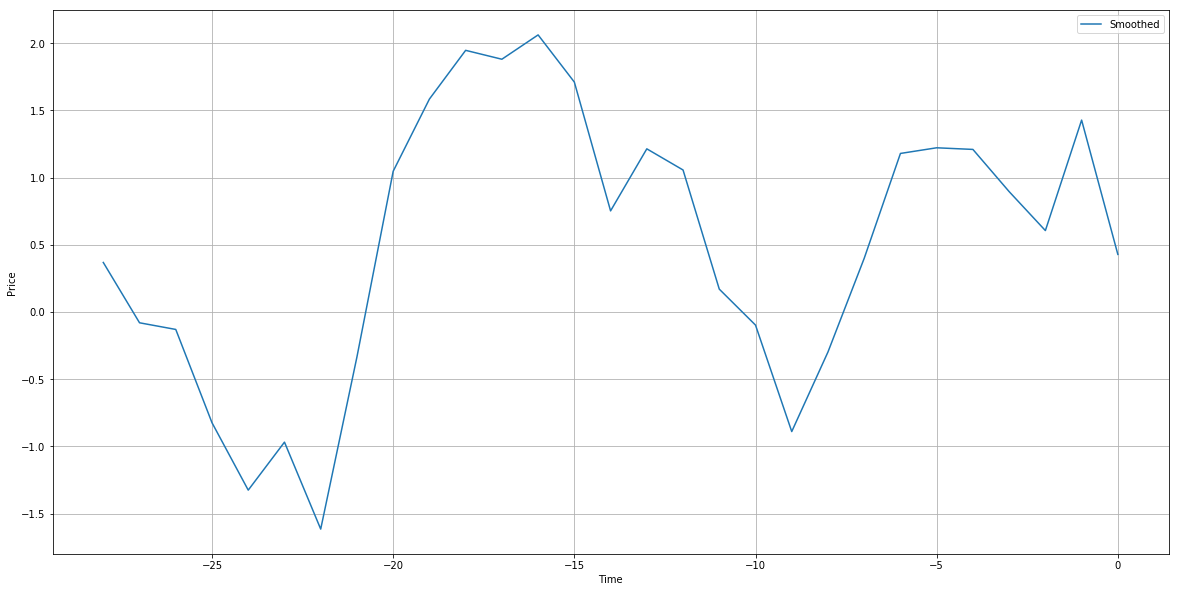

In [478]:
from pykalman import KalmanFilter
from statsmodels.tsa.stattools import adfuller
n=30
 

d0=np.log(np.array([env.data.get_t_data(-i)[2:6] for i in range(  n)]))
d=np.log(np.array([env.data.get_t_data(-i)[2:6] for i in range(n)]))
mean=d.mean()
kf = KalmanFilter(em_vars=['transition_covariance', 'observation_covariance'],initial_state_mean = mean, n_dim_obs=4)
v= kf.em(d0)
 
h=v.smooth(d)
#print(d[:,0])
#print(np.diff(d[:,0].flatten()))
#print(norm_it(d[:,0]))
def norm_it(d):
    x=d.flatten()
    x=x[::-1]
    x=np.diff(x)
    s=x.std()
    x=x/s
    #x=np.diff(x)
    return x #/ np.linalg.norm(x)
  
s=norm_it(h[0][-n:])
print(s)
o=''    
o1=''
for i in range(len(s)):
    if s[i]>0.43:
          o=o+'  a'+'{:3d}'.format(i-n+2)
    elif s[i]<-.43:
          o=o+'  c' +'{:3d}'.format(i-n+2)
    else:
          o=o+'  b' +'{:3d}'.format(i-n+2)
print(o)        
plt.figure(figsize=(20,10))
# Plot results
times = [i-n+2 for i in np.arange(n-1)]
plt.plot(times, norm_it(h[0][-n:]))
#plt.plot(times,norm_it(d[:,0]))
#plt.plot(times,norm_it(d[:,1])) 
#plt.plot(times, norm_it(d[:,2]) )
#plt.plot(times, norm_it(d[:,3]) )
plt.legend(['Smoothed', 'open','high','low','close'])
plt.xlabel('Time')
plt.ylabel('Price')
plt.grid() 
plt.show()

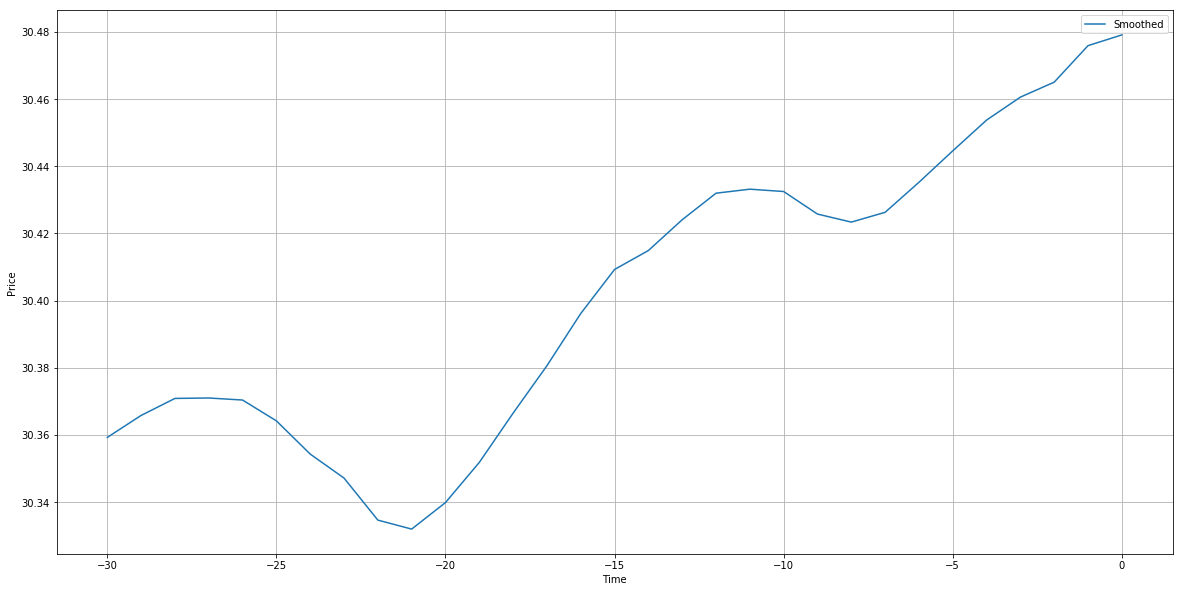

In [480]:
from pykalman import KalmanFilter
from statsmodels.tsa.stattools import adfuller
n=31
# for i in range(20):
#     env.step(0)
d0= (np.array([env.data.get_t_data(-i)[2:6] for i in range(  n)]))
d= (np.array([env.data.get_t_data(-i)[2:6] for i in range(n)]))
mean=d.mean()
kf = KalmanFilter(em_vars=['transition_covariance', 'observation_covariance'],initial_state_mean = mean, n_dim_obs=4)
v= kf.em(d0)
 
h=v.smooth(d)
#print(d[:,0])
#print(np.diff(d[:,0].flatten()))
#print(norm_it(d[:,0]))
def norm_it(d):
    x=d.flatten()
    #x=np.diff(x)
    #x=np.diff(x)
    #x=np.diff(x)
    return x #/ np.linalg.norm(x)
  
plt.figure(figsize=(20,10))
# Plot results
times = [-i for i in np.arange(n)]
plt.plot(times, norm_it(h[0][-n:]))
#plt.plot(times,norm_it(d[:,0]))
#plt.plot(times,norm_it(d[:,1])) 
#plt.plot(times, norm_it(d[:,2]) )
#plt.plot(times, norm_it(d[:,3]) )
plt.legend(['Smoothed', 'open','high','low','close'])
plt.xlabel('Time')
plt.ylabel('Price')
plt.grid()

plt.show()

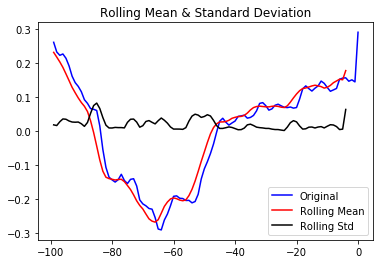

Results of Dickey Fuller Test: 


KeyError: 1

In [141]:
from statsmodels.tsa.arima_model import ARIMA
import pandas as pd
n=100
nh= h[0].flatten()
mean=nh.mean()
nh=nh-mean

data=[ [-i,nh[-i]] for i in np.arange(n)]
 
times = [-i for i in np.arange(n)]
df=pd.DataFrame(data=data,columns=['steps','prices'])
df=df.set_index('steps')
timeseries=df

rolmean = timeseries.rolling(window=5).mean()
rolstd = timeseries.rolling(window=5).std()

orig = plt.plot(timeseries, color='blue',label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

# dickey fuller
print("Results of Dickey Fuller Test: ")
dftest = adfuller(timeseries[1], autolag = "AIC")
dfoutput = pd.Series(dftest[0:4], index=["Test Statistic", "p-value", "#Lags Used", "Number of Observations Used"])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)
#test_stationarity(df)
# model = ARIMA(nh, order=(1,0,1))
# model_fit = model.fit(disp=0)
# start_index=len(nh)
# end_index=len(nh)
# forecast = model_fit.predict(start=start_index, end=end_index)
# plt.figure(figsize=(10,5))
# Plot results

# plt.plot(times, nh) 
# plt.plot(times,d[:,1][-n:])
# plt.plot(times,d[:,2][-n:])
# plt.plot(times,d[:,3][-n:])
# plt.legend(['Smoothed', 'open','high','low','close'])
# plt.xlabel('Time')
# plt.ylabel('Price')

In [179]:
import numpy as np
from sklearn.preprocessing import normalize

x = np.random.rand(100)*10
norm1 = x / np.linalg.norm(x)
norm2 = normalize(x[:,np.newaxis], axis=0).ravel()
print( x)
print( norm1)
print( norm2)
# True

[5.93252911 2.17749151 7.35254077 1.13405775 5.69363058 3.21409583
 6.25718023 5.88822559 4.19530649 1.47240561 7.27033309 0.41387232
 2.46918369 0.81726303 5.26217868 8.92425186 4.6262178  1.12914957
 8.73856345 5.78323625 7.16654508 5.68952285 6.50989834 8.74592799
 5.56480027 6.45205762 8.57691882 0.74780812 8.75637624 2.24375748
 2.06642058 1.15558308 7.39158738 4.72233119 5.4911946  3.32155516
 9.04333806 3.42381122 5.52314038 9.66618266 4.60661915 9.26816638
 0.93294089 2.83670761 0.18834227 3.91260179 6.427178   6.71145465
 6.44361724 8.81457364 1.09191063 9.45331502 6.53624288 3.14997173
 7.47068226 6.70739665 0.06355186 5.81531241 6.66348969 9.32511548
 6.75003965 7.44541043 3.09216114 4.82737036 6.69516308 4.66965151
 0.06884705 2.77711374 7.55456598 7.793256   6.4508377  9.94120886
 4.34932408 2.27906441 6.873647   5.86945294 8.39767588 3.0617434
 2.78685482 9.2660971  2.17513106 4.66229906 1.95756269 9.66348612
 0.32330534 1.94984526 8.18252992 5.27687404 0.04185709 8.94205

In [59]:
import numpy as np
a = [i for i in range(100)]
b= [2*i for i in range(100)]
c=np.add(a[-10:],b[-10:])/2
d=np.diff(c) 
d[-1]=-3
#d[-2] = -1
#d[-3]=-1
l=0.6
e=[int(100*d[-i-1]*l**i)/100 for i in range(10-1)]
print(c)
print(e)
np.sum(e)

 




[135.  136.5 138.  139.5 141.  142.5 144.  145.5 147.  148.5]
[-3.0, 0.9, 0.54, 0.32, 0.19, 0.11, 0.06, 0.04, 0.02]


-0.82

In [180]:
import collections

 

t1 = ([1,1,1,1],[2,2,2,2],[3,3,3,3],[4,4,4,4],[5,5,5,5])

d1 = collections.deque(t1)

d2 = d1.copy()

print( [d2[i][3] for i in range(len(d2))])


[1, 2, 3, 4, 5]


In [192]:
action_labels.index("hold_short")

6

In [185]:
action_labels = ['stay_neutral', 'buy_open','sell_close','hold_long', 'sell_open','buy_close','hold_short']

In [205]:
onehot= np.eye(7)*[1 if i in (1,2) else 0 for i in range(7)]
vector = [1,1,1,1,1,1,1]
np.matmul(onehot,vector)



array([0., 1., 1., 0., 0., 0., 0.])

10
1
1
1
2
3
4
5


In [139]:
r=[(p[i+1]-p[i-1])/(p[-1]-p[0]) for i in range(6)]

In [146]:
for i in range(6):
    print(i,p[i+1],p[i-1])
    print((p[i+1]-p[i-1])/(p[-1]-p[0]))

0 1 6
-1.0
1 1 1
0.0
2 2 1
0.2
3 3 1
0.4
4 4 2
0.4
5 5 3
0.4


In [71]:
from datetime import datetime,timedelta
from numpy import genfromtxt
import numpy as np
import datetime
import pandas as pd

dt = datetime.datetime.strptime("01/27/2012", "%m/%d/%Y")
dt2=  pd.Series(dt) 
#dt2=datetime.datetime.utcfromtimestamp(dt2.astype('O') )
print(dt2[0])
print(type(dt2[0]))
dt64 = np.datetime64('2015-08-14 00:00:00')
print(type(dt64))

2012-01-27 00:00:00
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'numpy.datetime64'>


In [14]:
import tensorflow as tf



def sequence_mean(x, lengths):
    return tf.reduce_sum(x, axis=1) / tf.cast(lengths, tf.float32)

def log_transform(x, mean):
    return tf.log(x + 1) - tf.expand_dims(tf.log(mean), 1)

def shape(tensor, dim=None):
    """Get tensor shape/dimension as list/int"""
    if dim is None:
        return tensor.shape.as_list()
    else:
        return tensor.shape.as_list()[dim]

def time_distributed_dense_layer(inputs, output_units,   activation=None, batch_norm=None,
                                 dropout=None, scope='time-distributed-dense-layer', reuse=False):
    """
    Applies a shared dense layer to each timestep of a tensor of shape [batch_size, max_seq_len, input_units]
    to produce a tensor of shape [batch_size, max_seq_len, output_units].

    Args:
        inputs: Tensor of shape [batch size, max sequence length, ...].
        output_units: Number of output units.
        activation: activation function.
        dropout: dropout keep prob.

    Returns:
        Tensor of shape [batch size, max sequence length, output_units].

    """
    with tf.variable_scope(scope, reuse=reuse):
        w = tf.get_variable(
            name='weights',
            initializer=tf.random_normal_initializer(mean=0.0, stddev=1.0 / float(shape(inputs, -1))),
            shape=[shape(inputs, -1), output_units]
        )
        z = tf.einsum('ijk,kl->ijl', inputs, w)

        b = tf.get_variable(
            name='biases',
            initializer=tf.constant_initializer(),
            shape=[output_units]
        )
        z = z + b

        if batch_norm is not None:
            z = tf.layers.batch_normalization(z, training=batch_norm, reuse=reuse)

        z = activation(z) if activation else z
        z = tf.nn.dropout(z, dropout) if dropout is not None else z
        return z , w, b

def temporal_convolution_layer(inputs, output_units, convolution_width, causal=False, dilation_rate=[1] ,
                               activation=None, dropout=None, scope='temporal-convolution-layer', reuse=False):
    """
    Convolution over the temporal axis of sequence data.

    Args:
        inputs: Tensor of shape [batch size, max sequence length, input_units].
        output_units: Output channels for convolution.
        convolution_width: Number of timesteps to use in convolution.
        causal: Output at timestep t is a function of inputs at or before timestep t.
        dilation_rate:  Dilation rate along temporal axis.

    Returns:
        Tensor of shape [batch size, max sequence length, output_units].

    """
    with tf.variable_scope(scope, reuse=reuse):
        shift=0
        if causal:
            shift = (convolution_width / 2) + (int(dilation_rate[0] - 1) / 2)
            print(inputs)
            pad = tf.zeros([tf.shape(inputs)[0], int(shift), inputs.shape.as_list()[2]])
            inputs = tf.concat ([pad, inputs], axis=1)

        w = tf.get_variable(
            name='weights',
            initializer=tf.random_normal_initializer(
                mean=0,
                stddev=1.0 / tf.sqrt(float(convolution_width)*float(shape(inputs, 2)))
            ),
            shape=[convolution_width, shape(inputs, 2), output_units]
        )

        z = tf.nn.convolution(inputs, w, padding='SAME', dilation_rate=dilation_rate)

        b = tf.get_variable(
            name='biases',
            initializer=tf.constant_initializer(),
            shape=[output_units]
        )
        z = z + b
        z = activation(z) if activation else z
        z = tf.nn.dropout(z, dropout) if dropout is not None else z
        z = z[:, :int(-shift), :] if causal else z

        return z,w,b
    
open_encode = tf.placeholder(tf.float32, [None, None])
high_encode = tf.placeholder(tf.float32, [None, None])
low_encode = tf.placeholder(tf.float32, [None, None])
close_encode = tf.placeholder(tf.float32, [None, None])
volume_encode = tf.placeholder(tf.float32, [None, None])
is_today = tf.placeholder(tf.int32, [None, None])
encode_len = tf.placeholder(tf.int32, [None])
position = tf.placeholder(tf.int32, [None])  # -1 short position, 0 neutral, +1 long position
order_price = tf.placeholder(tf.float32, [None])
est_current_price = tf.placeholder(tf.float32, [None])
time_since_open = tf.placeholder(tf.int32, [None])

# we can not have a position open overnight, so it can not be more than 390 minutes in theory.
# But in reality, we won't be holding a position too long, so maybe let's say one hour max, 60 max

# symbol = tf.placeholder(tf.int32, [None])
# day = tf.placeholder(tf.int32, [None])


log_x_encode_mean = sequence_mean(tf.log((high_encode + low_encode) / 2. + 1), encode_len)
log_x_encode = log_transform((high_encode + low_encode) / 2., log_x_encode_mean)


log_open_encode_mean = sequence_mean(tf.log(open_encode + 1), encode_len)
log_open_encode = log_transform(open_encode, log_open_encode_mean)

log_high_encode_mean = sequence_mean(tf.log(high_encode + 1), encode_len)
log_high_encode = log_transform(high_encode, log_high_encode_mean)

log_low_encode_mean = sequence_mean(tf.log(low_encode + 1), encode_len)
log_low_encode = log_transform(low_encode, log_low_encode_mean)

log_close_encode_mean = sequence_mean(tf.log(close_encode + 1), encode_len)
log_close_encode = log_transform(close_encode, log_close_encode_mean)

log_volume_encode_mean = sequence_mean(tf.log(volume_encode + 1), encode_len)
log_volume_encode = log_transform(volume_encode, log_volume_encode_mean)

position = tf.placeholder(tf.int32, [None])

log_order_price = tf.log(order_price + 1) - log_x_encode_mean

log_est_current_price = tf.log(est_current_price + 1) - log_x_encode_mean

x = tf.expand_dims(log_x_encode, 2)

features = tf.concat([
    tf.expand_dims(log_open_encode, 2),
    tf.expand_dims(log_high_encode, 2),
    tf.expand_dims(log_low_encode, 2),
    tf.expand_dims(log_close_encode, 2),
    tf.expand_dims(log_volume_encode, 2),

    tf.tile(tf.expand_dims(tf.one_hot(position + 1, 3), 1), (1, tf.shape(open_encode)[1], 1)),
    tf.tile(tf.expand_dims(tf.one_hot(time_since_open, 60), 1), (1, tf.shape(open_encode)[1], 1)),

    tf.expand_dims(tf.cast(is_today, tf.float32), 2),

    tf.tile(tf.reshape(log_open_encode_mean, (-1, 1, 1)), (1, tf.shape(open_encode)[1], 1)),
    tf.tile(tf.reshape(log_high_encode_mean, (-1, 1, 1)), (1, tf.shape(open_encode)[1], 1)),
    tf.tile(tf.reshape(log_low_encode_mean, (-1, 1, 1)), (1, tf.shape(open_encode)[1], 1)),
    tf.tile(tf.reshape(log_close_encode_mean, (-1, 1, 1)), (1, tf.shape(open_encode)[1], 1)),
    tf.tile(tf.reshape(log_volume_encode_mean, (-1, 1, 1)), (1, tf.shape(open_encode)[1], 1)),
    tf.tile(tf.reshape(log_x_encode_mean, (-1, 1, 1)), (1, tf.shape(open_encode)[1], 1)),
    tf.tile(tf.reshape(log_order_price, (-1, 1, 1)), (1, tf.shape(open_encode)[1], 1)),
    tf.tile(tf.reshape(log_est_current_price, (-1, 1, 1)), (1, tf.shape(open_encode)[1], 1)),

], axis=2)

x = tf.concat([x, features], axis=2)
print(x)
residual_channels = 32
skip_channels = 32
dilations = [2 ** i for i in range(4)]
filter_widths = [2 for i in range(4)]

inputs = time_distributed_dense_layer(
    inputs=x,
    output_units=residual_channels,
    activation=tf.nn.tanh,
    scope='x-proj-encode',
    reuse=tf.AUTO_REUSE
)
print(inputs)
skip_outputs = []
conv_inputs = [inputs]
for i, (dilation, filter_width) in enumerate(zip(dilations, filter_widths)):
    
    dilated_conv,w,b = temporal_convolution_layer(
        inputs=inputs,
        output_units=2 * residual_channels,
        convolution_width=filter_width,
        causal=True,
        dilation_rate=[dilation],
        scope='dilated-conv-encode-{}'.format(i),
        reuse=tf.AUTO_REUSE
    )
w["wc{}.format(i)"] = w
w["wb{}.format(i)"] = b

conv_filter, conv_gate = tf.split(dilated_conv, 2, axis=2)
dilated_conv = tf.nn.tanh(conv_filter) * tf.nn.sigmoid(conv_gate)

outputs,w,b = time_distributed_dense_layer(
    inputs=dilated_conv,
    output_units=skip_channels + residual_channels,
    scope='dilated-conv-proj-encode-{}'.format(i),
    reuse=tf.AUTO_REUSE
)
w["wf0"] = w
w["bf0"] = b

skips, residuals = tf.split(outputs, [skip_channels, residual_channels], axis=2)

inputs += residuals
conv_inputs.append(inputs)
skip_outputs.append(skips)

skip_outputs = tf.nn.relu(tf.concat(skip_outputs, axis=2))

h,w,b = time_distributed_dense_layer(skip_outputs, 128,
                                 scope='dense-encode-1',
                                 activation=tf.nn.relu,
                                 reuse=tf.AUTO_REUSE)
w["wf1"] = w
w["bf1"] = b

out,w,b = time_distributed_dense_layer(h, 3,
                                     scope='dense-encode-2',
                                     reuse=tf.AUTO_REUSE)

w["wout"] = w
w["bout"] = b

q_out = out
q_action = tf.argmax(q_out, axis=1)


with tf.Session() as sess: 
    print(x.shape)

Tensor("concat_25:0", shape=(?, ?, 78), dtype=float32)
(<tf.Tensor 'x-proj-encode_5/Tanh:0' shape=(?, ?, 32) dtype=float32>, <tf.Variable 'x-proj-encode/weights:0' shape=(78, 32) dtype=float32_ref>, <tf.Variable 'x-proj-encode/biases:0' shape=(32,) dtype=float32_ref>)
(<tf.Tensor 'x-proj-encode_5/Tanh:0' shape=(?, ?, 32) dtype=float32>, <tf.Variable 'x-proj-encode/weights:0' shape=(78, 32) dtype=float32_ref>, <tf.Variable 'x-proj-encode/biases:0' shape=(32,) dtype=float32_ref>)


ValueError: Shapes must be equal rank, but are 2 and 1
	From merging shape 1 with other shapes. for 'dilated-conv-encode-0_4/Shape/packed' (op: 'Pack') with input shapes: [?,?,32], [78,32], [32].

In [194]:
import numpy as np

x=np.zeros([5],dtype=np.float32)
xest=np.zeros([5],dtype=np.float32)
p =np.zeros([5,5],dtype=np.float32)
pest =np.zeros([5,5],dtype=np.float32)
a=np.zeros([5,1],dtype=np.float32)
zold=np.zeros([5,1],dtype=np.float32)

h=np.zeros([5,5],dtype=np.float32)
htrans=np.zeros([5,1],dtype=np.float32)

k=np.zeros([5,1],dtype=np.float32)
c=np.zeros([5,1],dtype=np.float32)
q=np.zeros([5,5],dtype=np.float32)

tmp=np.zeros([5,5],dtype=np.float32)
tmp2=np.zeros([5,5],dtype=np.float32)
tmpvct=np.zeros([5,1],dtype=np.float32)

beta =0.0
zbar =0.0
scalar=0.
scalar2 =0.

vererr =0.
errvar =0.
mse=0.
tstat=0.
chi=0.
stderr=0.
rcnt=0.

z=0.
y=0.
r=0.
yest=0.

n =0

prdcnt=0
nacf=0
cnt=0
cmpcnt=0
rhocnt=0
runcnt=0

for i in range(0,5):
    zold[i]=zbar
    A[i] =0.
    
for i in range(0,5):
    for j in range(0,5):
        Q[i,j]=0.
        
for i in range(0,5):
    C[i]=0.
    
for i in range(0,5): 
    xest[i]=0.

for i in range(0,5):
    for j in range(0,5):
        pest[i,j]=0.



def vctmply(a,b):
    n,m=a.shape
    sum=0
    for i in range(n):
        sum= sum + a[i]*b[i]
    return sum

def matmply(a,b):
    m,n = a.shape
    o,p =b.shape
    if n !=o:
        raise ValueError('wrong dimension')
    c=np.zeros([m,p],dtype=np.float32)
    s=0.
    for i in range(m):
        for j in range(p):
            s=0.
            for k in range(n):
                s=s + a[i,k]*b[k,j]
            c[i,j]=s
    return c
    
def matadd(a,b):
    m,n =a.shape
    c=np.zeros([m,n],dtype=np.float32)
    for i in range(m):
        for j in range(n):
            c[i,j]=a[i,j]+b[i,j]
    return c

def symtrc(a):
    m,n =a.shape
    b = np.zeros([m,n],dtype=np.float32)
    for i in range(n):
        for j in range(i, n):
            b[i,j]=(a[i,j]+a[j,i]) /2.
            b[j,i] =b[i,j]
    return b

htrans[0]=zold[0]
htrans[1]=1.0

h[0,0]=htrans[0]
h[0,1]= htrans[1]

xfore=vctmply(Htrans, xest)

while True: #read  in data 
    z=
    tmpvct = matmply(pest,Htrans)
    scalar2=vctmply(Htrans,tmpvct)
    scalar=vctmply(Htrans,c)
    scalar= 2.0 * scalar+scalar2 + R
    tmp2 = matadd(c,tmpvct)
    for i in range(5):
        k[i]=tmp2[i,1]/scalar

    scalar=Z-xfore

    for i in range(4):
        a[5-i]= a[4-i]
        zold[5-i]=zold[4-i]
    a[0]=scalar
    zold[0]=Z

    #update state matrix x
    for i in range(n):
        tmp[i,0] = scalar*k[i]

    x=matadd(xest,tmp)

    #update error covariance matrix p

    tmp=matmply(h, pest)

    for i in range(n):
        tmp2[i,0]=c[i]

    p=matadd(tmp2,tmp)

    p = symtrc(p)

    #project ahead xest and pest for next step:

    tmp=matadd(p,q)

    for i in range(n):
        for j in range(n):
            pest[i,j]=beta*tmp[i,j]

    pest=symtrc(pest)

    for i in range(n):
        xest[i]=x[i]



    htrans[0]=zold[0]
    htrans[1]=1.0

    h[0,0]=htrans[0]
    h[0,1]= htrans[1]
    xfore=vctmply(htrans,xest)






















0.0


In [104]:
from pykalman import KalmanFilter
kf = KalmanFilter(initial_state_mean=0, n_dim_obs=2)
measurements = [[1,0], [0,0], [0,1]]
e=kf.em(measurements).smooth([[2,0], [2,1], [2,2]]) 
e


(array([[0.85819709],
        [1.77811829],
        [2.19537816]]), array([[[0.01029034]],
 
        [[0.04877291]],
 
        [[0.07194065]]]))

In [101]:
valid_actions = np.array([0,1,4])
 
mask = np.array([0,0,0,0,0,0,0])
action_probs=np.array([1,2,3,4,5,6,7])
mask[valid_actions]=1
action_probs=action_probs*mask
print(action_probs)
 

[1 2 0 0 5 0 0]


In [70]:
z  = np.zeros([9,7],dtype=np.float32)
x = np.array([1.,2.,3.,4.,5.,6.,7.,8.,9.])
 
c=z+x[:,None]

print(c)
i=0
a=np.zeros([7]) 
a[i]=1
 
c*a

[[1. 1. 1. 1. 1. 1. 1.]
 [2. 2. 2. 2. 2. 2. 2.]
 [3. 3. 3. 3. 3. 3. 3.]
 [4. 4. 4. 4. 4. 4. 4.]
 [5. 5. 5. 5. 5. 5. 5.]
 [6. 6. 6. 6. 6. 6. 6.]
 [7. 7. 7. 7. 7. 7. 7.]
 [8. 8. 8. 8. 8. 8. 8.]
 [9. 9. 9. 9. 9. 9. 9.]]


array([[1., 0., 0., 0., 0., 0., 0.],
       [2., 0., 0., 0., 0., 0., 0.],
       [3., 0., 0., 0., 0., 0., 0.],
       [4., 0., 0., 0., 0., 0., 0.],
       [5., 0., 0., 0., 0., 0., 0.],
       [6., 0., 0., 0., 0., 0., 0.],
       [7., 0., 0., 0., 0., 0., 0.],
       [8., 0., 0., 0., 0., 0., 0.],
       [9., 0., 0., 0., 0., 0., 0.]])

In [109]:
import numpy as np
import matplotlib.pyplot as plt
from pykalman import KalmanFilter
 
kf = KalmanFilter(em_vars=['transition_covariance', 'observation_covariance'])

a= np.array([37.37265 , 37.457138, 37.556465 ,37.569622 ,37.623688 ,37.62085 , 37.631157,
  37.666462, 37.694145 ,37.69493 , 37.680283,37.6939,  37.67626,  37.66971,
  37.68528 ])

kf.em(a, n_iter=5)

kf[0]

# t = a[14]
# a1=t-a
# print(a)

# b = [t+a1[14-i] for i in range(0,19)]
# print(b)
# c=a.tolist()+b
 
# plt.plot(c)
 



TypeError: 'KalmanFilter' object does not support indexing

In [31]:
[i for i in range(0,15)]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]

In [234]:
[2 for i in range(4)] 

[2, 2, 2, 2]

In [128]:
import time
import numpy as np
import os.path
import csv
import errno
from collections import defaultdict

import sys
if (sys.version_info[0]==2):
  import cPickle
elif (sys.version_info[0]==3):
  import _pickle as cPickle



def rgb2gray(image):
  return np.dot(image[...,:3], [0.299, 0.587, 0.114])

def timeit(f):
  def timed(*args, **kwargs):
    start_time = time.time()
    result = f(*args, **kwargs)
    end_time = time.time()

    print("   [-] %s : %2.5f sec" % (f.__name__, end_time - start_time))
    return result
  return timed

def get_time():
  return time.strftime("%Y-%m-%d_%H:%M:%S", time.gmtime())

@timeit
def save_pkl(obj, path):
    if not os.path.exists(os.path.dirname(path)):
        try:
            os.makedirs(os.path.dirname(path))
        except OSError as exc:  # Guard against race condition
            if exc.errno != errno.EEXIST:
                raise

    with open(path, 'w') as f:
        cPickle.dump(obj, f)
        print("  [*] save %s" % path)

@timeit
def(path):
    if os.path.exists(path):
      with open(path) as f:
        obj = cPickle.load(f)
        print("  [*] load %s" % path)
        return obj

@timeit
def save_npy(obj, path):
  np.save(path, obj)
  print("  [*] save %s" % path)

@timeit
def load_npy(path):
  obj = np.load(path)
  print("  [*] load %s" % path)
  return obj

def QFunc():
    return np.zeros(3)

@timeit
def save_dict_cvs(dict,path):
    if not os.path.exists(os.path.dirname(path)):
        try:
            os.makedirs(os.path.dirname(path))
        except OSError as exc:  # Guard against race condition
            if exc.errno != errno.EEXIST:
                raise
    with open(path, 'w') as f:
        writer = csv.writer(f)
        for k,v in dict.items():
            writer.writerow([k] + v)

@timeit
def load_dict_cvs(dict, path):
    if os.path.exists(path):
        with open(path, 'r') as f:
            reader = csv.reader(f)
            for row in reader:
                dict[row[0]] = row[1:]

In [135]:
import datetime
datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')

'2018-08-11'

In [131]:
print(Q)

None


In [75]:

import numpy as np
from collections import defaultdict
Q=defaultdict(lambda: np.zeros(3))
Q[(1,2,3)]=[.2,.3,.5]
Q[(2,2,3)]=[.3,.4,.3]
Q[(3,2,3)]=[.2,.2,.6]

In [112]:
def load_dict_cvs(dict, path):
    import os.path
    if os.path.exists(path):
        with open(path, 'r') as f:
            reader = csv.reader(f)
            for row in reader:
                dict[row[0]] = row[1:]
def save_dict_cvs(dict,path):
    with open(path, 'w') as f:
        writer = csv.writer(f)
        for k,v in dict.items():
            writer.writerow([k] +  v )     

In [113]:
Q=defaultdict(lambda: np.zeros(3))
Q[(1,2,2,2,3)]=[.2,.3,.5]
Q[(2,2,3,2,2)]=[.3,.4,.3]
Q[(3,2,3,2,2)]=[.2,.2,.6]
save_dict_cvs(Q,'adasf.csv')

In [119]:
Q=defaultdict(lambda: np.zeros(3))
print(Q) 
load_dict_cvs(Q,'adasf.csv')
Q[(3,2,3,2,2)]=[.2,.5,.3]
print(Q[(2,2,3,2,2)])
print(Q)

defaultdict(<function <lambda> at 0x11de20730>, {})
[0. 0. 0.]
defaultdict(<function <lambda> at 0x11de20730>, {'(1, 2, 2, 2, 3)': ['0.2', '0.3', '0.5'], '(2, 2, 3, 2, 2)': ['0.3', '0.4', '0.3'], '(3, 2, 3, 2, 2)': ['0.2', '0.2', '0.6'], (3, 2, 3, 2, 2): [0.2, 0.5, 0.3], (2, 2, 3, 2, 2): array([0., 0., 0.])})


In [142]:
  def make_epsilon_greedy_policy(  Q, epsilon, nA):
      """
      Creates an epsilon-greedy policy based on a given Q-function and epsilon.

      Args:
          Q: A dictionary that maps from state -> action-values.
              Each value is a numpy array of length nA (see below)
          epsilon: The probability to select a random action . float between 0 and 1.
          nA: Number of actions in the environment.

      Returns:
          A function that takes the observation as an argument and returns
          the probabilities for each action in the form of a numpy array of length nA.

      """

      def policy_fn(observation):
          A = np.ones(nA, dtype=float) * epsilon / nA
          best_action = np.argmax(Q[observation])
          A[best_action] += (1.0 - epsilon)
          return A

      return policy_fn
def QFunc():
    return np.zeros(3)
def pretty(d, indent=0):
   for key, value in d.items():
      print('\t' * indent + str(key))
      if isinstance(value, dict):
         pretty(value, indent+1)
      else:
         print('\t' * (indent+1) + str(value))
Q = defaultdict(QFunc) # dd is a module-level function
Q[(1,2,2,2,3)]=[.2,.3,.5]
Q[(2,2,3,2,2)]=[.3,.4,.3]
Q[(3,2,3,2,2)]=[.2,.2,.6]

policy=make_epsilon_greedy_policy(Q,0.1, 3)
tmp = pickle.dumps(Q) # no exception
new = pickle.loads(tmp)
pretty(new )
policy((3,2,3,2,2))

(1, 2, 2, 2, 3)
	[0.2, 0.3, 0.5]
(2, 2, 3, 2, 2)
	[0.3, 0.4, 0.3]
(3, 2, 3, 2, 2)
	[0.2, 0.2, 0.6]


array([0.03333333, 0.03333333, 0.93333333])

In [144]:
policy((1, 2, 2, 2, 3))

array([0.03333333, 0.03333333, 0.93333333])

In [191]:
theta = np.zeros((19,3),dtype=np.float32) 
delta = np.zeros(3,dtype=np.float32)
zetha = np.zeros((19,3),dtype=np.float32) 
theta.fill(1.0)
delta.fill(1.0) 
zetha.fill(2.0)
[f/3 for f in theta[0].tolist()]

[0.3333333333333333, 0.3333333333333333, 0.3333333333333333]

In [163]:
def make_epsilon_greedy_policy(self, Q, epsilon, nA):
  """
  Creates an epsilon-greedy policy based on a given Q-function and epsilon.

  Args:
      Q: A dictionary that maps from state -> action-values.
          Each value is a numpy array of length nA (see below)
      epsilon: The probability to select a random action . float between 0 and 1.
      nA: Number of actions in the environment.

  Returns:
      A function that takes the observation as an argument and returns
      the probabilities for each action in the form of a numpy array of length nA.

  """

  def policy_fn(observation):
      A = np.ones(nA, dtype=float) * epsilon / nA
      best_action = np.argmax(Q(observation))
      A[best_action] += (1.0 - epsilon)
      return A

  return policy_fn

  def dyna2_Q(self,s):
    s = np.array(s)
    return np.einsum('ji,i->j', np.transpose(self.theta),  s)

In [15]:
import tensorflow as tf

indices = [1, 1, 0]
depth = 3
x=tf.one_hot(indices, depth)  # output: [3 x 3]
# [[1., 0., 0.],
#  [0., 1., 0.],
#  [0., 0., 1.]]
session = tf.InteractiveSession()
session.run(x)
session.close()

/Users/wweschen/rl-trader/venv/lib/python3.6/site-packages/tensorflow/python/client/session.py:1714: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [230]:
# data is [[0, 1, 2, 3, 4, 5],
#          [6, 7, 8, 9, 10, 11],
#          [12 13 14 15 16 17],
#          [18 19 20 21 22 23],
#          [24, 25, 26, 27, 28, 29]]
data = np.reshape(np.arange(30), [1, 30, 1])
x = tf.constant(data)
x1=tf.squeeze(x,2) 
col=tf.shape(x1)[1]
row=tf.shape(x1)[0]
y=tf.squeeze(tf.slice(x1,[0,col-1],[row,1]))

with tf.Session() as sess: 
    print(sess.run( y))

29


In [233]:
781 %391

390

In [58]:
a=list([[1.7325661, 1.7325163, 1.7325711, 1.7325623 ,1.732584,  1.7325635 ,1.732553,
  1.7325616, 1.7324991, 1.7324991, 1.7325003 ,1.7325048 ,1.7324977, 1.7325034,
  1.7324901, 1.7324882, 1.7324882, 1.7325029, 1.732491,  1.7324593, 1.7324622,
  1.7324586, 1.7324643, 1.7324667, 1.7324629, 1.7324531, 1.7324679 ,1.7324603,
  1.7324512 ,1.7324541]])

print(np.asarray(a[0]))
print(type(np.asarray(a[0])))

[1.7325661 1.7325163 1.7325711 1.7325623 1.732584  1.7325635 1.732553
 1.7325616 1.7324991 1.7324991 1.7325003 1.7325048 1.7324977 1.7325034
 1.7324901 1.7324882 1.7324882 1.7325029 1.732491  1.7324593 1.7324622
 1.7324586 1.7324643 1.7324667 1.7324629 1.7324531 1.7324679 1.7324603
 1.7324512 1.7324541]
<class 'numpy.ndarray'>


In [50]:
import tensorflow as tf
d=[2**i for i in range(8)]*3
dilation=d[3]
batch_size=1

batch_idx = tf.range(batch_size)
batch_idx = tf.expand_dims(batch_idx, 1)
batch_idx = tf.tile(batch_idx, (1, dilation))
batch_idx = tf.reshape(batch_idx, [-1])

conv_input= [[[1.,1.,1.,1.],[2.,2.,2.,2.],[3.,3.,3.,3.],[4.,4.,4.,4.],[5.,5.,5.,5.],[6.,6.,6.,6.],[7.,7.,7.,7.]],
            [[11.,11.,11.,11.],[22.,22.,22.,22.],[33.,33.,33.,33.],[44.,44.,44.,44.],[55.,55.,55.,55.],[66.,66.,66.,66.],[77.,77.,77.,77.]]]

ql=tf.constant([2])
queue_begin_time = ql - dilation - 1
temporal_idx = tf.expand_dims(queue_begin_time, 1) + tf.expand_dims(tf.range(dilation), 0)
 
temporal_idx = tf.reshape(temporal_idx, [-1])

idx = tf.stack([batch_idx, temporal_idx], axis=1)

#current_idx = tf.stack([tf.range(tf.shape(l)[0]), l - 1], axis=1)
#current_idx = tf.stack([tf.range(batch_size), l - 1], axis=1)

slices1 = (tf.gather_nd(conv_input, idx))
slices1=tf.reshape(slices1, (batch_size, dilation, tf.shape(conv_input)[2]))
#ta = tf.TensorArray(dtype=tf.float32, size=dilation+2,  )
##ta2 = tf.TensorArray(dtype=tf.float32, size=dilation ,  )
#slices=tf.transpose(slices1, (1, 0, 2))
#ta = ta.unstack(slices)
#init_state = (0, ta)
#condition = lambda i, _: i < dilation
#body = lambda i, ta: (i + 1, ta2.write(i, ta.read(i) *2 ))
#n, ta_final = tf.while_loop(condition, body, init_state)
# get the final result
#ta_final_result = ta_final.stack()

 
with tf.Session() as sess:
    print('dilations:',d)
    print('dilation:',dilation)
    #print( sess.run(tf.shape(conv_input)[2]))
    #print( conv_input)
    #
    print(sess.run(temporal_idx)) 
    print(sess.run(batch_idx))
    print(sess.run(idx))
    print(sess.run(slices1))
    print(sess.run(tf.shape(slices1)))
    #print(sess.run(slices))
    #print(  sess.run( ta_final_result ) )

dilations: [1, 2, 4, 8, 16, 32, 64, 128, 1, 2, 4, 8, 16, 32, 64, 128, 1, 2, 4, 8, 16, 32, 64, 128]
dilation: 8
[-7 -6 -5 -4 -3 -2 -1  0]
[0 0 0 0 0 0 0 0]
[[ 0 -7]
 [ 0 -6]
 [ 0 -5]
 [ 0 -4]
 [ 0 -3]
 [ 0 -2]
 [ 0 -1]
 [ 0  0]]


InvalidArgumentError: flat indices[6, :] = [0, -1] does not index into param (shape: [2,7,4]).
	 [[Node: GatherNd_26 = GatherNd[Tindices=DT_INT32, Tparams=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"](GatherNd_26/params, stack_27)]]

Caused by op 'GatherNd_26', defined at:
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Users/wweschen/rl-trader/venv/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Users/wweschen/rl-trader/venv/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/Users/wweschen/rl-trader/venv/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/Users/wweschen/rl-trader/venv/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 127, in start
    self.asyncio_loop.run_forever()
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/asyncio/base_events.py", line 421, in run_forever
    self._run_once()
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/asyncio/base_events.py", line 1431, in _run_once
    handle._run()
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/asyncio/events.py", line 145, in _run
    self._callback(*self._args)
  File "/Users/wweschen/rl-trader/venv/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 117, in _handle_events
    handler_func(fileobj, events)
  File "/Users/wweschen/rl-trader/venv/lib/python3.6/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/wweschen/rl-trader/venv/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "/Users/wweschen/rl-trader/venv/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "/Users/wweschen/rl-trader/venv/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "/Users/wweschen/rl-trader/venv/lib/python3.6/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/wweschen/rl-trader/venv/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/Users/wweschen/rl-trader/venv/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/Users/wweschen/rl-trader/venv/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/Users/wweschen/rl-trader/venv/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/Users/wweschen/rl-trader/venv/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/Users/wweschen/rl-trader/venv/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2662, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/Users/wweschen/rl-trader/venv/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2785, in _run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/Users/wweschen/rl-trader/venv/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2903, in run_ast_nodes
    if self.run_code(code, result):
  File "/Users/wweschen/rl-trader/venv/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-50-22c9e3b2aa9f>", line 25, in <module>
    slices1 = (tf.gather_nd(conv_input, idx))
  File "/Users/wweschen/rl-trader/venv/lib/python3.6/site-packages/tensorflow/python/ops/gen_array_ops.py", line 3051, in gather_nd
    "GatherNd", params=params, indices=indices, name=name)
  File "/Users/wweschen/rl-trader/venv/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/Users/wweschen/rl-trader/venv/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3414, in create_op
    op_def=op_def)
  File "/Users/wweschen/rl-trader/venv/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1740, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

InvalidArgumentError (see above for traceback): flat indices[6, :] = [0, -1] does not index into param (shape: [2,7,4]).
	 [[Node: GatherNd_26 = GatherNd[Tindices=DT_INT32, Tparams=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"](GatherNd_26/params, stack_27)]]


In [10]:
import tensorflow as tf

def sequence_smape(y, y_hat, sequence_lengths ):
    max_sequence_length = tf.shape(y)[1]
    y = tf.cast(y, tf.float32)
    smape = 2*(tf.abs(y_hat - y) / (tf.abs(y) + tf.abs(y_hat)))

    # ignore discontinuity
    zero_loss = 2.0*tf.ones_like(smape)
    nonzero_loss = smape
    smape = tf.where(tf.logical_or(tf.equal(y, 0.0), tf.equal(y_hat, 0.0)), zero_loss, nonzero_loss)

    sequence_mask = tf.cast(tf.sequence_mask(sequence_lengths, maxlen=max_sequence_length), tf.float32)
    #sequence_mask = sequence_mask*(1 - is_nan)
    avg_smape = tf.reduce_sum(smape*sequence_mask) / tf.reduce_sum(sequence_mask)
    return smape


def sequence_mean(x, lengths):
    return tf.reduce_sum(x, axis=1) / tf.cast(lengths, tf.float32)



In [85]:
x=[[14.4195, 14.404  ,14.404,  14.403,  14.4065 ,14.403 , 14.403,  14.403  ,14.403,
  14.403,  14.403 , 14.403,  14.403 , 14.3975 ,14.3975, 14.392,  14.392,  14.39,
  14.39 ,  14.371 , 14.371,  14.371 , 14.371  ,14.416 , 14.416 , 14.416  ,14.416,
  14.416,  14.416 , 14.431, ]]
print(x[0][0]


14.4195


In [150]:
x= tf.convert_to_tensor([[14.4195, 14.404  ,14.404,  14.403,  14.4065 ,14.403 , 14.403,  14.403  ,14.403,
  14.403,  14.403 , 14.403,  14.403 , 14.3975 ,14.3975, 14.392,  14.392,  14.39,
  14.39 ,  14.371 , 14.371,  14.371 , 14.371  ,14.416 , 14.416 , 14.416  ,14.416,
  14.416,  14.416 , 14.431]], np.float32) 
x0=tf.gather_nd(x,[[-1]])
#x1=tf.squeeze(x0,2)
with tf.Session() as sess: 
    #y=tf.expand_dims(tf.log(tf.squeeze(x0,2), 1))
    #print(x0)
    print(sess.run(x0))
    
    

InvalidArgumentError: flat indices[0, :] = [-1] does not index into param (shape: [1,30]).
	 [[Node: GatherNd_60 = GatherNd[Tindices=DT_INT32, Tparams=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"](Const_100, GatherNd_60/indices)]]

Caused by op 'GatherNd_60', defined at:
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Users/wweschen/rl-trader/venv/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Users/wweschen/rl-trader/venv/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/Users/wweschen/rl-trader/venv/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/Users/wweschen/rl-trader/venv/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 127, in start
    self.asyncio_loop.run_forever()
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/asyncio/base_events.py", line 421, in run_forever
    self._run_once()
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/asyncio/base_events.py", line 1431, in _run_once
    handle._run()
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/asyncio/events.py", line 145, in _run
    self._callback(*self._args)
  File "/Users/wweschen/rl-trader/venv/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 117, in _handle_events
    handler_func(fileobj, events)
  File "/Users/wweschen/rl-trader/venv/lib/python3.6/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/wweschen/rl-trader/venv/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "/Users/wweschen/rl-trader/venv/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "/Users/wweschen/rl-trader/venv/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "/Users/wweschen/rl-trader/venv/lib/python3.6/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/wweschen/rl-trader/venv/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/Users/wweschen/rl-trader/venv/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/Users/wweschen/rl-trader/venv/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/Users/wweschen/rl-trader/venv/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/Users/wweschen/rl-trader/venv/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/Users/wweschen/rl-trader/venv/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2662, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/Users/wweschen/rl-trader/venv/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2785, in _run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/Users/wweschen/rl-trader/venv/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2903, in run_ast_nodes
    if self.run_code(code, result):
  File "/Users/wweschen/rl-trader/venv/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-150-9e427b03c26d>", line 5, in <module>
    x0=tf.gather_nd(x,[[-1]])
  File "/Users/wweschen/rl-trader/venv/lib/python3.6/site-packages/tensorflow/python/ops/gen_array_ops.py", line 3051, in gather_nd
    "GatherNd", params=params, indices=indices, name=name)
  File "/Users/wweschen/rl-trader/venv/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/Users/wweschen/rl-trader/venv/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3414, in create_op
    op_def=op_def)
  File "/Users/wweschen/rl-trader/venv/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1740, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

InvalidArgumentError (see above for traceback): flat indices[0, :] = [-1] does not index into param (shape: [1,30]).
	 [[Node: GatherNd_60 = GatherNd[Tindices=DT_INT32, Tparams=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"](Const_100, GatherNd_60/indices)]]


In [17]:
 [2 ** i for i in range(8)] * 3

[1,
 2,
 4,
 8,
 16,
 32,
 64,
 128,
 1,
 2,
 4,
 8,
 16,
 32,
 64,
 128,
 1,
 2,
 4,
 8,
 16,
 32,
 64,
 128]

In [3]:
import pandas as pd
import os
from numpy import genfromtxt
from datetime import datetime,timedelta
import queue
import sys
import numpy as np

# MatPlotLib 的主要模組
import matplotlib.pyplot as plt

# 畫圖形週邊東西的套件
from matplotlib import gridspec
from matplotlib.ticker import  FuncFormatter

import bisect

# 畫圖用的套件
from matplotlib.collections import LineCollection, PolyCollection
from matplotlib.colors import colorConverter
from matplotlib.lines import Line2D
from matplotlib.patches import Rectangle
from matplotlib import colors as mcolors

from dateutil.parser import parse


def candlestick(ax, opens, highs, lows, closes, width=4, colorup='g', colordown='r', alpha=0.75, ):
    "畫 K 線圖"

    delta = width / 2.

    # 中間的 Box
    barVerts = [((i - delta, open),
                 (i - delta, close),
                 (i + delta, close),
                 (i + delta, open))
                for i, open, close in zip(range(len(opens)), opens, closes)]

    # 下影線
    downSegments = [((i, low), (i, min(open, close)))
                     for i, low, high, open, close in zip(range(len(lows)), lows, highs, opens, closes)]

    # 上影線
    upSegments = [((i, max(open, close)), (i, high))
                     for i, low, high, open, close in zip(range(len(lows)), lows, highs, opens, closes)]

    rangeSegments = upSegments + downSegments

    r, g, b = colorConverter.to_rgb(colorup)
    colorup = r, g, b, alpha
    r, g, b = colorConverter.to_rgb(colordown)
    colordown = r, g, b, alpha
    colord = {True: colorup,
              False: colordown,
              }
    colors = [colord[open < close] for open, close in zip(opens, closes)]

    useAA = 0,  # use tuple here
    lw = 0.5,   # and here
    rangeCollection = LineCollection(rangeSegments,
                                     colors=((0, 0, 0, 1), ),
                                     linewidths=lw,
                                     antialiaseds=useAA,
                                     )

    barCollection = PolyCollection(barVerts,
                                   facecolors=colors,
                                   edgecolors=((0, 0, 0, 1), ),
                                   antialiaseds=useAA,
                                   linewidths=lw,
                                   )

    minx, maxx = 0, len(rangeSegments) / 2
    miny = min([low for low in lows])
    maxy = max([high for high in highs])

    corners = (minx, miny), (maxx, maxy)
    ax.update_datalim(corners)
    ax.autoscale_view()

    # add these last
    ax.add_collection(rangeCollection)
    ax.add_collection(barCollection)

    return rangeCollection, barCollection

def volume_overlay(ax, opens, closes, volumes, colorup='g', colordown='r', width=4, alpha=1.0):
    """Add a volume overlay to the current axes.  The opens and closes
    are used to determine the color of the bar.  -1 is missing.  If a
    value is missing on one it must be missing on all

    Parameters
    ----------
    ax : `Axes`
        an Axes instance to plot to
    opens : sequence
        a sequence of opens
    closes : sequence
        a sequence of closes
    volumes : sequence
        a sequence of volumes
    width : int
        the bar width in points
    colorup : color
        the color of the lines where close >= open
    colordown : color
        the color of the lines where close <  open
    alpha : float
        bar transparency

    Returns
    -------
    ret : `barCollection`
        The `barrCollection` added to the axes

    """

    colorup = mcolors.to_rgba(colorup, alpha)
    colordown = mcolors.to_rgba(colordown, alpha)
    colord = {True: colorup, False: colordown}
    colors = [colord[open < close]
              for open, close in zip(opens, closes)
              if open != -1 and close != -1]

    delta = width / 2.
    bars = [((i - delta, 0), (i - delta, v), (i + delta, v), (i + delta, 0))
            for i, v in enumerate(volumes)
            if v != -1]

    barCollection = PolyCollection(bars,
                                   facecolors=colors,
                                   edgecolors=((0, 0, 0, 1),),
                                   antialiaseds=(0,),
                                   linewidths=(0.5,),
                                   )

    ax.add_collection(barCollection)
    corners = (0, 0), (len(bars), max(volumes))
    ax.update_datalim(corners)
    ax.autoscale_view()

    # add these last
    return barCollection
 
def action_overlay(ax, actions,opens,closes, colorup='g', colordown='r', width=4, alpha=1.0):
    """ 
    Parameters
    ----------
    ax : `Axes`
        an Axes instance to plot to
    actins : sequence
        a sequence of action ones and zeros,
     

    Returns
    -------
    ret : `barCollection`
        The `barrCollection` added to the axes

    """

    colorup = mcolors.to_rgba(colorup, alpha)
    colordown = mcolors.to_rgba(colordown, alpha)
    colord = {True: colorup, False: colordown}
    colors = [colord[open < close]
              for open, close in zip(opens, closes)
              if open != -1 and close != -1]

    delta = width / 2.
    bars = [((i - delta, 0), (i - delta, v), (i + delta, v), (i + delta, 0))
            for i, v in enumerate(actions)
            if v != -1]


    barCollection = PolyCollection(bars,
                                   facecolors=colors,
                                   edgecolors=((0, 0, 0, 1), ),
                                   antialiaseds=(0,),
                                   linewidths=(0.5,),
                                   )

    ax.add_collection(barCollection)
    corners = (0, 0), (len(bars), 2*max(actions))
    ax.update_datalim(corners)
    ax.autoscale_view()

    # add these last
    return barCollection

def millions(x, pos):
    'The two args are the value and tick position'
    return '%1.1fM' % (x*1e-6)


def thousands(x, pos):
    'The two args are the value and tick position'
    return '%1.1fK' % (x*1e-3)


def getHalfHours():
    
    halfhours = ['09:00','09:30','10:00','10:30','11:00','11:30','12:00','12:30','13:00','13:30','14:00','14:30','15:00','15:30','16:00']
    return np.array(halfhours)


def getHalfHourIndex(time, tickhalfhours):
    "找出最接近 tickdate 的日期的 index"
    index = [bisect.bisect_left(time, tick) for tick in tickhalfhours]
    return np.array(index)
    
class Cursor(object):
    def __init__(self, ax):
        self.ax = ax
        self.lx = ax.axhline(color='lightgray')  # the horiz line
        self.ly = ax.axvline(color='lightgray')  # the vert line

    def mouse_move(self, event):
        if not event.inaxes:
            return

        x, y = event.xdata, event.ydata
        # update the line positions
        self.lx.set_ydata(y)
        self.ly.set_xdata(x)

        plt.draw()


#def draw_price_ta(ax0, df):
    #df['ma05'] = pd.Series.rolling(df['Close'], window=5).mean()
    #df['ma20'] = pd.Series.rolling(df['Close'], window=20).mean()
    #df['ma60'] = pd.Series.rolling(df['Close'], window=60).mean()
    #ax0.plot(df['ma05'].values, color='m', lw=2, label='MA (5)')
    #ax0.plot(df['ma20'].values, color='blue', lw=2, label='MA (20)')
    #ax0.plot(df['ma60'].values, color='black', lw=2, label='MA (60)')


def draw_volume_ta(ax1, df):
    pass


def draw(df, title="", colorup='g', colordown='r'):
    
    def format_coord1(x, y):
        "用來顯示股價相關資訊"
        try:
            index = int(x+0.5)
            if index < 0 or index >= len(df.Time):
                return ""
            else:
                return 'x=%s, y=%1.1f, price=%1.1f' % (df.Time[int(x+0.5)], y, df.Close[int(x+0.5)])
        except Exception as e:
            print(e.args)
            return ''


    def format_coord2(x, y):
        "用來顯示 Volume 的相關資訊"
        try:
            index = int(x+0.5)
            if index < 0 or index >= len(df.Time):
                return ""
            else:
                return 'x=%s, y=%1.1fM, volume=%1.1fM' % (df.Time[int(x+0.5)], y*1e-6, df.Volume[int(x+0.5)]*1e-6)
        except Exception as e:
            print(e.args)
            return ''
    def format_coord3(x, y):
        "用來顯示 Volume 的相關資訊"
        try:
            index = int(x+0.5)
            if index < 0 or index >= len(df.Time):
                return ""
            else:
                return 'x=%s, y=%1.1fM, volume=%1.1fM' % (df.Time[int(x+0.5)], y*1e-6, df.Volume[int(x+0.5)]*1e-6)
        except Exception as e:
            print(e.args)
            return ''
        
    # 如果沒有讀到任何股價，就跳出程式
    if df.empty:
        raise SystemExit

    tickHalfHours = getHalfHours()
    tickindex = getHalfHourIndex(df.Time, tickHalfHours)
    ticknames = tickHalfHours

    millionformatter = FuncFormatter(millions)
    thousandformatter = FuncFormatter(thousands)

    fig = plt.figure(figsize=(16, 12))
    fig.subplots_adjust(bottom=0.1)
    fig.subplots_adjust(hspace=0)

    gs = gridspec.GridSpec(3, 1, height_ratios=[4, 1, 1])

    ax0 = plt.subplot(gs[0])
    candles = candlestick(ax0, df.Open, df.High, df.Low, df.Close, width=1, colorup=colorup, colordown=colordown)

    last_price = "Time:{}, Open:{}, High:{}, Low:{}, Close:{}, Volume:{}".format(df.Time.iloc[-1], df.Open.iloc[-1], df.High.iloc[-1], df.Low.iloc[-1], df.Close.iloc[-1], df.Volume.iloc[-1])
    ax0.text(0.99, 0.97, last_price, horizontalalignment='right', verticalalignment='bottom', transform=ax0.transAxes)

    #draw_price_ta(ax0, df)

    ax0.set_xticks(tickindex)
    ax0.set_xticklabels(ticknames)
    ax0.format_coord=format_coord1
    ax0.legend(loc='upper left', shadow=True, fancybox=True)
    ax0.set_ylabel('Price($)', fontsize=16)
    ax0.set_title(title, fontsize=24, fontweight='bold')
    ax0.grid(True)

    ax1 = plt.subplot(gs[1], sharex=ax0)
    vc = volume_overlay(ax1, df.Open, df.Close, df.Volume, colorup=colorup, colordown=colordown, width=1)

    ax1.set_xticks(tickindex)
    ax1.set_xticklabels(ticknames)
    ax1.format_coord=format_coord2

    ax1.tick_params(axis='x',direction='out',length=5)
    ax1.yaxis.set_major_formatter(millionformatter)
    ax1.yaxis.tick_right()
    ax1.yaxis.set_label_position("right")
    ax1.set_ylabel('Volume', fontsize=16)
    ax1.grid(True)
    
    ax2 = plt.subplot( gs[2],sharex=ax0)
     
    from random import randint
    df['Action']=df.apply(lambda row: 1 if randint(0, 9)>5 else 0,axis=1)
    df['Action']
    ao = action_overlay(ax2, df.Action,  df.Open, df.Close, colorup=colorup, colordown=colordown, width=1)

    ax2.set_xticks(tickindex)
    ax2.set_xticklabels(ticknames)
    ax2.format_coord=format_coord3

    ax2.tick_params(axis='x',direction='out',length=5) 
    ax2.yaxis.tick_right()
    ax2.yaxis.set_label_position("right")
    ax2.set_ylabel('Action', fontsize=16)
 

    plt.setp(ax0.get_xticklabels(), visible=False)

    cursor0 = Cursor(ax0)
    cursor1 = Cursor(ax1)
    plt.connect('motion_notify_event', cursor0.mouse_move)
    plt.connect('motion_notify_event', cursor1.mouse_move)

    # 使用 cursor 的時候，如果沒有設定上下限，圖形的上下限會跑掉
    yh = df.High.max()
    yl = df.Low.min()
    ax0.set_ylim(yl - (yh-yl)/20.0, yh + (yh-yl)/20.0)
    ax0.set_xlim(0, len(df.Time)-1)

    plt.show()


 

In [58]:
pd.set_option('display.max_rows', 500)
df[(df[0]=='12/31/2013') &  (df[1]=='09:30')]

0      1     2      3     4      5    6
1124848  12/31/2013  09:30  44.9  44.99  44.9  44.99  534

In [5]:
data=genfromtxt('/Users/wweschen/rl-trader/data/oil.txt',   dtype="S10,S5,f8,f8,f8,f8,int32", names=['sdate','stime','open','high','low','close','volume'], delimiter=",")

In [6]:
#pd.set_option('display.max_rows', 500)
  
df=pd.DataFrame(data)

def conv_time(x):
    return datetime.strptime( x.decode("utf-8"), '%H:%M')

def conv_date(x):
    return datetime.strptime( x.decode("utf-8"), '%m/%d/%Y')

df['time']=df['stime'].apply(conv_time)
df['date']=df['sdate'].apply(conv_date)
 


In [7]:
dates = df['date'].unique()

In [8]:
import random
i=random.randint(1,len(dates)-1)
rnd=dates[i]

In [71]:
prevd=dates[i-1]
df1=df[df['date']==prevd] 
df2=df[df['date']==rnd]

In [10]:
class PriceData():
    def __init__(self, size):

        self.opens = np.zeros( [size ], dtype=np.float32)
        self.highs = np.zeros([size], dtype=np.float32)
        self.lows = np.zeros([size], dtype=np.float32)
        self.closes = np.zeros([size], dtype=np.float32)
        self.volumes = np.zeros([size], dtype=np.int)
        self.dates = np.zeros([size], dtype=np.object)
        self.times = np.zeros([size], dtype=np.object)


    def add(self, data):
        #print(data[0],data[1],data[2],data[3],data[4],data[5],data[6])

        self.opens[:-1] = self.opens[1:]
        self.highs[:-1] = self.highs[1:]
        self.lows[:-1] = self.lows[1:]
        self.closes[:-1] = self.closes[1:]
        self.volumes[:-1] = self.volumes[1:]
        self.dates[:-1] = self.dates[1:]
        self.times[:-1] = self.times[1:]



        self.dates[-1] = data[0]
        self.times[-1] = data[1]
        self.opens[-1] = data[2]
        self.highs[-1] = data[3]
        self.lows[-1] = data[4]
        self.closes[-1] = data[5]
        self.volumes[-1] = data[6]

    def getData(self,i):
        return [self.dates[i],self.times[i] ,self.opens[i] ,self.highs[i],self.lows[i] ,self.closes[i] ,self.volumes[i]]
         


In [24]:
def dfRowGen(df):
    for r in df.iterrows():
        yield r
     

In [29]:
df1Gen = df1.iterrows()

In [31]:
next(df1Gen)

(1249094, sdate           b'08/10/2015'
 stime                b'09:07'
 open                    29.69
 high                    29.69
 low                     29.69
 close                   29.69
 volume                   7377
 time      1900-01-01 09:07:00
 date      2015-08-10 00:00:00
 Name: 1249094, dtype: object)

In [76]:
 def processOneDayData(df):   
    one_minute = timedelta(minutes=1)
    end_time = datetime.strptime("16:00", '%H:%M')
    start_time = datetime.strptime("09:30", '%H:%M')
    current_date = ""
    current_time = ""
    gen = df.iterrows()
    s = pd.Series()
    sp = pd.Series()
    try:
        while True:
            if not s.empty:
                sp = s

            s = next(gen)[1]

            t = datetime.strptime(s[1].decode("utf-8"), '%H:%M')
            d = datetime.strptime(s[0].decode("utf-8"), '%m/%d/%Y')
            if current_date == "":
                current_date = d
            if current_time == "":
                current_time = start_time

            while True:
                if d == current_date:
                    if (t == current_time):
                        yield (s[0].decode("utf-8"), s[1].decode("utf-8"), s[2], s[3], s[4], s[5], s[6])
                        current_time = current_time + one_minute
                        break
                    if (t > current_time):
                        if(t<end_time):
                            time = "{:02d}:{:02d}".format(current_time.hour, current_time.minute)
                            yield (s[0].decode("utf-8"), time, s[2], s[3], s[4], s[5], s[6])
                            current_time = current_time + one_minute
                        else:
                            break
                    if (t <= current_time):
                        break
                
    except StopIteration:
        while current_time <= end_time:
            time = "{:02d}:{:02d}".format(current_time.hour, current_time.minute)

            yield (datetime.strftime(current_date, '%m/%d/%Y'), time, sp[2], sp[3], sp[4], sp[5], sp[6])
            current_time = current_time + one_minute
 
    finally:
        del gen
   

In [42]:
gen = df1.iterrows()

In [44]:
r=next(gen)[1]

In [81]:
df1

sdate     stime    open    high     low   close  volume  \
75314  b'10/16/2003'  b'09:37'  14.772  14.772  14.772  14.772    1147   
75315  b'10/16/2003'  b'09:39'  14.785  14.785  14.785  14.785  191243   
75316  b'10/16/2003'  b'09:41'  14.837  14.855  14.837  14.850    4207   
75317  b'10/16/2003'  b'09:42'  14.869  14.876  14.850  14.850   90649   
75318  b'10/16/2003'  b'09:44'  14.889  14.889  14.850  14.850    2677   
75319  b'10/16/2003'  b'09:45'  14.850  14.850  14.837  14.837   41308   
75320  b'10/16/2003'  b'09:46'  14.842  14.842  14.842  14.842   19124   
75321  b'10/16/2003'  b'09:47'  14.871  14.871  14.835  14.850  107478   
75322  b'10/16/2003'  b'09:48'  14.863  14.876  14.845  14.876    7650   
75323  b'10/16/2003'  b'09:50'  14.840  14.863  14.840  14.863    9945   
75324  b'10/16/2003'  b'09:52'  14.842  14.850  14.827  14.840   10710   
75325  b'10/16/2003'  b'09:53'  14.829  14.829  14.829  14.829     382   
75326  b'10/16/2003'  b'09:54'  14.835  14.837  14.835  14.837   40161   
75327  b'10/16/2003'  b'09:55'  14.861  14.861  14.861  14.861    1530   
75328  b'10/16/2003'  b'09:56'  14.848  14.861  14.816  14.816    4590   
75329  b'10/16/2003'  b'09:57'  14.824  14.824  14.798  14.798    9945   
75330  b'10/16/2003'  b'09:58'  14.785  14.806  14.785  14.806    7267   
75331  b'10/16/2003'  b'09:59'  14.798  14.798  14.798  14.798    3060   
75332  b'10/16/2003'  b'10:00'  14.816  14.816  14.816  14.816     382   
75333  b'10/16/2003'  b'10:01'  14.824  14.824  14.806  14.806   15682   
75334  b'10/16/2003'  b'10:03'  14.811  14.819  14.793  14.793   22184   
75335  b'10/16/2003'  b'10:04'  14.787  14.787  14.782  14.782   15299   
75336  b'10/16/2003'  b'10:05'  14.790  14.790  14.790  14.790     765   
75337  b'10/16/2003'  b'10:06'  14.808  14.808  14.808  14.808     382   
75338  b'10/16/2003'  b'10:08'  14.811  14.811  14.811  14.811     382   
75339  b'10/16/2003'  b'10:09'  14.814  14.814  14.811  14.811   11092   
75340  b'10/16/2003'  b'10:10'  14.824  14.837  14.824  14.837   92562   
75341  b'10/16/2003'  b'10:11'  14.835  14.850  14.835  14.850  225667   
75342  b'10/16/2003'  b'10:12'  14.853  14.853  14.853  14.853     382   
75343  b'10/16/2003'  b'10:13'  14.850  14.850  14.850  14.850     382   
...              ...       ...     ...     ...     ...     ...     ...   
75537  b'10/16/2003'  b'15:09'  14.819  14.819  14.819  14.819     382   
75538  b'10/16/2003'  b'15:11'  14.835  14.835  14.835  14.835     382   
75539  b'10/16/2003'  b'15:12'  14.835  14.835  14.835  14.835     382   
75540  b'10/16/2003'  b'15:14'  14.835  14.835  14.835  14.835     382   
75541  b'10/16/2003'  b'15:16'  14.837  14.837  14.837  14.837     382   
75542  b'10/16/2003'  b'15:18'  14.832  14.848  14.832  14.848    2295   
75543  b'10/16/2003'  b'15:19'  14.848  14.848  14.845  14.845    6885   
75544  b'10/16/2003'  b'15:20'  14.842  14.842  14.842  14.842     765   
75545  b'10/16/2003'  b'15:23'  14.871  14.871  14.871  14.871     765   
75546  b'10/16/2003'  b'15:24'  14.871  14.871  14.863  14.863   19889   
75547  b'10/16/2003'  b'15:25'  14.863  14.863  14.863  14.863    1147   
75548  b'10/16/2003'  b'15:27'  14.863  14.863  14.863  14.863    1912   
75549  b'10/16/2003'  b'15:30'  14.853  14.863  14.853  14.863    2295   
75550  b'10/16/2003'  b'15:32'  14.863  14.863  14.863  14.863   16829   
75551  b'10/16/2003'  b'15:33'  14.855  14.861  14.855  14.861    1147   
75552  b'10/16/2003'  b'15:34'  14.866  14.874  14.866  14.874   19507   
75553  b'10/16/2003'  b'15:35'  14.863  14.876  14.863  14.876  135782   
75554  b'10/16/2003'  b'15:41'  14.858  14.858  14.858  14.858     765   
75555  b'10/16/2003'  b'15:43'  14.861  14.861  14.861  14.861    1530   
75556  b'10/16/2003'  b'15:46'  14.853  14.853  14.853  14.853     765   
75557  b'10/16/2003'  b'15:47'  14.853  14.853  14.853  14.853     382   
75558  b'10/16/2003'  b'15:48'  14.850  14.853  14.850  14.853    2677   
75559  b'10/16/2003

In [88]:
prevday.getData(169)

['10/16/2003', '16:00', 14.853, 14.853, 14.853, 14.853, 75732]

In [78]:
aday=PriceData(391)
pgen=processOneDayData(df2)
for i in range(391):
    r=next(pgen)
    aday.add(r)

('08/11/2015', '09:30', 30.39, 30.39, 30.04, 30.16, 34943)
('08/11/2015', '09:31', 30.19, 30.19, 30.11, 30.12, 16495)
('08/11/2015', '09:32', 30.12, 30.14, 30.08, 30.13, 25946)
('08/11/2015', '09:33', 30.15, 30.18, 30.14, 30.16, 41183)
('08/11/2015', '09:34', 30.16, 30.3, 30.15, 30.29, 183827)
('08/11/2015', '09:35', 30.28, 30.28, 30.16, 30.16, 17284)
('08/11/2015', '09:36', 30.16, 30.21, 30.08, 30.18, 33159)
('08/11/2015', '09:37', 30.21, 30.38, 30.21, 30.38, 24076)
('08/11/2015', '09:38', 30.37, 30.41, 30.33, 30.41, 15795)
('08/11/2015', '09:39', 30.4, 30.54, 30.35, 30.54, 33347)
('08/11/2015', '09:40', 30.57, 30.64, 30.34, 30.34, 98026)
('08/11/2015', '09:41', 30.34, 30.49, 30.34, 30.43, 68032)
('08/11/2015', '09:42', 30.42, 30.44, 30.27, 30.39, 35265)
('08/11/2015', '09:43', 30.39, 30.51, 30.32, 30.38, 94788)
('08/11/2015', '09:44', 30.38, 30.42, 30.28, 30.42, 25042)
('08/11/2015', '09:45', 30.43, 30.44, 30.26, 30.28, 78900)
('08/11/2015', '09:46', 30.28, 30.28, 30.2, 30.27, 155426

('08/11/2015', '14:04', 30.34, 30.34, 30.31, 30.31, 8827)
('08/11/2015', '14:05', 30.29, 30.32, 30.28, 30.32, 11872)
('08/11/2015', '14:06', 30.31, 30.34, 30.31, 30.33, 6439)
('08/11/2015', '14:07', 30.33, 30.33, 30.3, 30.32, 5089)
('08/11/2015', '14:08', 30.32, 30.32, 30.3, 30.32, 4829)
('08/11/2015', '14:09', 30.32, 30.35, 30.32, 30.35, 2181)
('08/11/2015', '14:10', 30.38, 30.42, 30.36, 30.42, 12051)
('08/11/2015', '14:11', 30.43, 30.43, 30.41, 30.41, 1038)
('08/11/2015', '14:12', 30.41, 30.41, 30.38, 30.38, 16616)
('08/11/2015', '14:13', 30.39, 30.4, 30.38, 30.39, 4777)
('08/11/2015', '14:14', 30.39, 30.4, 30.38, 30.38, 10488)
('08/11/2015', '14:15', 30.38, 30.39, 30.34, 30.35, 6246)
('08/11/2015', '14:16', 30.35, 30.36, 30.32, 30.34, 4673)
('08/11/2015', '14:17', 30.34, 30.35, 30.3, 30.3, 5566)
('08/11/2015', '14:18', 30.29, 30.33, 30.29, 30.33, 9240)
('08/11/2015', '14:19', 30.33, 30.37, 30.33, 30.34, 6700)
('08/11/2015', '14:20', 30.33, 30.36, 30.33, 30.36, 3493)
('08/11/2015', '

In [83]:
prevday=PriceData(170)
pgen=processOneDayData(df1)
for i in range(391):
    r=next(pgen)
    print(r)
    prevday.add(r)


('10/16/2003', '09:30', 14.772, 14.772, 14.772, 14.772, 1147)
('10/16/2003', '09:31', 14.772, 14.772, 14.772, 14.772, 1147)
('10/16/2003', '09:32', 14.772, 14.772, 14.772, 14.772, 1147)
('10/16/2003', '09:33', 14.772, 14.772, 14.772, 14.772, 1147)
('10/16/2003', '09:34', 14.772, 14.772, 14.772, 14.772, 1147)
('10/16/2003', '09:35', 14.772, 14.772, 14.772, 14.772, 1147)
('10/16/2003', '09:36', 14.772, 14.772, 14.772, 14.772, 1147)
('10/16/2003', '09:37', 14.785, 14.785, 14.785, 14.785, 191243)
('10/16/2003', '09:38', 14.785, 14.785, 14.785, 14.785, 191243)
('10/16/2003', '09:39', 14.837, 14.855, 14.837, 14.85, 4207)
('10/16/2003', '09:40', 14.837, 14.855, 14.837, 14.85, 4207)
('10/16/2003', '09:41', 14.869, 14.876, 14.85, 14.85, 90649)
('10/16/2003', '09:42', 14.889, 14.889, 14.85, 14.85, 2677)
('10/16/2003', '09:43', 14.889, 14.889, 14.85, 14.85, 2677)
('10/16/2003', '09:44', 14.85, 14.85, 14.837, 14.837, 41308)
('10/16/2003', '09:45', 14.842, 14.842, 14.842, 14.842, 19124)
('10/16/200

('10/16/2003', '15:23', 14.871, 14.871, 14.863, 14.863, 19889)
('10/16/2003', '15:24', 14.863, 14.863, 14.863, 14.863, 1147)
('10/16/2003', '15:25', 14.863, 14.863, 14.863, 14.863, 1912)
('10/16/2003', '15:26', 14.863, 14.863, 14.863, 14.863, 1912)
('10/16/2003', '15:27', 14.853, 14.863, 14.853, 14.863, 2295)
('10/16/2003', '15:28', 14.853, 14.863, 14.853, 14.863, 2295)
('10/16/2003', '15:29', 14.853, 14.863, 14.853, 14.863, 2295)
('10/16/2003', '15:30', 14.863, 14.863, 14.863, 14.863, 16829)
('10/16/2003', '15:31', 14.863, 14.863, 14.863, 14.863, 16829)
('10/16/2003', '15:32', 14.855, 14.861, 14.855, 14.861, 1147)
('10/16/2003', '15:33', 14.866, 14.874, 14.866, 14.874, 19507)
('10/16/2003', '15:34', 14.863, 14.876, 14.863, 14.876, 135782)
('10/16/2003', '15:35', 14.858, 14.858, 14.858, 14.858, 765)
('10/16/2003', '15:36', 14.858, 14.858, 14.858, 14.858, 765)
('10/16/2003', '15:37', 14.858, 14.858, 14.858, 14.858, 765)
('10/16/2003', '15:38', 14.858, 14.858, 14.858, 14.858, 765)
('10/1

In [1]:
 
df1['is_today'] = df1.apply(lambda row: datetime.strftime(row.date, '%m/%d/%Y')=='10/16/2003', axis=1)
df1

NameError: name 'df1' is not defined

In [92]:
np.random.uniform(0,100,30)

array([36.9230783 , 79.76172786, 67.10868702, 46.59561157, 17.53352277,
       24.9552543 , 49.31989163, 87.52827148, 57.10017856,  7.96069615,
       77.45418103, 10.65851729, 83.9863729 , 56.79813091, 34.92885634,
       87.23200881, 29.2187683 ,  1.6023297 , 50.35041365, 15.45255203,
       18.22294105, 14.22807954, 21.87683505, 65.11491433, 60.90981589,
       95.17610188,  9.15822636, 60.86748924, 26.20022928, 54.38333293])

/Users/wweschen/rl-trader/venv/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


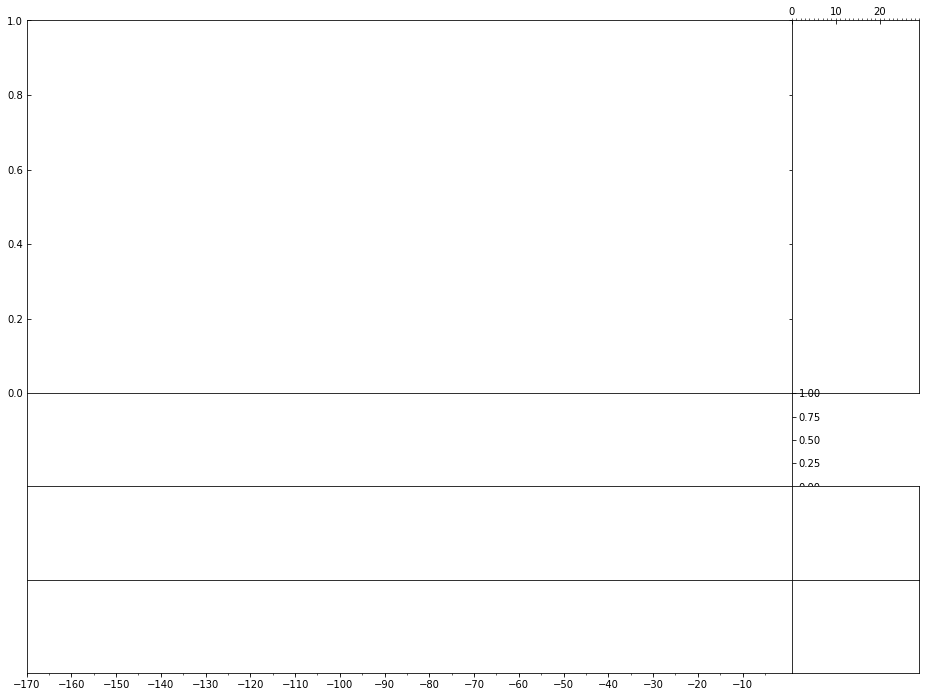

In [255]:
fig = plt.figure(figsize=(16, 12))
gs = gridspec.GridSpec(7, 7)
gs.update(wspace=0.0 , hspace=0.0 ) # set the spacing between axes. 
 

axPrice = plt.subplot(gs[0:4, :-1]) 
axPrice.tick_params(axis="y",direction="in", left="on",right="on" )
axPrice.get_xaxis().set_visible(False)
# Specify tick label size
axPrice.tick_params(axis = 'x', which = 'major', labelsize = 4)
axPrice.tick_params(axis = 'x', which = 'minor', labelsize = 0)
major_ticks = np.arange(-170, 0, 10)
minor_ticks = np.arange(-170, 0, 5)
axPrice.set_xticks(major_ticks)
axPrice.set_xticks(minor_ticks, minor = True)
 

axForecast = plt.subplot(gs[0:4, 6:] )

axForecast.get_yaxis().set_visible(False)
minor_ticks = np.arange(0, 30, 1)
axForecast.set_xticks(minor_ticks, minor = True )
axForecast.tick_params(axis="x",direction="in",top=True,bottom=False   )
axForecast.xaxis.set_ticks_position('top')

axVolume = plt.subplot(gs[4,:-1],sharex=axPrice)
axVolume.yaxis.tick_right()
axVolume.get_xaxis().set_visible(False)



axCash = plt.subplot(gs[5,:-1] )
axCash.get_yaxis().set_visible(False)
axCash.get_xaxis().set_visible(False)

ax5 = plt.subplot(gs[5,6:],sharey=axPrice)
ax5.get_yaxis().set_visible(False)
ax5.get_xaxis().set_visible(False)

axAction = plt.subplot(gs[6:,:-1],sharex=axPrice)
axAction.get_yaxis().set_visible(False)

ax7 = plt.subplot(gs[6:, 6:])
ax7.get_yaxis().set_visible(False)
ax7.get_xaxis().set_visible(False)


In [364]:
x=[2**i for i in range(8)]*3
y=[2 for i in range(8)]*3


In [381]:
z=zip(x,y) 

for i, (x, y) in enumerate(z):
    print(x,y)

1 2
2 2
4 2
8 2
16 2
32 2
64 2
128 2
1 2
2 2
4 2
8 2
16 2
32 2
64 2
128 2
1 2
2 2
4 2
8 2
16 2
32 2
64 2
128 2


In [325]:
tickHalfHours = getHalfHours()
tickindex = getHalfHourIndex(df.Time, tickHalfHours)


In [246]:
a=np.array([i-200 for i in range(0,200)])
print( a[-30:])

[-30 -29 -28 -27 -26 -25 -24 -23 -22 -21 -20 -19 -18 -17 -16 -15 -14 -13
 -12 -11 -10  -9  -8  -7  -6  -5  -4  -3  -2  -1]


In [249]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib

x = np.linspace(0, 10, 200).astype(np.float32)
y = np.sin(x)

offsets = np.dstack((x, y))

ax = plt.axes()

# Create a PathCollection to mirror the scatter behaviour.
def my_scatter(x, y):
    from matplotlib.collections import PathCollection
    from matplotlib.path import Path
    import matplotlib.transforms as mtransforms

    phi = np.linspace(0, 2 * np.pi, 100)
    # Scale, in pixel coordinates
    rad = 2
    x_circle = np.cos(phi) * rad
    y_circle = np.sin(phi) * rad

    verts = np.vstack([x_circle, y_circle]).T
    path = Path(verts, closed=False)
    collection = PathCollection([path], facecolor='blue', edgecolor='black',
                                offsets=offsets,
                                transOffset=ax.transData,
                                )
    collection.set_transform(mtransforms.IdentityTransform())
    ax.add_collection(collection, autolim=True)

    ax.autoscale()


my_scatter(x, y)
ax.plot(x, y)
ax.grid(True)
 

plt.show()

ValueError: 'vertices' must be a 2D list or array with shape Nx2

<Figure size 432x288 with 1 Axes>

In [265]:
sdata=[]
for s in data: 
    if(s[0].decode("utf-8")==current_date):
        sdata.append(s)

In [274]:
sdata

[(b'02/26/2001', b'09:41', 21.99, 21.99, 21.99, 21.99, 80587),
 (b'02/26/2001', b'09:44', 22.06, 22.06, 22.06, 22.06, 1947),
 (b'02/26/2001', b'09:46', 22.15, 22.15, 22.15, 22.15, 1947),
 (b'02/26/2001', b'10:14', 22.37, 22.37, 22.37, 22.37, 779),
 (b'02/26/2001', b'10:18', 22.5, 22.5, 22.5, 22.5, 116792),
 (b'02/26/2001', b'10:35', 22.5, 22.5, 22.5, 22.5, 1947),
 (b'02/26/2001', b'10:51', 22.66, 22.66, 22.66, 22.66, 779),
 (b'02/26/2001', b'11:01', 22.53, 22.53, 22.53, 22.53, 1168),
 (b'02/26/2001', b'11:13', 22.76, 22.81, 22.76, 22.81, 23358),
 (b'02/26/2001', b'11:20', 22.71, 22.71, 22.71, 22.71, 389),
 (b'02/26/2001', b'11:27', 22.82, 22.82, 22.82, 22.82, 389),
 (b'02/26/2001', b'11:39', 22.73, 22.73, 22.73, 22.73, 1557),
 (b'02/26/2001', b'11:45', 22.7, 22.7, 22.7, 22.7, 1168),
 (b'02/26/2001', b'12:02', 22.86, 22.86, 22.86, 22.86, 2336),
 (b'02/26/2001', b'12:07', 22.86, 22.86, 22.86, 22.86, 2336),
 (b'02/26/2001', b'12:30', 22.93, 22.93, 22.93, 22.93, 389),
 (b'02/26/2001', b'13

In [242]:
s = pd.Series(['1','1', '1', '1', '1', '2', '2', '2'])

print(s[:-2])

0    1
1    1
2    1
3    1
4    1
5    2
dtype: object


In [241]:
def thousands( x ):
        'The two args are the value and tick position'
        return '%1.1fK' % (x * 1e-3)

vh=4567
vl=230
vol_ranges=[ (vh - i * (vh - vl) / 5)  for i in range(1, 5)]
print(vol_ranges)
print(thousands(123))
for i in range(0, 5):
     print((5 - i) * 5, '{}'.format( thousands(vol_ranges[i])))


[3699.6, 2832.2, 1964.8000000000002, 1097.4]
0.1K
25 3.7K
20 2.8K
15 2.0K
10 1.1K


IndexError: list index out of range

In [272]:
max_time=datetime.strptime ("16:00",'%H:%M')
current_time = datetime.strptime ("09:30",'%H:%M') 
current_date='02/26/2001'
 
q = queue.Queue()
odata=[]

for s in data: 
    if(s[0].decode("utf-8")==current_date):
        q.put(s)
bDone = False        
for i in range(391):
     
    if not q.empty():
        s=q.get() 
    while True:
        t=datetime.strptime (s[1].decode("utf-8"),'%H:%M')
        print(t)
        print(current_time)
        if(t==current_time):
            odata.append([s[1].decode("utf-8"),s[2],s[3],s[4],s[5],s[6]])
            break
        if(t>current_time):
            time="{:02d}:{:02d}".format(current_time.hour,current_time.minute)
            odata.append([time,s[2],s[3],s[4],s[5],s[6]])
            current_time = current_time+one_minute
        if(t<current_time):
            if not q.empty():
                s=q.get()
            else:
                time="{:02d}:{:02d}".format(current_time.hour,current_time.minute)
                odata.append([time,s[2],s[3],s[4],s[5],s[6]])
                break
    if current_time==max_time:
        break
    current_time = current_time+one_minute
 

1900-01-01 09:41:00
1900-01-01 09:30:00
1900-01-01 09:41:00
1900-01-01 09:31:00
1900-01-01 09:41:00
1900-01-01 09:32:00
1900-01-01 09:41:00
1900-01-01 09:33:00
1900-01-01 09:41:00
1900-01-01 09:34:00
1900-01-01 09:41:00
1900-01-01 09:35:00
1900-01-01 09:41:00
1900-01-01 09:36:00
1900-01-01 09:41:00
1900-01-01 09:37:00
1900-01-01 09:41:00
1900-01-01 09:38:00
1900-01-01 09:41:00
1900-01-01 09:39:00
1900-01-01 09:41:00
1900-01-01 09:40:00
1900-01-01 09:41:00
1900-01-01 09:41:00
1900-01-01 09:44:00
1900-01-01 09:42:00
1900-01-01 09:44:00
1900-01-01 09:43:00
1900-01-01 09:44:00
1900-01-01 09:44:00
1900-01-01 09:46:00
1900-01-01 09:45:00
1900-01-01 09:46:00
1900-01-01 09:46:00
1900-01-01 10:14:00
1900-01-01 09:47:00
1900-01-01 10:14:00
1900-01-01 09:48:00
1900-01-01 10:14:00
1900-01-01 09:49:00
1900-01-01 10:14:00
1900-01-01 09:50:00
1900-01-01 10:14:00
1900-01-01 09:51:00
1900-01-01 10:14:00
1900-01-01 09:52:00
1900-01-01 10:14:00
1900-01-01 09:53:00
1900-01-01 10:14:00
1900-01-01 09:54:00


In [193]:
df

0      1        2        3        4        5       6
0        02/26/2001  09:41  21.9900  21.9900  21.9900  21.9900   80587
1        02/26/2001  09:44  22.0600  22.0600  22.0600  22.0600    1947
2        02/26/2001  09:46  22.1500  22.1500  22.1500  22.1500    1947
3        02/26/2001  10:14  22.3700  22.3700  22.3700  22.3700     779
4        02/26/2001  10:18  22.5000  22.5000  22.5000  22.5000  116792
5        02/26/2001  10:35  22.5000  22.5000  22.5000  22.5000    1947
6        02/26/2001  10:51  22.6600  22.6600  22.6600  22.6600     779
7        02/26/2001  11:01  22.5300  22.5300  22.5300  22.5300    1168
8        02/26/2001  11:13  22.7600  22.8100  22.7600  22.8100   23358
9        02/26/2001  11:20  22.7100  22.7100  22.7100  22.7100     389
10       02/26/2001  11:27  22.8200  22.8200  22.8200  22.8200     389
11       02/26/2001  11:39  22.7300  22.7300  22.7300  22.7300    1557
12       02/26/2001  11:45  22.7000  22.7000  22.7000  22.7000    1168
13       02/26/2001  12:02  22.8600  22.8600  22.8600  22.8600    2336
14       02/26/2001  12:07  22.8600  22.8600  22.8600  22.8600    2336
15       02/26/2001  12:30  22.9300  22.9300  22.9300  22.9300     389
16       02/26/2001  13:14  22.9000  22.9000  22.9000  22.9000    3893
17       02/26/2001  13:23  22.9000  22.9000  22.9000  22.9000     779
18       02/26/2001  13:44  22.8900  22.8900  22.8900  22.8900     779
19       02/26/2001  13:51  22.9000  22.9000  22.9000  22.9000    3893
20       02/26/2001  14:02  23.0000  23.0000  23.0000  23.0000     779
21       02/26/2001  14:09  22.9700  22.9700  22.9700  22.9700    3893
22       02/26/2001  14:16  23.1200  23.1200  23.1200  23.1200    1168
23       02/26/2001  14:21  23.1200  23.1200  23.1200  23.1200    2336
24       02/26/2001  14:22  23.1200  23.1200  23.1200  23.1200     779
25       02/26/2001  14:28  23.1300  23.1300  23.0800  23.0800    1947
26       02/26/2001  14:36  22.9300  22.9300  22.9300  22.9300     389
27       02/26/2001  15:01  22.9900  22.9900  22.9900  22.9900   97327
28       02/26/2001  15:34  22.9300  22.9300  22.9300  22.9300     389
29       02/26/2001  15:50  23.0300  23.0300  23.0300  23.0300     389
30       02/27/2001  09:38  23.0000  23.0000  23.0000  23.0000    1557
31       02/27/2001  09:40  23.1400  23.1400  23.1400  23.1400    1167
32       02/27/2001  09:41  23.1500  23.1500  23.1500  23.1500    2724
33       02/27/2001  09:43  23.1900  23.1900  23.1900  23.1900     778
34       02/27/2001  09:48  23.1400  23.1400  23.1400  23.1400     778
35       02/27/2001  09:51  23.1500  23.1500  23.1500  23.1500     778
36       02/27/2001  10:01  23.2500  23.2500  23.2500  23.2500     778
37       02/27/2001  10:02  23.2600  23.2600  23.2600  23.2600   11286
38       02/27/2001  10:28  23.1300  23.1300  23.1300  23.1300    1946
39       02/27/2001  10:35  23.1300  23.1300  23.1300  23.1300    1167
40       02/27/2001  10:37  23.1500  23.1500  23.1500  23.1500    7783
41       02/27/2001  10:40  23.1300  23.1300  23.1300  23.1300    7783
42       02/27/2001  10:57  23.0700  23.0700  23.0700  23.0700     778
43       02/27/2001  11:02  23.1900  23.1900  23.1900  23.1900     778
44       02/27/2001  11:07  23.1300  23.1300  23.1300  23.1300    7783
45       02/27/2001  11:09  23.1300  23.1300  23.1300  23.1300   15566
46       02/27/2001  11:29  23.0600  23.0600  23.0600  23.0600    5059
47       02/27/2001  11:45  23.0400  23.0400  23.0400  23.0400     778
48       02/27/2001  11:47  23.0300  23.0300  23.0300  23.0300   11675
49       02/27/2001  11:55  23.1400  23.1400  23.1400  23.1400     778
50       02/27/2001  12:05  23.0500  23.0500  23.0500  23.0500    4670
51       02/27/2001  13:19  23.1300  23.1300  23.1300  23.1300     389
52       02/27/2001  13:29  23.0200  23.0200  23.0200  23.0200    2724
53       02/27/2001  13:44  23.0100  23.0100  23.0100  23.0100     389
54       02/27/2001  13:49  23.0200  23.0200  23.0200  23.0200    3892
55       02/27/2001  13:58  23.0200  23.02